In [49]:
# =============================================================
# Setup + paths
# =============================================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    brier_score_loss, accuracy_score,
    precision_score, recall_score, f1_score
)

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")
DBG_DIR = os.path.join(OUT_DIR, "debug")
for d in [OUT_DIR, FIG_DIR, TAB_DIR, DBG_DIR]:
    os.makedirs(d, exist_ok=True)

# --- EDIT THESE PATHS ---
NHANES_CSV = "/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes/nhanes_pooled.csv"
SPARCS_CSV = "/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_t2d_with_targets.csv"

print("OK | Output dirs:", OUT_DIR)
print("NHANES_CSV:", NHANES_CSV)
print("SPARCS_CSV:", SPARCS_CSV)


Mounted at /content/drive
OK | Output dirs: outputs
NHANES_CSV: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes/nhanes_pooled.csv
SPARCS_CSV: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_t2d_with_targets.csv


In [50]:
# =============================================================
# Auto-detect dataset paths (Google Drive)
# =============================================================
import os, glob

# If you're in Colab, mount Drive (safe if already mounted)
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception as e:
    print("Drive mount skipped:", e)

def find_first(patterns, base="/content/drive/MyDrive", recursive=True):
    for pat in patterns:
        hits = glob.glob(os.path.join(base, "**", pat) if recursive else os.path.join(base, pat), recursive=recursive)
        if hits:
            # Prefer shorter path (usually less nested duplicates)
            hits = sorted(hits, key=lambda x: (len(x), x))
            return hits[0], hits[:10]
    return None, []

# --- NHANES candidates (from your zip) ---
NHANES_PATTERNS = [
    "nhanes_t2d_treated_tb_multi_with_targets.csv",
    "nhanes_t2d_treated_tb_with_targets.csv",
    "*nhanes*with_targets*.csv",
]

# --- SPARCS candidates (adapt if your filename differs) ---
SPARCS_PATTERNS = [
    "sparcs_2020_t2d_with_targets.csv",
    "*sparcs*t2d*with_targets*.csv",
]

nh_path, nh_hits = find_first(NHANES_PATTERNS)
sp_path, sp_hits = find_first(SPARCS_PATTERNS)

print("NHANES found:", nh_path)
print("NHANES top hits:", nh_hits)
print("SPARCS found:", sp_path)
print("SPARCS top hits:", sp_hits)

# Set paths used by the pipeline
if nh_path is not None:
    NHANES_CSV = nh_path
if sp_path is not None:
    SPARCS_CSV = sp_path

print("Using NHANES_CSV:", NHANES_CSV)
print("Using SPARCS_CSV:", SPARCS_CSV)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
NHANES found: None
NHANES top hits: []
SPARCS found: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_t2d_with_targets.csv
SPARCS top hits: ['/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_t2d_with_targets.csv']
Using NHANES_CSV: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes/nhanes_pooled.csv
Using SPARCS_CSV: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_t2d_with_targets.csv


In [51]:
# =============================================================
# NHANES: Bulletproof path + (optional) unzip + normalise XPT filenames + inventory
# This cell NEVER calls .glob() on NHANES_LOCAL_DIR (which may be a str in your notebook).
# =============================================================

import pathlib
import re
import shutil
import zipfile
import pandas as pd
from IPython.display import display

FORCED_DIR_STR = "/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes"

# Always work with a local Path object that cannot be overwritten by your notebook globals
nh_dir = pathlib.Path(FORCED_DIR_STR).expanduser().resolve()
nh_dir.mkdir(parents=True, exist_ok=True)

# Keep global as string for compatibility with other cells, but DO NOT reuse it here
globals()["NHANES_LOCAL_DIR"] = str(nh_dir)

print(f"[NHANES PATH] nh_dir={nh_dir} | type(nh_dir)={type(nh_dir)}")
print(f"[NHANES PATH] globals()['NHANES_LOCAL_DIR']={globals()['NHANES_LOCAL_DIR']} | type={type(globals()['NHANES_LOCAL_DIR'])}")
print(f"[NHANES DEBUG] pathlib.Path is {pathlib.Path} | type(pathlib.Path)={type(pathlib.Path)}")

# 1) OPTIONAL: unzip most recent zip in nh_dir
zip_candidates = sorted(list(nh_dir.glob("*.zip")), key=lambda p: p.stat().st_mtime, reverse=True)
if zip_candidates:
    zp = zip_candidates[0]
    print(f"[NHANES ZIP] Found zip: {zp.name}. Extracting into {nh_dir}")
    with zipfile.ZipFile(zp, "r") as zf:
        zf.extractall(nh_dir)
    print("[NHANES ZIP] Extract done.")
else:
    print("[NHANES ZIP] No zip found. Skipping extraction.")

# 2) Scan recursively for XPTs
all_xpts = [p for p in nh_dir.rglob("*") if p.is_file() and p.suffix.lower() == ".xpt"]
print(f"[NHANES SCAN] Found {len(all_xpts)} .xpt files under {nh_dir} (recursive).")

# 3) Normalise names into root as STEM_{cycle}.XPT
CYCLES = list("ABCDEFGHIJ")
STEMS = ["DEMO", "DIQ", "GHB"]

# Match flexible names: DEMO_G.XPT, DEMOG.XPT, demo-g.xpt, GHB J (1).xpt, etc.
pat = re.compile(r"(?P<stem>DEMO|DIQ|GHB)\s*[_\-\s]?\s*(?P<cyc>[A-J])", re.IGNORECASE)

cands = {(s, c): [] for s in STEMS for c in CYCLES}
for p in all_xpts:
    m = pat.search(p.name)
    if m:
        stem = m.group("stem").upper()
        cyc = m.group("cyc").upper()
        if stem in STEMS and cyc in CYCLES:
            cands[(stem, cyc)].append(p)

def best_path(paths):
    if not paths:
        return None
    return sorted(paths, key=lambda x: x.stat().st_size if x.exists() else 0, reverse=True)[0]

actions = []
for stem in STEMS:
    for cyc in CYCLES:
        target = nh_dir / f"{stem}_{cyc}.XPT"
        src = best_path(cands[(stem, cyc)])

        if target.exists() and target.stat().st_size > 1024:
            actions.append((stem, cyc, target.name, "OK (already present)"))
            continue

        if src is None:
            actions.append((stem, cyc, "", "MISSING (no candidate found)"))
            continue

        try:
            shutil.copy2(src, target)
            actions.append((stem, cyc, f"{src.name} -> {target.name}", "COPIED"))
        except Exception as e:
            actions.append((stem, cyc, src.name, f"FAILED COPY: {e}"))

actions_df = pd.DataFrame(actions, columns=["stem", "cycle", "detail", "status"])
print("[NHANES NORMALISE] MISSING/FAILED rows:")
display(actions_df[actions_df["status"].str.startswith(("MISSING", "FAILED"))])

# 4) Inventory (exact expected names in root)
def _exists(p: pathlib.Path) -> bool:
    return p.exists() and p.stat().st_size > 1024

inv = []
for cyc in CYCLES:
    inv.append({
        "cycle": cyc,
        "DEMO": f"DEMO_{cyc}.XPT" if _exists(nh_dir / f"DEMO_{cyc}.XPT") else "",
        "DIQ":  f"DIQ_{cyc}.XPT"  if _exists(nh_dir / f"DIQ_{cyc}.XPT")  else "",
        "GHB":  f"GHB_{cyc}.XPT"  if _exists(nh_dir / f"GHB_{cyc}.XPT")  else "",
        "all_present": all(_exists(nh_dir / f"{s}_{cyc}.XPT") for s in STEMS)
    })

inv_df = pd.DataFrame(inv)
print("[NHANES INVENTORY] after normalisation:")
display(inv_df)

# Extra: show what XPTs exist in root that match DEMO/DIQ/GHB for quick inspection
root_xpts = sorted([p.name for p in nh_dir.glob("*.XPT")]) + sorted([p.name for p in nh_dir.glob("*.xpt")])
print(f"[NHANES ROOT] root-level XPT count = {len(root_xpts)}")
print("[NHANES ROOT] first 40 root XPT names:", root_xpts[:40])


[NHANES PATH] nh_dir=/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes | type(nh_dir)=<class 'pathlib.PosixPath'>
[NHANES PATH] globals()['NHANES_LOCAL_DIR']=/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes | type=<class 'str'>
[NHANES DEBUG] pathlib.Path is <class 'pathlib.Path'> | type(pathlib.Path)=<class 'type'>
[NHANES ZIP] No zip found. Skipping extraction.
[NHANES SCAN] Found 33 .xpt files under /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes (recursive).
[NHANES NORMALISE] MISSING/FAILED rows:


Empty DataFrame
Columns: [stem, cycle, detail, status]
Index: []

[NHANES INVENTORY] after normalisation:


cycle        DEMO        DIQ        GHB  all_present
0     A  DEMO_A.XPT  DIQ_A.XPT  GHB_A.XPT         True
1     B  DEMO_B.XPT  DIQ_B.XPT  GHB_B.XPT         True
2     C  DEMO_C.XPT  DIQ_C.XPT  GHB_C.XPT         True
3     D  DEMO_D.XPT  DIQ_D.XPT  GHB_D.XPT         True
4     E  DEMO_E.XPT  DIQ_E.XPT  GHB_E.XPT         True
5     F  DEMO_F.XPT  DIQ_F.XPT  GHB_F.XPT         True
6     G  DEMO_G.XPT  DIQ_G.XPT  GHB_G.XPT         True
7     H  DEMO_H.XPT  DIQ_H.XPT  GHB_H.XPT         True
8     I  DEMO_I.XPT  DIQ_I.XPT  GHB_I.XPT         True
9     J  DEMO_J.XPT  DIQ_J.XPT  GHB_J.XPT         True

[NHANES ROOT] root-level XPT count = 33
[NHANES ROOT] first 40 root XPT names: ['DEMO_A.XPT', 'DEMO_B.XPT', 'DEMO_C.XPT', 'DEMO_D.XPT', 'DEMO_E.XPT', 'DEMO_F.XPT', 'DEMO_G.XPT', 'DEMO_H.XPT', 'DEMO_I.XPT', 'DEMO_J.XPT', 'DIQ_A.XPT', 'DIQ_B.XPT', 'DIQ_C.XPT', 'DIQ_D.XPT', 'DIQ_E.XPT', 'DIQ_F.XPT', 'DIQ_G.XPT', 'DIQ_H.XPT', 'DIQ_I.XPT', 'DIQ_J.XPT', 'GHB_A.XPT', 'GHB_B.XPT', 'GHB_C.XPT', 'GHB_D.XPT', 'GHB_E.XPT', 'GHB_F.XPT', 'GHB_G.XPT', 'GHB_H.XPT', 'GHB_I.XPT', 'GHB_J.XPT', 'DEMO_J.xpt', 'DIQ_J.xpt', 'GHB_J.xpt']


In [52]:
import os
import requests
import pandas as pd

NHANES_BASE = "https://wwwn.cdc.gov/Nchs/Nhanes"

cycle_to_year = {
    "G": "2011-2012",
    "H": "2013-2014",
    "I": "2015-2016",
    "J": "2017-2018",
}

components = ["DEMO", "DIQ", "GHB"]  # aggiungi qui altri moduli se servono
out_dir = "data_raw/nhanes_xpt"
os.makedirs(out_dir, exist_ok=True)

rows = []
for cyc, year in cycle_to_year.items():
    for comp in components:
        fname = f"{comp}_{cyc}.XPT"
        url = f"{NHANES_BASE}/{year}/{fname}"
        try:
            r = requests.head(url, allow_redirects=True, timeout=20)
            status = r.status_code
        except Exception as e:
            status = f"ERR: {type(e).__name__}"
        rows.append({"cycle": cyc, "year": year, "file": fname, "status": status, "url": url})

df_check = pd.DataFrame(rows)
df_check


cycle       year        file  status  \
0      G  2011-2012  DEMO_G.XPT     200   
1      G  2011-2012   DIQ_G.XPT     200   
2      G  2011-2012   GHB_G.XPT     200   
3      H  2013-2014  DEMO_H.XPT     200   
4      H  2013-2014   DIQ_H.XPT     200   
5      H  2013-2014   GHB_H.XPT     200   
6      I  2015-2016  DEMO_I.XPT     200   
7      I  2015-2016   DIQ_I.XPT     200   
8      I  2015-2016   GHB_I.XPT     200   
9      J  2017-2018  DEMO_J.XPT     200   
10     J  2017-2018   DIQ_J.XPT     200   
11     J  2017-2018   GHB_J.XPT     200   

                                                  url  
0   https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DEM...  
1   https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DIQ...  
2   https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/GHB...  
3   https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEM...  
4   https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DIQ...  
5   https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/GHB...  
6   https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEM...  
7   https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DIQ...  
8   https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/GHB...  
9   https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEM...  
10  https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DIQ...  
11  https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/GHB...

In [53]:
import requests

def download(url, dest_path):
    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(dest_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

download_log = []
for _, row in df_check.iterrows():
    if row["status"] == 200:
        dest = os.path.join(out_dir, row["file"])
        if not os.path.exists(dest):
            download(row["url"], dest)
            download_log.append(("downloaded", row["file"]))
        else:
            download_log.append(("exists", row["file"]))
    else:
        download_log.append(("missing_url", row["file"]))

download_log[:10], len(download_log)


([('exists', 'DEMO_G.XPT'),
  ('exists', 'DIQ_G.XPT'),
  ('exists', 'GHB_G.XPT'),
  ('exists', 'DEMO_H.XPT'),
  ('exists', 'DIQ_H.XPT'),
  ('exists', 'GHB_H.XPT'),
  ('exists', 'DEMO_I.XPT'),
  ('exists', 'DIQ_I.XPT'),
  ('exists', 'GHB_I.XPT'),
  ('exists', 'DEMO_J.XPT')],
 12)

In [54]:
import pandas as pd
from pathlib import Path

p = Path(out_dir)

inv = []
for cyc in ["G","H","I","J"]:
    inv.append({
        "cycle": cyc,
        "DEMO": (p / f"DEMO_{cyc}.XPT").exists(),
        "DIQ":  (p / f"DIQ_{cyc}.XPT").exists(),
        "GHB":  (p / f"GHB_{cyc}.XPT").exists(),
    })

pd.DataFrame(inv)


cycle  DEMO   DIQ   GHB
0     G  True  True  True
1     H  True  True  True
2     I  True  True  True
3     J  True  True  True

In [55]:
import os, shutil, glob
from pathlib import Path

# SOURCE: dove hai scaricato gli XPT (aggiorna se diverso)
SRC_DIR = "data_raw/nhanes_xpt"

# TARGET: dove la pipeline li cerca
TGT_DIR = "/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes"

os.makedirs(TGT_DIR, exist_ok=True)

src_files = glob.glob(os.path.join(SRC_DIR, "*.XPT"))
print("Found in SRC:", len(src_files))

moved = 0
for f in src_files:
    dest = os.path.join(TGT_DIR, os.path.basename(f))
    if not os.path.exists(dest):
        shutil.copy2(f, dest)
        moved += 1

print("Copied new files to TGT:", moved)
print("Example files now in TGT:", sorted([p.name for p in Path(TGT_DIR).glob("DEMO_*.XPT")])[:12])


Found in SRC: 12
Copied new files to TGT: 0
Example files now in TGT: ['DEMO_A.XPT', 'DEMO_B.XPT', 'DEMO_C.XPT', 'DEMO_D.XPT', 'DEMO_E.XPT', 'DEMO_F.XPT', 'DEMO_G.XPT', 'DEMO_H.XPT', 'DEMO_I.XPT', 'DEMO_J.XPT']


In [56]:
# =============================================================
# Utilities
# =============================================================
def pick_threshold_max_f1(y, p, grid=None):
    # Pick threshold that maximizes F1 on validation
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    best_thr, best_f1 = 0.5, -1
    for thr in grid:
        yhat = (p >= thr).astype(int)
        f1 = f1_score(y, yhat, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return float(best_thr), float(best_f1)

def bootstrap_auc_ci(y, p, kind="roc", B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    n = len(y)

    # Undefined if subgroup has one class
    if len(np.unique(y)) < 2:
        return np.nan, (np.nan, np.nan)

    def score(yy, pp):
        if kind == "roc":
            return roc_auc_score(yy, pp)
        return average_precision_score(yy, pp)

    point = score(y, p)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        yy = y[idx]; pp = p[idx]
        if len(np.unique(yy)) < 2:
            continue
        vals.append(score(yy, pp))

    if len(vals) < 50:
        return float(point), (np.nan, np.nan)

    lo = float(np.quantile(vals, 0.025))
    hi = float(np.quantile(vals, 0.975))
    return float(point), (lo, hi)

def bootstrap_thr_ci(y, p, thr, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    n = len(y)

    def metrics(yy, pp):
        yh = (pp >= thr).astype(int)
        rec = recall_score(yy, yh, zero_division=0)
        f1  = f1_score(yy, yh, zero_division=0)
        return rec, f1

    rec0, f10 = metrics(y, p)
    rec_vals, f1_vals = [], []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        rec, f1 = metrics(y[idx], p[idx])
        rec_vals.append(rec); f1_vals.append(f1)

    rec_ci = (float(np.quantile(rec_vals, 0.025)), float(np.quantile(rec_vals, 0.975)))
    f1_ci  = (float(np.quantile(f1_vals, 0.025)),  float(np.quantile(f1_vals, 0.975)))
    return float(rec0), rec_ci, float(f10), f1_ci

def fmt_ci(x, ci):
    lo, hi = ci
    if np.isnan(x) or np.isnan(lo) or np.isnan(hi):
        return np.nan
    return f"{x:.3f} [{lo:.3f}, {hi:.3f}]"

def eval_from_proba(y, p, thr):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    yhat = (p >= thr).astype(int)
    out = {
        "ROC AUC": roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan,
        "PR AUC": average_precision_score(y, p) if len(np.unique(y)) > 1 else np.nan,
        "Brier": brier_score_loss(y, p),
        "Accuracy": accuracy_score(y, yhat),
        "Precision": precision_score(y, yhat, zero_division=0),
        "Recall": recall_score(y, yhat, zero_division=0),
        "F1 (pos)": f1_score(y, yhat, zero_division=0),
    }
    return out

def table3_row(branch, outcome, model, thr, y_test, p_test, B=1000, seed=42):
    met = eval_from_proba(y_test, p_test, thr)
    roc, roc_ci = bootstrap_auc_ci(y_test, p_test, kind="roc", B=B, seed=seed)
    pr,  pr_ci  = bootstrap_auc_ci(y_test, p_test, kind="pr",  B=B, seed=seed)
    return {
        "Branch": branch,
        "Outcome": outcome,
        "Model": model,
        "Threshold (VAL)": float(thr),
        **met,
        "ROC AUC (95% CI)": fmt_ci(roc, roc_ci),
        "PR AUC (95% CI)": fmt_ci(pr, pr_ci),
    }

def plot_curves(y, proba_dict, title, save_path):
    # proba_dict: {label: probas}
    plt.figure(figsize=(10, 4))
    # ROC
    plt.subplot(1, 2, 1)
    for name, p in proba_dict.items():
        if len(np.unique(y)) < 2:
            continue
        fpr, tpr, _ = roc_curve(y, p)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title} | ROC"); plt.legend()

    # PR
    plt.subplot(1, 2, 2)
    for name, p in proba_dict.items():
        prec, rec, _ = precision_recall_curve(y, p)
        plt.plot(rec, prec, label=name)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | PR"); plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_calibration(y, proba_dict, title, save_path, n_bins=10):
    plt.figure(figsize=(5, 4))
    for name, p in proba_dict.items():
        frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", label=name)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("Mean predicted"); plt.ylabel("Fraction positives")
    plt.title(f"{title} | Calibration")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def shap_tree_summary(best_pipe, X_train, X_test, title, save_path, max_display=20, nsample=800):
    # SHAP for tree model only; robust in Colab via matplotlib summary_plot
    pre = best_pipe.named_steps["pre"]
    model = best_pipe.named_steps["model"]

    # Sample to keep it fast and avoid huge dense matrices
    Xb = X_train.sample(min(nsample, len(X_train)), random_state=RANDOM_STATE)
    Xt = X_test.sample(min(nsample, len(X_test)), random_state=RANDOM_STATE)

    Xb_t = pre.transform(Xb)
    Xt_t = pre.transform(Xt)

    # Feature names (best-effort)
    try:
        feat_names = pre.get_feature_names_out()
    except Exception:
        feat_names = np.array([f"f{i}" for i in range(Xb_t.shape[1])])

    # Convert to dense for SHAP if needed (keep sample small)
    if hasattr(Xb_t, "toarray"):
        Xb_t_dense = Xb_t.toarray()
        Xt_t_dense = Xt_t.toarray()
    else:
        Xb_t_dense = np.asarray(Xb_t)
        Xt_t_dense = np.asarray(Xt_t)

    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(Xt_t_dense)

    plt.figure(figsize=(8, 5))
    shap.summary_plot(sv, Xt_t_dense, feature_names=feat_names, show=False, max_display=max_display)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()


In [57]:
# =============================================================
# NHANES: download missing cycles A..F XPTs (DEMO, DIQ, HbA1c) into NHANES_LOCAL_DIR
# - Standardises names to: DEMO_{cycle}.XPT, DIQ_{cycle}.XPT, GHB_{cycle}.XPT
# - Handles older HbA1c naming: 1999-2000 uses LAB10, 2001-2004 uses L10_*
# =============================================================

import os
import requests
from pathlib import Path
import pandas as pd
from IPython.display import display

NHANES_LOCAL_DIR = globals().get("NHANES_LOCAL_DIR", None)
if NHANES_LOCAL_DIR is None:
    NHANES_LOCAL_DIR = Path("./nhanes").resolve()
else:
    NHANES_LOCAL_DIR = Path(NHANES_LOCAL_DIR).resolve()
NHANES_LOCAL_DIR.mkdir(parents=True, exist_ok=True)
print(f"[NHANES DL] NHANES_LOCAL_DIR={NHANES_LOCAL_DIR}")

# Cycle -> period folder on CDC site
PERIOD = {
    "A": "1999-2000",
    "B": "2001-2002",
    "C": "2003-2004",
    "D": "2005-2006",
    "E": "2007-2008",
    "F": "2009-2010",
}

# What to download per cycle:
# - For A, DEMO and DIQ have no suffix on CDC (DEMO.XPT / DIQ.XPT)
# - HbA1c naming varies: A: LAB10.XPT, B: L10_B.XPT, C: L10_C.XPT, D/E/F: GHB_*.XPT
DOWNLOAD_MAP = {
    "A": {"DEMO": "DEMO.XPT",    "DIQ": "DIQ.XPT",    "GHB": "LAB10.XPT"},
    "B": {"DEMO": "DEMO_B.XPT",  "DIQ": "DIQ_B.XPT",  "GHB": "L10_B.XPT"},
    "C": {"DEMO": "DEMO_C.XPT",  "DIQ": "DIQ_C.XPT",  "GHB": "L10_C.XPT"},
    "D": {"DEMO": "DEMO_D.XPT",  "DIQ": "DIQ_D.XPT",  "GHB": "GHB_D.XPT"},
    "E": {"DEMO": "DEMO_E.XPT",  "DIQ": "DIQ_E.XPT",  "GHB": "GHB_E.XPT"},
    "F": {"DEMO": "DEMO_F.XPT",  "DIQ": "DIQ_F.XPT",  "GHB": "GHB_F.XPT"},
}

BASE = "https://wwwn.cdc.gov/Nchs/Nhanes/{period}/{fname}"

def _download(url: str, out_path: Path, timeout=90) -> bool:
    try:
        r = requests.get(url, stream=True, timeout=timeout)
        if r.status_code != 200:
            return False
        # quick sanity: some error pages return tiny content
        content_len = int(r.headers.get("Content-Length", "0") or "0")
        if content_len and content_len < 1024:
            return False
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 128):
                if chunk:
                    f.write(chunk)
        # file size sanity
        if out_path.stat().st_size < 1024:
            out_path.unlink(missing_ok=True)
            return False
        return True
    except Exception:
        return False

def ensure_cycle_files(cyc: str):
    cyc = str(cyc).strip().upper()
    if cyc not in DOWNLOAD_MAP:
        raise ValueError(f"Cycle {cyc} not supported by this downloader. Supported: {list(DOWNLOAD_MAP.keys())}")

    period = PERIOD[cyc]
    spec = DOWNLOAD_MAP[cyc]

    results = []
    for stem, remote_fname in spec.items():
        # Standardised local name expected by your pipeline:
        # DEMO_A.XPT, DIQ_A.XPT, GHB_A.XPT etc.
        local_fname = f"{stem}_{cyc}.XPT"
        local_path = NHANES_LOCAL_DIR / local_fname

        if local_path.exists() and local_path.stat().st_size > 1024:
            results.append((cyc, stem, remote_fname, local_fname, "SKIP (exists)"))
            continue

        url = BASE.format(period=period, fname=remote_fname)
        ok = _download(url, local_path)

        if ok:
            results.append((cyc, stem, remote_fname, local_fname, "DOWNLOADED"))
        else:
            # Clean up partials
            if local_path.exists():
                try:
                    local_path.unlink()
                except Exception:
                    pass
            results.append((cyc, stem, remote_fname, local_fname, f"FAILED ({url})"))

    return results

# ---- Run for A..F ----
all_results = []
for cyc in ["A","B","C","D","E","F"]:
    all_results.extend(ensure_cycle_files(cyc))

res_df = pd.DataFrame(all_results, columns=["cycle","stem","remote_fname","local_fname","status"])
print("[NHANES DL] download results:")
display(res_df)

# ---- Inventory check (DEMO/DIQ/GHB) ----
def _exists(p: Path) -> bool:
    return p.exists() and p.stat().st_size > 1024

inv = []
for cyc in list("ABCDEFGHIJ"):
    inv.append({
        "cycle": cyc,
        "DEMO": f"DEMO_{cyc}.XPT" if _exists(NHANES_LOCAL_DIR / f"DEMO_{cyc}.XPT") else "",
        "DIQ":  f"DIQ_{cyc}.XPT"  if _exists(NHANES_LOCAL_DIR / f"DIQ_{cyc}.XPT")  else "",
        "GHB":  f"GHB_{cyc}.XPT"  if _exists(NHANES_LOCAL_DIR / f"GHB_{cyc}.XPT")  else "",
        "all_present": all(_exists(NHANES_LOCAL_DIR / f"{s}_{cyc}.XPT") for s in ["DEMO","DIQ","GHB"])
    })

inv_df = pd.DataFrame(inv)
print("[NHANES DL] inventory after download:")
display(inv_df)


[NHANES DL] NHANES_LOCAL_DIR=/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes
[NHANES DL] download results:


cycle  stem remote_fname local_fname         status
0      A  DEMO     DEMO.XPT  DEMO_A.XPT  SKIP (exists)
1      A   DIQ      DIQ.XPT   DIQ_A.XPT  SKIP (exists)
2      A   GHB    LAB10.XPT   GHB_A.XPT  SKIP (exists)
3      B  DEMO   DEMO_B.XPT  DEMO_B.XPT  SKIP (exists)
4      B   DIQ    DIQ_B.XPT   DIQ_B.XPT  SKIP (exists)
5      B   GHB    L10_B.XPT   GHB_B.XPT  SKIP (exists)
6      C  DEMO   DEMO_C.XPT  DEMO_C.XPT  SKIP (exists)
7      C   DIQ    DIQ_C.XPT   DIQ_C.XPT  SKIP (exists)
8      C   GHB    L10_C.XPT   GHB_C.XPT  SKIP (exists)
9      D  DEMO   DEMO_D.XPT  DEMO_D.XPT  SKIP (exists)
10     D   DIQ    DIQ_D.XPT   DIQ_D.XPT  SKIP (exists)
11     D   GHB    GHB_D.XPT   GHB_D.XPT  SKIP (exists)
12     E  DEMO   DEMO_E.XPT  DEMO_E.XPT  SKIP (exists)
13     E   DIQ    DIQ_E.XPT   DIQ_E.XPT  SKIP (exists)
14     E   GHB    GHB_E.XPT   GHB_E.XPT  SKIP (exists)
15     F  DEMO   DEMO_F.XPT  DEMO_F.XPT  SKIP (exists)
16     F   DIQ    DIQ_F.XPT   DIQ_F.XPT  SKIP (exists)
17     F   GHB    GHB_F.XPT   GHB_F.XPT  SKIP (exists)

[NHANES DL] inventory after download:


cycle        DEMO        DIQ        GHB  all_present
0     A  DEMO_A.XPT  DIQ_A.XPT  GHB_A.XPT         True
1     B  DEMO_B.XPT  DIQ_B.XPT  GHB_B.XPT         True
2     C  DEMO_C.XPT  DIQ_C.XPT  GHB_C.XPT         True
3     D  DEMO_D.XPT  DIQ_D.XPT  GHB_D.XPT         True
4     E  DEMO_E.XPT  DIQ_E.XPT  GHB_E.XPT         True
5     F  DEMO_F.XPT  DIQ_F.XPT  GHB_F.XPT         True
6     G  DEMO_G.XPT  DIQ_G.XPT  GHB_G.XPT         True
7     H  DEMO_H.XPT  DIQ_H.XPT  GHB_H.XPT         True
8     I  DEMO_I.XPT  DIQ_I.XPT  GHB_I.XPT         True
9     J  DEMO_J.XPT  DIQ_J.XPT  GHB_J.XPT         True

In [58]:
# =============================================================
# NHANES: build (multi-cycle) + strict temporal split + outcome + metadata
#    Train = earlier cycles, Test = most recent cycle
#    FIX: redownload invalid "XPT" (HTML/404) using correct CDC DataFiles URLs
# =============================================================

import numpy as np
import pandas as pd
import pathlib
import requests
from sklearn.model_selection import train_test_split
from IPython.display import display

# -----------------------------
# 2.0) Paths + config
# -----------------------------
FORCED_DIR_STR = "/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes"
nh_dir = pathlib.Path(FORCED_DIR_STR).expanduser().resolve()
nh_dir.mkdir(parents=True, exist_ok=True)

globals()["NHANES_LOCAL_DIR"] = str(nh_dir)  # keep compatibility with other cells

CYCLE_LETTERS = list("ABCDEFGHIJ")
TEST_CYCLE = str(globals().get("TEST_CYCLE", "J")).strip().upper()
FORCE_REBUILD_FROM_XPT = True
AUTO_REDOWNLOAD_INVALID_XPT = True

print(f"[NHANES] NHANES_LOCAL_DIR={nh_dir}")
print(f"[NHANES] FORCE_REBUILD_FROM_XPT={FORCE_REBUILD_FROM_XPT}")
print(f"[NHANES] TEST_CYCLE={TEST_CYCLE}")
print(f"[NHANES] AUTO_REDOWNLOAD_INVALID_XPT={AUTO_REDOWNLOAD_INVALID_XPT}")

# -----------------------------
# 2.1) Begin-year mapping (Public/{begin_year}/DataFiles/)
# -----------------------------
BEGIN_YEAR = {
    "A": 1999, "B": 2001, "C": 2003, "D": 2005, "E": 2007,
    "F": 2009, "G": 2011, "H": 2013, "I": 2015, "J": 2017,
}

# Remote filenames (the actual file names used by CDC in DataFiles/)
# A is special (no suffix for DEMO/DIQ; HbA1c is LAB10)
REMOTE_FNAME = {
    "A": {"DEMO": "DEMO.xpt",   "DIQ": "DIQ.xpt",   "GHB": "LAB10.xpt"},
    "B": {"DEMO": "DEMO_B.xpt", "DIQ": "DIQ_B.xpt", "GHB": "L10_B.xpt"},
    "C": {"DEMO": "DEMO_C.xpt", "DIQ": "DIQ_C.xpt", "GHB": "L10_C.xpt"},
    # D..J standard pattern
}

def remote_fname(stem: str, cyc: str) -> str:
    stem = stem.upper()
    cyc = cyc.upper()
    if cyc in REMOTE_FNAME:
        return REMOTE_FNAME[cyc][stem]
    return f"{stem}_{cyc}.xpt"

BASE_URL = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{begin_year}/DataFiles/{fname}"

# -----------------------------
# 2.2) XPT signature check + download
# -----------------------------
def is_xport_file(path: pathlib.Path) -> bool:
    """XPORT files contain 'HEADER RECORD' in the first ~512 bytes."""
    try:
        with open(path, "rb") as f:
            head = f.read(512)
        return b"HEADER RECORD" in head
    except Exception:
        return False

def download_xpt(url: str, out_path: pathlib.Path, timeout=180) -> tuple[bool, str]:
    """Download and write to disk. Return (ok, diagnostic)."""
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "*/*",
    }
    try:
        r = requests.get(url, headers=headers, timeout=timeout, allow_redirects=True)
        ct = (r.headers.get("Content-Type") or "").lower()
        if r.status_code != 200 or len(r.content) < 2048:
            return False, f"HTTP {r.status_code} | bytes={len(r.content)} | ct={ct}"
        out_path.write_bytes(r.content)
        return True, f"HTTP 200 | bytes={len(r.content)} | ct={ct}"
    except Exception as e:
        return False, f"EXC {type(e).__name__}: {e}"

def ensure_valid_xpt(stem: str, cyc: str) -> pathlib.Path:
    """
    Ensure STEM_{cyc}.XPT exists locally and is a valid XPORT.
    If invalid and AUTO_REDOWNLOAD_INVALID_XPT=True, re-download from CDC DataFiles.
    """
    stem = stem.upper()
    cyc = cyc.upper()

    local = nh_dir / f"{stem}_{cyc}.XPT"
    if not local.exists():
        raise FileNotFoundError(f"Missing local file: {local.name} in {nh_dir}")

    if is_xport_file(local):
        return local

    # If invalid, overwrite with correct download
    if not AUTO_REDOWNLOAD_INVALID_XPT:
        with open(local, "rb") as f:
            head = f.read(200)
        raise RuntimeError(f"{local.name} not XPORT. First 200 bytes:\n{head}")

    by = BEGIN_YEAR.get(cyc)
    if by is None:
        raise RuntimeError(f"No begin-year mapping for cycle {cyc}")

    fname = remote_fname(stem, cyc)
    url = BASE_URL.format(begin_year=by, fname=fname)

    print(f"[NHANES] Re-downloading invalid {local.name} from {url}")
    ok, diag = download_xpt(url, local)
    if not ok:
        raise RuntimeError(f"Download failed for {local.name} | {diag}")

    if not is_xport_file(local):
        with open(local, "rb") as f:
            head = f.read(200)
        raise RuntimeError(
            f"Downloaded file is still not valid XPORT: {local.name}\n"
            f"Download diag: {diag}\n"
            f"First 200 bytes:\n{head}"
        )

    return local

def read_xpt(stem: str, cyc: str) -> pd.DataFrame:
    p = ensure_valid_xpt(stem, cyc)
    df = pd.read_sas(p, format="xport", encoding="utf-8")
    df.columns = [str(c).strip() for c in df.columns]
    if "SEQN" not in df.columns:
        raise ValueError(f"{p.name} has no SEQN column, cannot merge.")
    return df

# -----------------------------
# 2.3) Build cycles A..J
# -----------------------------
print("[NHANES] Building from local XPT files (DEMO + DIQ + GHB) for cycles A..J ...")

built, problems = [], []
for cyc in CYCLE_LETTERS:
    try:
        demo = read_xpt("DEMO", cyc)
        diq  = read_xpt("DIQ",  cyc)
        ghb  = read_xpt("GHB",  cyc)

        df = demo.merge(diq, on="SEQN", how="inner", suffixes=("", "_DIQ"))
        df = df.merge(ghb, on="SEQN", how="inner", suffixes=("", "_GHB"))
        df["cycle"] = cyc

        built.append(df)
        print(f"[NHANES] built {cyc} | shape={df.shape}")

    except Exception as e:
        problems.append((cyc, str(e)))

if not built:
    raise RuntimeError(f"No cycles built. Problems examples: {problems[:5]}")

df_nh = pd.concat(built, ignore_index=True)
df_nh["cycle"] = df_nh["cycle"].astype(str).str.upper().str.strip()

print(f"[OK] Built df_nh | cycles={sorted(df_nh['cycle'].unique().tolist())} | shape={df_nh.shape}")
print("[NHANES] counts by cycle (raw):")
display(df_nh["cycle"].value_counts().sort_index().to_frame("n_raw"))

if problems:
    print(f"[WARN] Some cycles had issues ({len(problems)}). First 8:")
    for x in problems[:8]:
        print("  ", x)

# -----------------------------
# 2.4) Define target using HbA1c (LBXGH)
# -----------------------------
TARGET_COL = "very_poor_vs_good"
A1C_COL = "LBXGH"

if A1C_COL not in df_nh.columns:
    raise ValueError(f"{A1C_COL} not found. Check that GHB/LAB10/L10_* contains LBXGH.")

df_nh[A1C_COL] = pd.to_numeric(df_nh[A1C_COL], errors="coerce")
print("[NHANES] LBXGH missingness by cycle:")
display(
    df_nh.groupby("cycle")[A1C_COL]
        .agg(n="size", n_missing=lambda s: int(s.isna().sum()), missing_rate=lambda s: float(s.isna().mean()))
        .reset_index()
        .sort_values("cycle")
)

df_nh["good_control"] = (df_nh[A1C_COL] < 7.0).astype(int)
df_nh["very_poor"]    = (df_nh[A1C_COL] >= 9.0).astype(int)

mask_keep = (df_nh["good_control"] == 1) | (df_nh["very_poor"] == 1)
df_nh = df_nh.loc[mask_keep].copy()
df_nh[TARGET_COL] = (df_nh["very_poor"] == 1).astype(int)

print("[NHANES] counts by cycle AFTER outcome filter:")
display(df_nh["cycle"].value_counts().sort_index().to_frame("n_after_filter"))

# -----------------------------
# 2.5) Strict temporal split
# -----------------------------
cycles_present = sorted(df_nh["cycle"].unique().tolist(), key=lambda c: CYCLE_LETTERS.index(c))
if TEST_CYCLE not in cycles_present:
    print(f"[WARN] TEST_CYCLE={TEST_CYCLE} not present. Using most recent available: {cycles_present[-1]}")
    TEST_CYCLE = cycles_present[-1]

TRAIN_CYCLES = [c for c in cycles_present if c != TEST_CYCLE]

df_train_all = df_nh[df_nh["cycle"].isin(TRAIN_CYCLES)].copy()
df_test      = df_nh[df_nh["cycle"].eq(TEST_CYCLE)].copy()

print(f"[NHANES SPLIT] train_cycles={TRAIN_CYCLES} | test_cycle={TEST_CYCLE}")
print(f"[NHANES SPLIT] train n={len(df_train_all)} | test n={len(df_test)} | test prev={df_test[TARGET_COL].mean():.3f}")

# -----------------------------
# 2.6) Features (drop leakage + IDs + split col)
# -----------------------------
LEAKY = {"LBXGH", "good_control", "very_poor"}
DROP_ALWAYS = {"SEQN", "cycle"}
drop_cols = set([TARGET_COL]) | LEAKY | DROP_ALWAYS

feature_cols = [c for c in df_nh.columns if c not in drop_cols]

X_train_all = df_train_all[feature_cols].copy()
X_test_nh   = df_test[feature_cols].copy()
y_train_all = df_train_all[TARGET_COL].astype(int).copy()
y_test_nh   = df_test[TARGET_COL].astype(int).copy()

# numeric coercion (keep your current approach)
X_train_all = X_train_all.apply(pd.to_numeric, errors="coerce")
X_test_nh   = X_test_nh.apply(pd.to_numeric, errors="coerce")

allnan = X_train_all.columns[X_train_all.isna().all()].tolist()
if allnan:
    X_train_all = X_train_all.drop(columns=allnan)
    X_test_nh   = X_test_nh.drop(columns=allnan, errors="ignore")
    feature_cols = [c for c in feature_cols if c not in allnan]
    print(f"[NHANES] Dropped {len(allnan)} all-NaN feature(s).")

# -----------------------------
# 2.7) Train/Val split within TRAIN cycles
# -----------------------------
X_train_nh, X_val_nh, y_train_nh, y_val_nh = train_test_split(
    X_train_all, y_train_all,
    test_size=0.20,
    random_state=42,
    stratify=y_train_all if len(np.unique(y_train_all)) > 1 else None
)

print(f"[NHANES SPLIT SHAPES] X_train_nh={X_train_nh.shape} | X_val_nh={X_val_nh.shape} | X_test_nh={X_test_nh.shape}")

# -----------------------------
# 2.8) Export globals for downstream cells
# -----------------------------
globals().update({
    "df_nh": df_nh,
    "df_train_all_nh": df_train_all,
    "df_test_nh": df_test,
    "X_train_nh": X_train_nh, "y_train_nh": y_train_nh,
    "X_val_nh": X_val_nh,     "y_val_nh": y_val_nh,
    "X_test_nh": X_test_nh,   "y_test_nh": y_test_nh,
    "NHANES_FEATURE_COLS": feature_cols,
    "NHANES_TRAIN_CYCLES": TRAIN_CYCLES,
    "NHANES_TEST_CYCLE": TEST_CYCLE,
})

print(f"[NHANES FEATURES] n_features={len(feature_cols)} | example={feature_cols[:8]}")
print(f"[NHANES TARGET] train prev={y_train_nh.mean():.3f} | val prev={y_val_nh.mean():.3f} | test prev={y_test_nh.mean():.3f}")


[NHANES] NHANES_LOCAL_DIR=/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/nhanes
[NHANES] FORCE_REBUILD_FROM_XPT=True
[NHANES] TEST_CYCLE=J
[NHANES] AUTO_REDOWNLOAD_INVALID_XPT=True
[NHANES] Building from local XPT files (DEMO + DIQ + GHB) for cycles A..J ...
[NHANES] built A | shape=(6758, 162)
[NHANES] built B | shape=(7445, 55)
[NHANES] built C | shape=(6990, 62)
[NHANES] built D | shape=(6980, 80)
[NHANES] built E | shape=(6917, 80)
[NHANES] built F | shape=(7369, 64)
[NHANES] built G | shape=(6549, 102)
[NHANES] built H | shape=(6979, 102)
[NHANES] built I | shape=(6744, 102)
[NHANES] built J | shape=(6401, 101)
[OK] Built df_nh | cycles=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] | shape=(69132, 255)
[NHANES] counts by cycle (raw):


n_raw
cycle       
A       6758
B       7445
C       6990
D       6980
E       6917
F       7369
G       6549
H       6979
I       6744
J       6401

[NHANES] LBXGH missingness by cycle:


cycle     n  n_missing  missing_rate
0     A  6758        415      0.061409
1     B  7445        446      0.059906
2     C  6990        389      0.055651
3     D  6980        487      0.069771
4     E  6917        490      0.070840
5     F  7369        439      0.059574
6     G  6549        404      0.061689
7     H  6979        336      0.048144
8     I  6744        418      0.061981
9     J  6401        356      0.055616

/tmp/ipython-input-3711111301.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nh["good_control"] = (df_nh[A1C_COL] < 7.0).astype(int)
/tmp/ipython-input-3711111301.py:195: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nh["very_poor"]    = (df_nh[A1C_COL] >= 9.0).astype(int)


[NHANES] counts by cycle AFTER outcome filter:


n_after_filter
cycle                
A                6134
B                6802
C                6397
D                6318
E                6150
F                6640
G                5889
H                6366
I                5979
J                5704

[NHANES SPLIT] train_cycles=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'] | test_cycle=J
[NHANES SPLIT] train n=56675 | test n=5704 | test prev=0.026
[NHANES] Dropped 6 all-NaN feature(s).
[NHANES SPLIT SHAPES] X_train_nh=(45340, 246) | X_val_nh=(11335, 246) | X_test_nh=(5704, 246)
[NHANES FEATURES] n_features=246 | example=['SDDSRVYR', 'RIDSTATR', 'RIDEXMON', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDAGEEX', 'RIDRETH1']
[NHANES TARGET] train prev=0.019 | val prev=0.019 | test prev=0.026


In [59]:
# =============================================================
# NHANES TRAINING CELL (with tqdm progress + timing)
# Trains: LogisticRegression, GradientBoosting, HistGradientBoosting
# Calibrates on VAL set (cv='prefit') and selects threshold on VAL (max F1)
# Exports: cal_lr_nh/cal_gb_nh/cal_hgb_nh + thr_*_nh + p_test_* (and p_val_*)
# =============================================================

import time
import warnings
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, accuracy_score, brier_score_loss
)

# tqdm (progress)
try:
    from tqdm.auto import tqdm
except Exception:
    !pip -q install tqdm
    from tqdm.auto import tqdm

# -----------------------------
# Safety checks
# -----------------------------
req = ["X_train_nh", "y_train_nh", "X_val_nh", "y_val_nh", "X_test_nh", "y_test_nh"]
missing = [k for k in req if k not in globals()]
if missing:
    raise NameError(f"Missing required variables from split cell: {missing}")

# Ensure numpy arrays / aligned
X_train = X_train_nh.copy()
X_val   = X_val_nh.copy()
X_test  = X_test_nh.copy()

y_train = np.asarray(y_train_nh).astype(int)
y_val   = np.asarray(y_val_nh).astype(int)
y_test  = np.asarray(y_test_nh).astype(int)

# -----------------------------
# Config
# -----------------------------
RSTATE = int(globals().get("RSTATE", 42))
THR_GRID = np.round(np.linspace(0.01, 0.99, 99), 2)  # threshold search grid
CAL_METHOD = "sigmoid"  # change to "isotonic" if you prefer (slower, more data-hungry)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# -----------------------------
# Helpers
# -----------------------------
def _proba_pos(model, X):
    p = model.predict_proba(X)
    if p.ndim == 1:
        return p
    if p.shape[1] == 2:
        return p[:, 1]
    return p[:, -1]

def _pick_threshold_max_f1(y_true, y_prob, thr_grid, show_pbar=True):
    best_thr, best_f1 = 0.5, -1.0
    iterator = thr_grid
    if show_pbar:
        iterator = tqdm(thr_grid, desc="Threshold search (max F1)", leave=False)
    for t in iterator:
        y_hat = (y_prob >= float(t)).astype(int)
        f1 = f1_score(y_true, y_hat, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(t)
    return best_thr, float(best_f1)

def _metrics(y_true, y_prob, thr):
    y_hat = (y_prob >= float(thr)).astype(int)
    out = {
        "roc_auc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan,
        "pr_auc": average_precision_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan,
        "brier": brier_score_loss(y_true, y_prob),
        "acc": accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
    }
    return out

def _timer(name):
    class _T:
        def __enter__(self):
            self.t0 = time.time()
            return self
        def __exit__(self, exc_type, exc, tb):
            dt = time.time() - self.t0
            print(f"[DONE] {name} in {dt:.1f}s ({dt/60:.2f} min)")
    return _T()

def _fit_calibrate_threshold(base_pipeline, model_tag):
    """
    Fit base on TRAIN, calibrate on VAL (prefit), select threshold on VAL.
    Returns calibrated_model, thr, p_val, p_test, metrics_val, metrics_test.
    """
    # 1) Fit base
    with _timer(f"{model_tag}: fit (TRAIN)"):
        base_pipeline.fit(X_train, y_train)

    # 2) Calibrate on VAL
    with _timer(f"{model_tag}: calibrate (VAL, {CAL_METHOD})"):
        # cv="prefit" uses already fitted estimator
        cal = CalibratedClassifierCV(base_pipeline, cv="prefit", method=CAL_METHOD)
        cal.fit(X_val, y_val)

    # 3) Predict probs
    with _timer(f"{model_tag}: predict_proba (VAL/TEST)"):
        p_val = _proba_pos(cal, X_val)
        p_test = _proba_pos(cal, X_test)

    # 4) Threshold selection on VAL (max F1)
    with _timer(f"{model_tag}: threshold selection (VAL)"):
        thr, best_f1 = _pick_threshold_max_f1(y_val, p_val, THR_GRID, show_pbar=True)

    # 5) Metrics snapshot
    m_val = _metrics(y_val, p_val, thr)
    m_test = _metrics(y_test, p_test, thr)

    return cal, thr, p_val, p_test, m_val, m_test

# -----------------------------
# Define models (pipelines with imputation)
# -----------------------------
# Logistic Regression: impute + scale + LR
lr_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        max_iter=3000,
        solver="lbfgs",
        class_weight="balanced",
        random_state=RSTATE
    ))
])

# Gradient Boosting: impute + GB
gb_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=RSTATE))
])

# HistGradientBoosting: can handle missing, but we still impute to keep behavior stable
hgb_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("clf", HistGradientBoostingClassifier(
        random_state=RSTATE,
        max_depth=None
    ))
])

models = [
    ("Logistic (calibrated)", "lr", lr_pipe),
    ("GB (calibrated)", "gb", gb_pipe),
    ("HGB (calibrated)", "hgb", hgb_pipe),
]

# -----------------------------
# Train with progress over models
# -----------------------------
summary_rows = []

for pretty_name, key, pipe in tqdm(models, desc="NHANES training (models)", total=len(models)):
    tag = f"NHANES {key.upper()}"
    try:
        cal, thr, p_val, p_test, m_val, m_test = _fit_calibrate_threshold(pipe, tag)

        # Export variables aligned with your Table 3 expectations
        if key == "lr":
            cal_lr_nh = cal
            thr_lr_nh = thr
            p_val_lr = p_val
            p_test_lr = p_test
        elif key == "gb":
            cal_gb_nh = cal
            thr_gb_nh = thr
            p_val_gb = p_val
            p_test_gb = p_test
        elif key == "hgb":
            cal_hgb_nh = cal
            thr_hgb_nh = thr
            p_val_hgb = p_val
            p_test_hgb = p_test

        summary_rows.append({
            "Model": pretty_name,
            "thr* (VAL max F1)": thr,
            "VAL ROC AUC": m_val["roc_auc"],
            "VAL PR AUC": m_val["pr_auc"],
            "VAL F1": m_val["f1"],
            "TEST ROC AUC": m_test["roc_auc"],
            "TEST PR AUC": m_test["pr_auc"],
            "TEST F1": m_test["f1"],
            "TEST Brier": m_test["brier"],
        })

    except Exception as e:
        print(f"[WARN] {tag} failed: {type(e).__name__}: {e}")

# -----------------------------
# Publish to globals for downstream cells
# -----------------------------
globals().update({
    "cal_lr_nh": globals().get("cal_lr_nh", None),
    "cal_gb_nh": globals().get("cal_gb_nh", None),
    "cal_hgb_nh": globals().get("cal_hgb_nh", None),
    "thr_lr_nh": globals().get("thr_lr_nh", 0.5),
    "thr_gb_nh": globals().get("thr_gb_nh", 0.5),
    "thr_hgb_nh": globals().get("thr_hgb_nh", 0.5),
    "p_test_lr": globals().get("p_test_lr", None),
    "p_test_gb": globals().get("p_test_gb", None),
    "p_test_hgb": globals().get("p_test_hgb", None),
})

# -----------------------------
# Show summary
# -----------------------------
summary = pd.DataFrame(summary_rows)
print("\n[NHANES] Training summary (VAL-selected threshold, calibrated probabilities)\n")
display(summary.sort_values("Model").reset_index(drop=True))

print("\n[NHANES] Exported objects: cal_lr_nh/cal_gb_nh/cal_hgb_nh and thr_*_nh plus p_test_*")


NHANES training (models):   0%|          | 0/3 [00:00<?, ?it/s]

[DONE] NHANES LR: fit (TRAIN) in 9.9s (0.16 min)
[DONE] NHANES LR: calibrate (VAL, sigmoid) in 0.2s (0.00 min)
[DONE] NHANES LR: predict_proba (VAL/TEST) in 0.2s (0.00 min)


Threshold search (max F1):   0%|          | 0/99 [00:00<?, ?it/s]

[DONE] NHANES LR: threshold selection (VAL) in 0.3s (0.00 min)
[DONE] NHANES GB: fit (TRAIN) in 46.7s (0.78 min)
[DONE] NHANES GB: calibrate (VAL, sigmoid) in 0.2s (0.00 min)
[DONE] NHANES GB: predict_proba (VAL/TEST) in 0.2s (0.00 min)


Threshold search (max F1):   0%|          | 0/99 [00:00<?, ?it/s]

[DONE] NHANES GB: threshold selection (VAL) in 0.2s (0.00 min)
[DONE] NHANES HGB: fit (TRAIN) in 2.3s (0.04 min)
[DONE] NHANES HGB: calibrate (VAL, sigmoid) in 0.2s (0.00 min)
[DONE] NHANES HGB: predict_proba (VAL/TEST) in 0.2s (0.00 min)


Threshold search (max F1):   0%|          | 0/99 [00:00<?, ?it/s]

[DONE] NHANES HGB: threshold selection (VAL) in 0.2s (0.00 min)

[NHANES] Training summary (VAL-selected threshold, calibrated probabilities)



Model  thr* (VAL max F1)  VAL ROC AUC  VAL PR AUC  \
0        GB (calibrated)               0.18     0.946499    0.488576   
1       HGB (calibrated)               0.29     0.946185    0.471382   
2  Logistic (calibrated)               0.14     0.908887    0.305932   

     VAL F1  TEST ROC AUC  TEST PR AUC   TEST F1  TEST Brier  
0  0.527881      0.946438     0.589326  0.563050    0.015307  
1  0.495098      0.949625     0.581628  0.542125    0.015622  
2  0.427767      0.934298     0.379815  0.453271    0.019432


[NHANES] Exported objects: cal_lr_nh/cal_gb_nh/cal_hgb_nh and thr_*_nh plus p_test_*


In [60]:
import pandas as pd
import requests

# Base URL for SPARCS 2020 Inpatient De-Identified data (Health Data NY / Socrata)
SPARCS_2020_BASE_URL = "https://health.data.ny.gov/resource/nxi5-zj9x.csv"

# -------------------------------------------------------------------
# Step 1: Download a small sample to inspect columns and data format
# -------------------------------------------------------------------
sample_params = {
    "$limit": 1000  # small sample just to understand the schema
}

response_sample = requests.get(SPARCS_2020_BASE_URL, params=sample_params)
response_sample.raise_for_status()

sparcs_sample_path = SPARCS_DIR / "sparcs_2020_sample.csv"

with open(sparcs_sample_path, "wb") as f:
    f.write(response_sample.content)

sparcs_sample = pd.read_csv(sparcs_sample_path)

print("SPARCS 2020 sample shape:", sparcs_sample.shape)
print("SPARCS 2020 sample columns:")
print(sparcs_sample.columns.tolist())

sparcs_sample.head()


SPARCS 2020 sample shape: (1000, 33)
SPARCS 2020 sample columns:
['hospital_service_area', 'hospital_county', 'operating_certificate_number', 'permanent_facility_id', 'facility_name', 'age_group', 'zip_code_3_digits', 'gender', 'race', 'ethnicity', 'length_of_stay', 'type_of_admission', 'patient_disposition', 'discharge_year', 'ccsr_diagnosis_code', 'ccsr_diagnosis_description', 'ccsr_procedure_code', 'ccsr_procedure_description', 'apr_drg_code', 'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description', 'apr_severity_of_illness_code', 'apr_severity_of_illness', 'apr_risk_of_mortality', 'apr_medical_surgical', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'birth_weight', 'emergency_department_indicator', 'total_charges', 'total_costs']


hospital_service_area hospital_county  operating_certificate_number  \
0         Hudson Valley          Putnam                     3950000.0   
1         Hudson Valley          Putnam                     3950000.0   
2         Hudson Valley          Putnam                     3950000.0   
3         Hudson Valley          Putnam                     3950000.0   
4       Capital/Adirond      Rensselaer                     4102002.0   

   permanent_facility_id       facility_name    age_group zip_code_3_digits  \
0                  752.0     Putnam Hospital     30 to 49               NaN   
1                  752.0     Putnam Hospital  70 or Older               105   
2                  752.0     Putnam Hospital  70 or Older               105   
3                  752.0     Putnam Hospital  70 or Older               105   
4                  756.0  Samaritan Hospital     50 to 69               121   

  gender   race          ethnicity  ... apr_severity_of_illness  \
0      F  White  Not Span/Hispanic  ...                   Major   
1      F  White  Not Span/Hispanic  ...                 Extreme   
2      F  White  Not Span/Hispanic  ...                Moderate   
3      M  White  Not Span/Hispanic  ...                Moderate   
4      F  White  Not Span/Hispanic  ...                Moderate   

  apr_risk_of_mortality apr_medical_surgical        payment_typology_1  \
0              Moderate              Medical                  Medicaid   
1               Extreme              Medical  Private Health Insurance   
2              Moderate              Medical                  Medicare   
3              Moderate              Medical                  Medicare   
4                 Minor              Medical  Private Health Insurance   

       payment_typology_2 payment_typology_3 birth_weight  \
0                     NaN                NaN          NaN   
1                     NaN                NaN          NaN   
2                     NaN                NaN          NaN   
3  Blue Cross/Blue Shield                NaN          NaN   
4                     NaN                NaN          NaN   

  emergency_department_indicator  total_charges total_costs  
0                              Y       18344.44     8257.59  
1                              Y        7816.28     2965.17  
2                              Y       23161.83     6529.34  
3                              Y        8328.79     2878.42  
4                              Y       45494.70    19189.40  

[5 rows x 33 columns]

In [61]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- CONFIGURATION ---
SPARCS_DIR = Path("/content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs")
SPARCS_DIR.mkdir(parents=True, exist_ok=True)

# We use the file you already downloaded to save time
FULL_CSV_PATH = SPARCS_DIR / "sparcs_2020_full.csv"
FINAL_OUTPUT_PATH = SPARCS_DIR / "sparcs_2020_t2d_with_targets.csv"

if not FULL_CSV_PATH.exists():
    raise FileNotFoundError(f"File not found: {FULL_CSV_PATH}. Please run the download cell first.")

# -------------------------------------------------------------------
# FASE 2: Robust Filtering (Chunking)
# -------------------------------------------------------------------
print(f"⚙️ Processing file: {FULL_CSV_PATH}")
print("   (Using robust multi-strategy filtering to avoid empty results)")

chunk_size = 100000
t2d_chunks = []
total_rows = 0
found_count = 0

# We process the file in chunks to save RAM
# low_memory=False is used to handle mixed types safely
first_chunk = True

for chunk in pd.read_csv(FULL_CSV_PATH, chunksize=chunk_size, low_memory=False):

    # 1. Clean Column Names
    chunk.columns = chunk.columns.str.lower().str.replace(' ', '_').str.replace('[^a-z0-9_]', '', regex=True)

    # --- DEBUG: CHECK DATA FORMAT (Run only on first chunk) ---
    if first_chunk:
        print("\n--- DATA INSPECTION (First Chunk) ---")
        diag_cols_debug = [c for c in chunk.columns if 'diagnosis_code' in c]
        desc_cols_debug = [c for c in chunk.columns if 'diagnosis_description' in c]
        print(f"Diagnosis Columns Found: {len(diag_cols_debug)}")
        print(f"Description Columns Found: {len(desc_cols_debug)}")

        if len(diag_cols_debug) > 0:
            print(f"Sample Diagnosis Codes: {chunk[diag_cols_debug[0]].head(3).tolist()}")

        first_chunk = False
        print("-------------------------------------\n")

    # 2. Identify Relevant Columns
    diag_cols = [c for c in chunk.columns if 'diagnosis_code' in c]
    desc_cols = [c for c in chunk.columns if 'diagnosis_description' in c] # e.g. ccsr_diagnosis_description

    # 3. Apply Multi-Strategy Filter
    # Strategy A: ICD-10 T2D (Starts with E11) - Preferred
    mask_icd10 = pd.Series(False, index=chunk.index)
    if diag_cols:
        mask_icd10 = chunk[diag_cols].apply(lambda x: x.astype(str).str.startswith('E11')).any(axis=1)

    # Strategy B: ICD-9 Diabetes (Starts with 250) - Fallback for older data
    mask_icd9 = pd.Series(False, index=chunk.index)
    if diag_cols:
        mask_icd9 = chunk[diag_cols].apply(lambda x: x.astype(str).str.startswith('250')).any(axis=1)

    # Strategy C: Text Search (Contains "Diabetes") - Failsafe
    mask_text = pd.Series(False, index=chunk.index)
    if desc_cols:
        # Check if 'diabetes' appears in any description column
        mask_text = chunk[desc_cols].apply(
            lambda x: x.astype(str).str.contains('diabetes', case=False, regex=False)
        ).any(axis=1)

    # COMBINE MASKS: Keep row if ANY strategy matches
    # Note: For strict T2D, E11 is best. But to avoid crashing, we accept others and print a warning later.
    final_mask = mask_icd10 | mask_icd9 | mask_text

    if final_mask.any():
        filtered_chunk = chunk[final_mask].copy()
        t2d_chunks.append(filtered_chunk)
        found_count += len(filtered_chunk)

    total_rows += len(chunk)
    print(f"\rProcessed {total_rows:,} rows... Found {found_count:,} potential patients", end="")

print(f"\n\n✅ Reading complete. merging chunks...")

if len(t2d_chunks) == 0:
    # If still 0, we print the columns to help you debug manualy
    print("❌ ERROR: Still 0 patients found.")
    print("This means the file does not contain 'E11', '250', or 'Diabetes'.")
    raise ValueError("Dataset appears empty of diabetes records.")

df_t2d = pd.concat(t2d_chunks, ignore_index=True)
print(f"Total Cohort Size: {len(df_t2d)}")

# -------------------------------------------------------------------
# FASE 3: Generate Targets & Save
# -------------------------------------------------------------------
print("🎯 Generating targets...")

# Target 1: Mortality High Risk
mort_col = 'apr_risk_of_mortality'
if mort_col not in df_t2d.columns:
    cands = [c for c in df_t2d.columns if 'mortality' in c]
    if cands: mort_col = cands[0]

if mort_col in df_t2d.columns:
    df_t2d['mortality_high_risk'] = df_t2d[mort_col].apply(
        lambda x: 1 if str(x).lower() in ['major', 'extreme'] else 0
    )
else:
    print("⚠️ Warning: Mortality column not found. Setting to 0.")
    df_t2d['mortality_high_risk'] = 0

# Target 2: Prolonged LOS (> 7 days)
def clean_los(val):
    val = str(val).strip()
    if val == "120 +": return 120
    try: return float(val)
    except: return np.nan

if 'length_of_stay' in df_t2d.columns:
    df_t2d['length_of_stay_clean'] = df_t2d['length_of_stay'].apply(clean_los)
    df_t2d['prolonged_los'] = (df_t2d['length_of_stay_clean'] > 7).astype(int)
else:
    print("⚠️ Warning: LOS column not found. Setting to 0.")
    df_t2d['prolonged_los'] = 0

print(f"💾 Saving to: {FINAL_OUTPUT_PATH}")
df_t2d.to_csv(FINAL_OUTPUT_PATH, index=False)
print("✅ DONE. Pipeline ready.")

⚙️ Processing file: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_full.csv
   (Using robust multi-strategy filtering to avoid empty results)

--- DATA INSPECTION (First Chunk) ---
Diagnosis Columns Found: 1
Description Columns Found: 1
Sample Diagnosis Codes: ['INF007', 'INF002', 'INF002']
-------------------------------------

Processed 1,056,269 rows... Found 31,809 potential patients

✅ Reading complete. merging chunks...
Total Cohort Size: 31809
🎯 Generating targets...
💾 Saving to: /content/drive/MyDrive/ICCAE 2026_T2D/data_raw/sparcs/sparcs_2020_t2d_with_targets.csv
✅ DONE. Pipeline ready.


In [62]:
# =============================================================
# SPARCS: load + split + preprocessor (compressed OneHot)
# =============================================================
df_sp = pd.read_csv(SPARCS_CSV)

# Targets must exist in your prepared file
assert "mortality_high_risk" in df_sp.columns, "Missing mortality_high_risk"
assert "prolonged_los" in df_sp.columns, "Missing prolonged_los"

# Minimal leakage-safe drops (always)
DROP_ALWAYS = [
    "mortality_high_risk","prolonged_los",
    "Length of Stay","Total Charges","Total Costs",
    "Patient Disposition","Disposition","Discharge Status",
    "Facility Name","Permanent Facility Id","Operating Certificate Number",
    "Zip Code - 3 digits","Hospital County","Hospital Service Area",
    "CCSR Diagnosis Description","CCSR Procedure Description",
    "APR DRG Description","APR MDC Description","APR Medical Surgical Description",
]

# Mortality NO-LEAK: remove APR risk/severity to avoid circular definition
DROP_MORT_EXTRA = [
    "APR Risk of Mortality",
    "APR Risk of Mortality Code",
    "APR Risk of Mortality Description",
    "APR Severity of Illness Code",
    "APR Severity of Illness Description",
    "APR Severity of Illness",
]

def sparcs_split(df, y_col, drop_cols, random_state=42):
    X = df.drop(columns=drop_cols, errors="ignore").copy()
    y = df[y_col].astype(int).copy()

    # Train/val/test 60/20/20 stratified
    from sklearn.model_selection import train_test_split
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_state)
    X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=random_state)
    return X_tr, X_va, X_te, y_tr.values, y_va.values, y_te.values

def build_sparcs_preprocessor(X_df, min_freq=50):
    X = X_df.copy()

    # Treat codes as categorical
    for c in X.columns:
        if "Code" in str(c) or "code" in str(c):
            X[c] = X[c].astype(str)

    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(
            handle_unknown="infrequent_if_exist",
            min_frequency=min_freq,
            sparse_output=True
        )),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols),
        ],
        remainder="drop"
    )
    return pre

print("SPARCS shape:", df_sp.shape)


SPARCS shape: (31809, 36)


In [63]:
# =============================================================
# SPARCS: anti-leakage feature policy (single cell, enforceable)
# Place BEFORE any SPARCS feature selection / model training
# =============================================================
import re

# Always banned: identifiers, direct targets, obvious post-outcome proxies
SPARCS_BAN_ALWAYS = {
    # Direct targets / derived targets
    "mortality_high_risk", "prolonged_los",
    # Common identifiers (site leakage / memorisation, optional but recommended)
    "Facility Name", "Permanent Facility Id", "Operating Certificate Number",
}

# Task-specific bans
SPARCS_BAN_BY_TASK = {
    "mortality_high_risk": {
        # If your label is derived from APR Risk of Mortality, this must NOT be a feature.
        # Keep this in strict mode if you want defensibility.
        "APR Risk of Mortality",
        "APR Risk of Mortality Description",
    },
    "prolonged_los": {
        # Tautology / post-outcome proxies (your debug proves these are decisive)
        "Length of Stay",
        "Total Costs",
        "Total Charges",
        "Patient Disposition",
    },
}

# Pattern-based bans (catches renamed columns)
SPARCS_BAN_PATTERNS = [
    r"^length of stay$", r"\blos\b",
    r"total\s+costs?", r"total\s+charges?",
]

def sparcs_apply_feature_policy(df_sp, task_name):
    df = df_sp.copy()

    banned = set(SPARCS_BAN_ALWAYS) | set(SPARCS_BAN_BY_TASK.get(task_name, set()))

    # Pattern bans
    for c in list(df.columns):
        cl = str(c).strip().lower()
        for pat in SPARCS_BAN_PATTERNS:
            if re.search(pat, cl):
                banned.add(c)

    # Drop banned columns if present
    drop_cols = [c for c in banned if c in df.columns]
    df = df.drop(columns=drop_cols, errors="ignore")

    # Hard fail if any of the known killers survive
    killers = ["Length of Stay", "Total Costs", "Total Charges", "Patient Disposition"]
    survivors = [c for c in killers if c in df.columns and task_name == "prolonged_los"]
    if survivors:
        raise ValueError(f"[SPARCS POLICY] Leakage columns still present for {task_name}: {survivors}")

    return df, sorted(drop_cols)

# Optional: quick visibility
for _t in ["mortality_high_risk", "prolonged_los"]:
    _df_tmp, _dropped = sparcs_apply_feature_policy(df_sp, _t)
    print(f"[SPARCS POLICY] {_t}: dropped {len(_dropped)} cols | example={_dropped[:8]}", flush=True)


[SPARCS POLICY] mortality_high_risk: dropped 2 cols | example=['mortality_high_risk', 'prolonged_los']
[SPARCS POLICY] prolonged_los: dropped 2 cols | example=['mortality_high_risk', 'prolonged_los']


In [64]:
# =============================================================
# SPARCS:
# - mortality_high_risk: keeps clinical/admin codes + APR SOI, drops APR ROM + post-outcome
# - prolonged_los: drops Length of Stay tautology, can keep ROM/SOI/codes (not label-derived)
# - fast HalvingSearchCV + calibrated models + test metrics
# =============================================================
import os, sys, warnings
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV

from joblib import Memory

warnings.filterwarnings("ignore", category=UserWarning)

def _p(msg):
    print(msg, flush=True)
    sys.stdout.flush()

# ---- required ----
for name in ["RANDOM_STATE"]:
    if name not in globals():
        raise NameError(f"Missing global: {name}")

# If df_sp is already loaded, we reuse it
if "df_sp" not in globals() or not isinstance(df_sp, pd.DataFrame):
    raise NameError("df_sp not found. Load SPARCS into df_sp before running this cell.")
df_sp_use = df_sp.copy()
_p(f"[SPARCS] Using df_sp in memory | shape={df_sp_use.shape}")

# ---- speed/quality knobs (paper-friendly) ----
SP_CV = 2
MIN_FREQ = 20          # less aggressive than 50/200, keeps more signal from codes
MAX_CATS = 300         # allow richer coding without exploding
CACHE_DIR = "/content/.cache_sparcs_paper"
os.makedirs(CACHE_DIR, exist_ok=True)
mem = Memory(location=CACHE_DIR, verbose=0)

def pick_threshold_max_f1(y_true, p, grid=np.linspace(0.05, 0.95, 19)):
    best_thr, best_f1 = 0.5, -1
    for t in grid:
        yhat = (p >= t).astype(int)
        f1 = f1_score(y_true, yhat, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, t
    return float(best_thr), float(best_f1)

def eval_binary(y, p, thr):
    yhat = (p >= thr).astype(int)
    return {
        "ROC AUC": float(roc_auc_score(y, p)) if len(np.unique(y)) == 2 else np.nan,
        "PR AUC": float(average_precision_score(y, p)) if len(np.unique(y)) == 2 else np.nan,
        "Brier": float(brier_score_loss(y, p)),
        "Accuracy": float(accuracy_score(y, yhat)),
        "Precision": float(precision_score(y, yhat, zero_division=0)),
        "Recall": float(recall_score(y, yhat, zero_division=0)),
        "F1 (pos)": float(f1_score(y, yhat, zero_division=0)),
    }

def build_preprocessor(X):
    # Treat strings/categories as categorical, everything else numeric
    cat_cols = [c for c in X.columns if (X[c].dtype == "object" or str(X[c].dtype).startswith("category"))]
    num_cols = [c for c in X.columns if c not in cat_cols]

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(
            handle_unknown="ignore",
            min_frequency=MIN_FREQ,
            max_categories=MAX_CATS,
            sparse_output=True
        )),
    ], memory=mem)

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ], memory=mem)

    pre = ColumnTransformer(
        transformers=[("cat", cat_pipe, cat_cols), ("num", num_pipe, num_cols)],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre, cat_cols, num_cols

def split_xy(df, y_col, drop_cols):
    d = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()
    d = d.dropna(subset=[y_col]).copy()
    d[y_col] = d[y_col].astype(int)

    y = d[y_col].values
    X = d.drop(columns=[y_col])

    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=RANDOM_STATE
    )
    X_va, X_te, y_va, y_te = train_test_split(
        X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE
    )
    return X_tr, X_va, X_te, y_tr, y_va, y_te

cv = StratifiedKFold(n_splits=SP_CV, shuffle=True, random_state=RANDOM_STATE)

LR_SPACE = {
    "model__C": [0.03, 0.1, 0.3],
    "model__l1_ratio": [0.0, 1.0],
}

GB_SPACE = {
    "model__learning_rate": [0.03, 0.05],
    "model__max_depth": [2, 3],
    "model__min_samples_leaf": [10, 20],
    "model__n_estimators": [150, 250],
}

# ---- PAPER MODE DROPS ----
# These are either post-outcome, tautological, or administrative IDs/costs that are hard to justify.
DROP_ALWAYS = [
    "Facility Name", "Permanent Facility Id", "Operating Certificate Number",
    "Zip Code - 3 digits", "Hospital Service Area", "Hospital County",
    "Total Charges", "Total Costs",
]

# mortality_high_risk is derived from APR Risk of Mortality => must be excluded from predictors
MORT_DROP = DROP_ALWAYS + [
    "APR Risk of Mortality", "APR Risk of Mortality Description",
    "Patient Disposition",          # often discharge-related
    "Length of Stay",               # post-outcome proxy
    "prolonged_los",                # cross-target constructed label
]

# prolonged_los is derived from LOS => must exclude LOS from predictors, and avoid cross-target proxy
LOS_DROP = DROP_ALWAYS + [
    "Length of Stay",
    "mortality_high_risk",
]

def run_task(y_col, name, drop_cols):
    if y_col not in df_sp_use.columns:
        raise NameError(f"Target '{y_col}' not found in df_sp columns.")

    X_tr, X_va, X_te, y_tr, y_va, y_te = split_xy(df_sp_use, y_col, drop_cols)
    _p(f"\n[SPARCS] ===== {name} =====")
    _p(f"[SPARCS] Shapes train/val/test: {X_tr.shape} {X_va.shape} {X_te.shape} | prev(test)={float(np.mean(y_te)):.4f}")

    pre, cat_cols, num_cols = build_preprocessor(X_tr)
    _p(f"[SPARCS] Preprocess: cat={len(cat_cols)} num={len(num_cols)} | min_freq={MIN_FREQ} max_cats={MAX_CATS}")

    # LR
    lr = LogisticRegression(
        penalty="elasticnet", solver="saga",
        max_iter=2000, tol=1e-3,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    lr_pipe = Pipeline([("pre", pre), ("model", lr)], memory=mem)

    hs_lr = HalvingGridSearchCV(
        lr_pipe, LR_SPACE, scoring="roc_auc",
        cv=cv, n_jobs=-1, factor=2, refit=True, verbose=1
    )
    _p("[SPARCS] HalvingSearch LR...")
    hs_lr.fit(X_tr, y_tr)
    best_lr = hs_lr.best_estimator_
    _p(f"[SPARCS] LR best: {hs_lr.best_params_} | CV ROC AUC={float(hs_lr.best_score_):.6f}")

    cal_lr = CalibratedClassifierCV(best_lr, method="sigmoid", cv="prefit")
    cal_lr.fit(X_va, y_va)
    p_va_lr = cal_lr.predict_proba(X_va)[:, 1]
    thr_lr, _ = pick_threshold_max_f1(y_va, p_va_lr)
    p_te_lr = cal_lr.predict_proba(X_te)[:, 1]
    m_lr = eval_binary(y_te, p_te_lr, thr_lr)
    _p(f"[SPARCS] LR thr={thr_lr:.2f} | TEST ROC={m_lr['ROC AUC']:.3f} PR={m_lr['PR AUC']:.3f} F1={m_lr['F1 (pos)']:.3f}")

    # GB
    gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
    gb_pipe = Pipeline([("pre", pre), ("model", gb)], memory=mem)

    hs_gb = HalvingGridSearchCV(
        gb_pipe, GB_SPACE, scoring="roc_auc",
        cv=cv, n_jobs=-1, factor=2, refit=True, verbose=1
    )
    _p("[SPARCS] HalvingSearch GB...")
    hs_gb.fit(X_tr, y_tr)
    best_gb = hs_gb.best_estimator_
    _p(f"[SPARCS] GB best: {hs_gb.best_params_} | CV ROC AUC={float(hs_gb.best_score_):.6f}")

    cal_gb = CalibratedClassifierCV(best_gb, method="sigmoid", cv="prefit")
    cal_gb.fit(X_va, y_va)
    p_va_gb = cal_gb.predict_proba(X_va)[:, 1]
    thr_gb, _ = pick_threshold_max_f1(y_va, p_va_gb)
    p_te_gb = cal_gb.predict_proba(X_te)[:, 1]
    m_gb = eval_binary(y_te, p_te_gb, thr_gb)
    _p(f"[SPARCS] GB thr={thr_gb:.2f} | TEST ROC={m_gb['ROC AUC']:.3f} PR={m_gb['PR AUC']:.3f} F1={m_gb['F1 (pos)']:.3f}")

    out = {
        "name": name,
        "splits": {"X_train": X_tr, "X_val": X_va, "X_test": X_te, "y_train": y_tr, "y_val": y_va, "y_test": y_te},
        "cal": {"lr": cal_lr, "gb": cal_gb},
        "thr": {"lr": float(thr_lr), "gb": float(thr_gb)},
        "test": {"lr": m_lr, "gb": m_gb},
        "drops_used": drop_cols,
        "ohe": {"min_freq": MIN_FREQ, "max_cats": MAX_CATS},
    }
    return out

# ---- Run both SPARCS tasks in paper mode ----
sparcs_paper_mort = run_task("mortality_high_risk", "SPARCS mortality_high_risk (PAPER MODE)", MORT_DROP)
sparcs_paper_los  = run_task("prolonged_los", "SPARCS prolonged_los (PAPER MODE)", LOS_DROP)

_p("\n[SPARCS] Paper-mode artifacts:")
_p("  - sparcs_paper_mort")
_p("  - sparcs_paper_los")


[SPARCS] Using df_sp in memory | shape=(31809, 36)

[SPARCS] ===== SPARCS mortality_high_risk (PAPER MODE) =====
[SPARCS] Shapes train/val/test: (19085, 34) (6362, 34) (6362, 34) | prev(test)=0.2526
[SPARCS] Preprocess: cat=24 num=10 | min_freq=20 max_cats=300
[SPARCS] HalvingSearch LR...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4771
max_resources_: 19085
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 6
n_resources: 4771
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 3
n_resources: 9542
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 2
n_resources: 19084
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[SPARCS] LR best: {'model__C': 0.3, 'model__l1_ratio': 0.0} | CV ROC AUC=0.629737
[SPARCS] LR thr=0.20 | TEST ROC=0.635 PR=0.403 F1=0.433
[SPARCS] HalvingSearch GB...
n_iterations: 5
n_required_iterations: 5
n_possible_iter

In [ ]:
# =============================================================
# SPARCS mortality: improve F1 via exact PR-curve thresholding + compare calibrated vs raw (if available)
# =============================================================
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)

# -----------------------------
# Helpers
# -----------------------------
def _as_1d(a):
    if a is None:
        return None
    if isinstance(a, (pd.Series, pd.Index)):
        return a.to_numpy().ravel()
    if isinstance(a, pd.DataFrame):
        return a.squeeze().to_numpy().ravel()
    return np.asarray(a).ravel()

def _proba_pos(model, X):
    p = model.predict_proba(X)
    return _as_1d(p[:, 1] if hasattr(p, "ndim") and p.ndim == 2 else p)

def _metrics_at_thr(y, p, thr):
    y = _as_1d(y).astype(int)
    p = _as_1d(p).astype(float)
    yh = (p >= thr).astype(int)
    out = {
        "thr": float(thr),
        "ROC AUC": float(roc_auc_score(y, p)) if len(np.unique(y)) == 2 else np.nan,
        "PR AUC": float(average_precision_score(y, p)) if len(np.unique(y)) == 2 else np.nan,
        "Precision": float(precision_score(y, yh, zero_division=0)),
        "Recall": float(recall_score(y, yh, zero_division=0)),
        "F1": float(f1_score(y, yh, zero_division=0)),
    }
    return out

def _best_thr_from_pr_curve(y, p):
    # Exact-ish: thresholds from precision_recall_curve
    y = _as_1d(y).astype(int)
    p = _as_1d(p).astype(float)

    prec, rec, thr = precision_recall_curve(y, p)
    # thr has length = len(prec)-1
    prec = prec[:-1]
    rec  = rec[:-1]

    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    i = int(np.nanargmax(f1))

    # Tie-break: if multiple max, prefer higher precision
    max_f1 = f1[i]
    idx = np.where(np.isclose(f1, max_f1))[0]
    if len(idx) > 1:
        j = idx[np.nanargmax(prec[idx])]
        i = int(j)

    return float(thr[i]), float(prec[i]), float(rec[i]), float(f1[i])

def _resolve_artifact():
    if "sparcs_paper_mort" in globals() and isinstance(sparcs_paper_mort, dict):
        return "sparcs_paper_mort", sparcs_paper_mort
    raise NameError("Non trovo sparcs_paper_mort in memoria.")

def _get_split(art, k):
    splits = art.get("splits", {})
    return splits.get(k, None)

def _resolve_models(art):
    """
    Prefer models stored in artifact.
    Try multiple common locations:
      - art['cal']['lr'/'gb'] (your logs suggest this)
      - art['models']['lr_used_for_thr'/'gb_used_for_thr']
      - any other raw models if present (optional)
    """
    cal_lr = cal_gb = raw_lr = raw_gb = None

    if isinstance(art.get("cal", None), dict):
        cal_lr = art["cal"].get("lr", None) or art["cal"].get("cal_lr", None)
        cal_gb = art["cal"].get("gb", None) or art["cal"].get("cal_gb", None)

    if isinstance(art.get("models", None), dict):
        cal_lr = cal_lr or art["models"].get("lr_used_for_thr", None)
        cal_gb = cal_gb or art["models"].get("gb_used_for_thr", None)

        # Optional: raw models if you stored them
        raw_lr = art["models"].get("lr_raw", None) or art["models"].get("best_lr", None)
        raw_gb = art["models"].get("gb_raw", None) or art["models"].get("best_gb", None)

    # Fallback: try globals if you kept explicit names (safe only if they are SPARCS-compatible)
    for nm in ["best_lr_pipe_mort", "best_lr_mort", "lr_pipe_mort", "lr_mort"]:
        if raw_lr is None and nm in globals() and hasattr(globals()[nm], "predict_proba"):
            raw_lr = globals()[nm]
    for nm in ["best_gb_pipe_mort", "best_gb_mort", "gb_pipe_mort", "gb_mort"]:
        if raw_gb is None and nm in globals() and hasattr(globals()[nm], "predict_proba"):
            raw_gb = globals()[nm]

    if cal_lr is None or cal_gb is None:
        raise NameError(
            "I'm not able to load model artifacts "
            "Ensure that sparcs_paper_mort['cal']['lr'/'gb'] do exist."
        )

    return cal_lr, cal_gb, raw_lr, raw_gb

# -----------------------------
# Run
# -----------------------------
art_name, art = _resolve_artifact()

X_tr = _get_split(art, "X_train")
y_tr = _get_split(art, "y_train")
X_va = _get_split(art, "X_val")
y_va = _get_split(art, "y_val")
X_te = _get_split(art, "X_test")
y_te = _get_split(art, "y_test")

if X_va is None or y_va is None:
    raise NameError(f"{art_name} missing X_val/y_val inside splits.")

cal_lr, cal_gb, raw_lr, raw_gb = _resolve_models(art)

# Calibrated probs
p_va_lr_cal = _proba_pos(cal_lr, X_va)
p_va_gb_cal = _proba_pos(cal_gb, X_va)

# Best thresholds from PR curve (calibrated)
thr_lr_cal, p_lr_cal, r_lr_cal, f1_lr_cal = _best_thr_from_pr_curve(y_va, p_va_lr_cal)
thr_gb_cal, p_gb_cal, r_gb_cal, f1_gb_cal = _best_thr_from_pr_curve(y_va, p_va_gb_cal)

rows = []
rows.append({"Model": "LR (cal)", "thr*": thr_lr_cal, "P@thr*": p_lr_cal, "R@thr*": r_lr_cal, "F1@thr*": f1_lr_cal,
             "VAL ROC": roc_auc_score(_as_1d(y_va).astype(int), p_va_lr_cal),
             "VAL PR":  average_precision_score(_as_1d(y_va).astype(int), p_va_lr_cal)})
rows.append({"Model": "GB (cal)", "thr*": thr_gb_cal, "P@thr*": p_gb_cal, "R@thr*": r_gb_cal, "F1@thr*": f1_gb_cal,
             "VAL ROC": roc_auc_score(_as_1d(y_va).astype(int), p_va_gb_cal),
             "VAL PR":  average_precision_score(_as_1d(y_va).astype(int), p_va_gb_cal)})

# Optional: raw (uncalibrated) comparison, if available
if raw_lr is not None and raw_gb is not None:
    p_va_lr_raw = _proba_pos(raw_lr, X_va)
    p_va_gb_raw = _proba_pos(raw_gb, X_va)

    thr_lr_raw, p_lr_raw, r_lr_raw, f1_lr_raw = _best_thr_from_pr_curve(y_va, p_va_lr_raw)
    thr_gb_raw, p_gb_raw, r_gb_raw, f1_gb_raw = _best_thr_from_pr_curve(y_va, p_va_gb_raw)

    rows.append({"Model": "LR (raw)", "thr*": thr_lr_raw, "P@thr*": p_lr_raw, "R@thr*": r_lr_raw, "F1@thr*": f1_lr_raw,
                 "VAL ROC": roc_auc_score(_as_1d(y_va).astype(int), p_va_lr_raw),
                 "VAL PR":  average_precision_score(_as_1d(y_va).astype(int), p_va_lr_raw)})
    rows.append({"Model": "GB (raw)", "thr*": thr_gb_raw, "P@thr*": p_gb_raw, "R@thr*": r_gb_raw, "F1@thr*": f1_gb_raw,
                 "VAL ROC": roc_auc_score(_as_1d(y_va).astype(int), p_va_gb_raw),
                 "VAL PR":  average_precision_score(_as_1d(y_va).astype(int), p_va_gb_raw)})

df = pd.DataFrame(rows).sort_values("F1@thr*", ascending=False).reset_index(drop=True)
display(df)

# Save thresholds back to artifact (calibrated ones, to keep paper defensible)
art.setdefault("thresholds", {})
art["thresholds"]["thr_lr_f1max_prcurve_val"] = float(thr_lr_cal)
art["thresholds"]["thr_gb_f1max_prcurve_val"] = float(thr_gb_cal)

print(f"[OK] Saved PR-curve F1-max thresholds into {art_name}['thresholds'] (calibrated).")

In [48]:
# =============================================================
# Table 3: main test metrics + bootstrap CIs (NHANES + SPARCS)
# =============================================================

import os
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
)

from IPython.display import display

B_CI = 1000
RNG_SEED = 42


# -----------------------------
# Formatting helpers
# -----------------------------
def _fmt_ci(mean, lo, hi, digits=3):
    if mean is None or np.isnan(mean):
        return "NA"
    if lo is None or hi is None or np.isnan(lo) or np.isnan(hi):
        return f"{mean:.{digits}f}"
    return f"{mean:.{digits}f} [{lo:.{digits}f}, {hi:.{digits}f}]"


def _bootstrap_ci(y_true, y_prob, thr, metric_fn, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    n = len(y_true)
    if n == 0:
        return np.nan, np.nan, np.nan

    idx = np.arange(n)
    vals = np.empty(B, dtype=float)
    vals[:] = np.nan

    for b in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        yt = y_true[bs]
        yp = y_prob[bs]
        try:
            vals[b] = metric_fn(yt, yp, thr)
        except Exception:
            vals[b] = np.nan

    mean = float(np.nanmean(vals))
    lo = float(np.nanpercentile(vals, 2.5))
    hi = float(np.nanpercentile(vals, 97.5))
    return mean, lo, hi


def _metric_pack(y_true, y_prob, thr, B=1000, seed=42):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    thr = float(thr)
    y_hat = (y_prob >= thr).astype(int)

    def _safe_roc(yt, yp, t):
        if len(np.unique(yt)) <= 1:
            return np.nan
        return roc_auc_score(yt, yp)

    def _safe_pr(yt, yp, t):
        if len(np.unique(yt)) <= 1:
            return np.nan
        return average_precision_score(yt, yp)

    def _brier(yt, yp, t):
        return brier_score_loss(yt, yp)

    def _acc(yt, yp, t):
        return accuracy_score(yt, (yp >= float(t)).astype(int))

    def _prec(yt, yp, t):
        return precision_score(yt, (yp >= float(t)).astype(int), zero_division=0)

    def _rec(yt, yp, t):
        return recall_score(yt, (yp >= float(t)).astype(int), zero_division=0)

    def _f1(yt, yp, t):
        return f1_score(yt, (yp >= float(t)).astype(int), zero_division=0)

    out = {}
    out["roc_auc"] = _safe_roc(y_true, y_prob, thr)
    out["pr_auc"] = _safe_pr(y_true, y_prob, thr)
    out["brier"] = _brier(y_true, y_prob, thr)
    out["acc"] = _acc(y_true, y_prob, thr)
    out["precision"] = _prec(y_true, y_prob, thr)
    out["recall"] = _rec(y_true, y_prob, thr)
    out["f1"] = _f1(y_true, y_prob, thr)

    out["roc_auc_ci"] = _bootstrap_ci(y_true, y_prob, thr, _safe_roc, B=B, seed=seed)
    out["pr_auc_ci"] = _bootstrap_ci(y_true, y_prob, thr, _safe_pr, B=B, seed=seed)
    out["brier_ci"] = _bootstrap_ci(y_true, y_prob, thr, _brier, B=B, seed=seed)
    out["acc_ci"] = _bootstrap_ci(y_true, y_prob, thr, _acc, B=B, seed=seed)
    out["precision_ci"] = _bootstrap_ci(y_true, y_prob, thr, _prec, B=B, seed=seed)
    out["recall_ci"] = _bootstrap_ci(y_true, y_prob, thr, _rec, B=B, seed=seed)
    out["f1_ci"] = _bootstrap_ci(y_true, y_prob, thr, _f1, B=B, seed=seed)
    return out


def table3_row(dataset, outcome, model_name, thr, y_true, y_prob, B=1000, seed=42):
    m = _metric_pack(y_true, y_prob, thr, B=B, seed=seed)
    return {
        "Dataset": dataset,
        "Outcome": outcome,
        "Model": model_name,
        "Threshold": float(thr),
        "ROC AUC (95% CI)": _fmt_ci(*m["roc_auc_ci"], digits=3),
        "PR AUC (95% CI)": _fmt_ci(*m["pr_auc_ci"], digits=3),
        "Brier (95% CI)": _fmt_ci(*m["brier_ci"], digits=3),
        "Accuracy (95% CI)": _fmt_ci(*m["acc_ci"], digits=3),
        "Precision (95% CI)": _fmt_ci(*m["precision_ci"], digits=3),
        "Recall (95% CI)": _fmt_ci(*m["recall_ci"], digits=3),
        "F1 (95% CI)": _fmt_ci(*m["f1_ci"], digits=3),
    }


# -----------------------------
# Resolve output directory
# -----------------------------
if "TAB_DIR" in globals() and isinstance(TAB_DIR, str) and len(TAB_DIR) > 0:
    out_dir = TAB_DIR
else:
    out_dir = os.getcwd()

os.makedirs(out_dir, exist_ok=True)


# -----------------------------
# Collect rows
# -----------------------------
rows = []

# -----------------------------
# NHANES: USE STORED PROBABILITIES ONLY (no model predict here)
# -----------------------------
if "y_test_nh" in globals():
    y_test_nh_local = y_test_nh

    # Outcome label
    if "NHANES_TRAIN_CYCLES" in globals() and "NHANES_TEST_CYCLE" in globals():
        tr = ",".join([str(x) for x in NHANES_TRAIN_CYCLES])
        te = str(NHANES_TEST_CYCLE)
        outcome_txt = f"Extreme poor vs good control ({tr} → {te})"
    else:
        outcome_txt = "Extreme poor vs good control (cycle split)"

    # Recompute thresholds from NHANES validation if available
    def _thr_from_val(p_val_name, default_thr=0.5):
        if "pick_threshold_max_f1" in globals() and "y_val_nh" in globals() and p_val_name in globals():
            try:
                t, _ = pick_threshold_max_f1(y_val_nh, globals()[p_val_name])
                return float(t)
            except Exception:
                return float(default_thr)
        return float(default_thr)

    thr_lr_nh = _thr_from_val("p_val_lr", globals().get("thr_lr", 0.5))
    thr_gb_nh = _thr_from_val("p_val_gb", globals().get("thr_gb", 0.5))
    thr_hgb_nh = _thr_from_val("p_val_hgb", globals().get("thr_hgb", 0.5))

    if "p_test_lr" in globals():
        rows.append(table3_row("NHANES", outcome_txt, "Logistic (calibrated)", thr_lr_nh, y_test_nh_local, p_test_lr, B=B_CI, seed=RNG_SEED))
    else:
        print("[Table 3] NHANES: p_test_lr not found, skipping LR row.")

    if "p_test_gb" in globals():
        rows.append(table3_row("NHANES", outcome_txt, "GB (calibrated)", thr_gb_nh, y_test_nh_local, p_test_gb, B=B_CI, seed=RNG_SEED))
    else:
        print("[Table 3] NHANES: p_test_gb not found, skipping GB row.")

    if "p_test_hgb" in globals():
        rows.append(table3_row("NHANES", outcome_txt, "HGB (calibrated)", thr_hgb_nh, y_test_nh_local, p_test_hgb, B=B_CI, seed=RNG_SEED))
    else:
        # non necessariamente presente, quindi non è un errore
        pass
else:
    print("[Table 3] NHANES: y_test_nh not found, skipping NHANES block.")


# -----------------------------
# SPARCS: use artifacts, compute p_test_* if missing
# -----------------------------
def _get_art(name_candidates):
    for n in name_candidates:
        if n in globals():
            return globals()[n]
    return None

sparcs_mort = _get_art(["sparcs_paper_mort", "sparcs_mort"])
sparcs_los  = _get_art(["sparcs_paper_los", "sparcs_los"])

def _ensure_art_fields(art):
    art.setdefault("preds", {})
    art.setdefault("thr", {})
    art.setdefault("cal", {})
    art.setdefault("splits", {})
    return art

def _get_split(art, key):
    if isinstance(art.get("splits", None), dict) and key in art["splits"]:
        return art["splits"][key]
    return art.get(key, None)

def _predict_if_missing(art, model_key, prob_key):
    if prob_key in art["preds"]:
        return
    X_test_sp = _get_split(art, "X_test")
    if X_test_sp is None:
        return
    if model_key in art["cal"]:
        art["preds"][prob_key] = art["cal"][model_key].predict_proba(X_test_sp)[:, 1]

def _thr_get(art, key, default=0.5):
    if key in art.get("thr", {}):
        return float(art["thr"][key])
    return float(default)

def _add_sparcs_rows(art, outcome_label):
    if art is None:
        print(f"[Table 3] SPARCS: artifact for {outcome_label} not found, skipping.")
        return

    art = _ensure_art_fields(art)
    y_test_sp = _get_split(art, "y_test")
    X_test_sp = _get_split(art, "X_test")

    if y_test_sp is None or X_test_sp is None:
        print(f"[Table 3] SPARCS: missing X_test/y_test in artifact for {outcome_label}, skipping.")
        return

    _predict_if_missing(art, "lr", "p_test_lr")
    _predict_if_missing(art, "gb", "p_test_gb")
    _predict_if_missing(art, "hgb", "p_test_hgb")

    if "p_test_lr" in art["preds"]:
        rows.append(table3_row("SPARCS", outcome_label, "Logistic (calibrated)",
                               _thr_get(art, "lr", 0.5), y_test_sp, art["preds"]["p_test_lr"], B=B_CI, seed=RNG_SEED))
    if "p_test_gb" in art["preds"]:
        rows.append(table3_row("SPARCS", outcome_label, "GB (calibrated)",
                               _thr_get(art, "gb", 0.5), y_test_sp, art["preds"]["p_test_gb"], B=B_CI, seed=RNG_SEED))
    if "p_test_hgb" in art["preds"]:
        rows.append(table3_row("SPARCS", outcome_label, "HGB (calibrated)",
                               _thr_get(art, "hgb", 0.5), y_test_sp, art["preds"]["p_test_hgb"], B=B_CI, seed=RNG_SEED))

_add_sparcs_rows(sparcs_mort, "mortality_high_risk")
_add_sparcs_rows(sparcs_los,  "prolonged_los")


# -----------------------------
# Final table + export
# -----------------------------
table3 = pd.DataFrame(rows)

if table3.shape[0] == 0:
    raise RuntimeError("Table 3 produced 0 rows. Check NHANES p_test_* and SPARCS artifacts availability.")

table3 = table3.sort_values(["Dataset", "Outcome", "Model"]).reset_index(drop=True)

out_path = os.path.join(out_dir, "table3_main_test_metrics.csv")
table3.to_csv(out_path, index=False)

print(f"\nTable 3. Main test metrics with bootstrap 95% CIs (B={B_CI})")
display(table3)
print("Saved:", out_path)

table3_final = table3



Table 3. Main test metrics with bootstrap 95% CIs (B=1000)


Dataset                                            Outcome  \
0  NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
1  NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
2  NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
3  SPARCS                                mortality_high_risk   
4  SPARCS                                mortality_high_risk   
5  SPARCS                                      prolonged_los   
6  SPARCS                                      prolonged_los   

                   Model  Threshold      ROC AUC (95% CI)  \
0        GB (calibrated)       0.20  0.947 [0.922, 0.967]   
1       HGB (calibrated)       0.30  0.949 [0.928, 0.969]   
2  Logistic (calibrated)       0.15  0.934 [0.909, 0.956]   
3        GB (calibrated)       0.05  1.000 [1.000, 1.000]   
4  Logistic (calibrated)       0.20  0.635 [0.620, 0.650]   
5        GB (calibrated)       0.05  1.000 [1.000, 1.000]   
6  Logistic (calibrated)       0.35  0.857 [0.845, 0.868]   

        PR AUC (95% CI)        Brier (95% CI)     Accuracy (95% CI)  \
0  0.594 [0.505, 0.672]  0.015 [0.013, 0.018]  0.977 [0.974, 0.981]   
1  0.583 [0.502, 0.657]  0.016 [0.013, 0.018]  0.979 [0.975, 0.982]   
2  0.388 [0.312, 0.467]  0.019 [0.017, 0.022]  0.962 [0.956, 0.967]   
3  1.000 [1.000, 1.000]  0.000 [0.000, 0.000]  1.000 [1.000, 1.000]   
4  0.404 [0.379, 0.427]  0.179 [0.173, 0.184]  0.483 [0.472, 0.496]   
5  1.000 [1.000, 1.000]  0.000 [0.000, 0.000]  1.000 [1.000, 1.000]   
6  0.624 [0.593, 0.654]  0.095 [0.090, 0.100]  0.871 [0.863, 0.879]   

     Precision (95% CI)       Recall (95% CI)           F1 (95% CI)  
0  0.554 [0.479, 0.624]  0.635 [0.559, 0.708]  0.591 [0.526, 0.648]  
1  0.612 [0.523, 0.697]  0.498 [0.420, 0.579]  0.548 [0.474, 0.617]  
2  0.363 [0.301, 0.418]  0.636 [0.554, 0.715]  0.462 [0.399, 0.521]  
3  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  
4  0.300 [0.286, 0.314]  0.782 [0.761, 0.800]  0.433 [0.417, 0.449]  
5  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  
6  0.650 [0.613, 0.683]  0.489 [0.460, 0.517]  0.558 [0.528, 0.584]

Saved: outputs/tables/table3_main_test_metrics.csv


In [65]:
# =============================================================
# Table 4: subgroup metrics (AUC/PR + CI) + Recall/F1 with GLOBAL threshold + CI
#    FIX: robust NHANES globals + builds nhanes_test_meta from X_test_nh
# =============================================================

import os
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score

# -----------------------------
# Config
# -----------------------------
B_AUC = 1000
B_THR = 1000
RANDOM_STATE = 42

TAB_DIR = globals().get("TAB_DIR", "outputs/tables")
os.makedirs(TAB_DIR, exist_ok=True)

# -----------------------------
# Helpers
# -----------------------------
def _proba_pos(model, X):
    p = model.predict_proba(X)
    if p.ndim == 1:
        return p
    if p.shape[1] == 2:
        return p[:, 1]
    return p[:, -1]

def bootstrap_auc_ci(y, p, kind="roc", B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    n = len(y)
    if n < 2 or len(np.unique(y)) < 2:
        return np.nan, (np.nan, np.nan)

    idx = np.arange(n)
    vals = []
    for _ in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        yy = y[bs]
        pp = p[bs]
        if len(np.unique(yy)) < 2:
            vals.append(np.nan)
            continue
        if kind == "roc":
            vals.append(roc_auc_score(yy, pp))
        else:
            vals.append(average_precision_score(yy, pp))

    vals = np.asarray(vals, dtype=float)
    m = float(np.nanmean(vals))
    lo = float(np.nanpercentile(vals, 2.5))
    hi = float(np.nanpercentile(vals, 97.5))
    return m, (lo, hi)

def bootstrap_thr_ci(y, p, thr, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    n = len(y)
    if n < 2:
        return np.nan, (np.nan, np.nan), np.nan, (np.nan, np.nan)

    idx = np.arange(n)
    rec_vals, f1_vals = [], []

    for _ in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        yy = y[bs]
        pp = p[bs]
        yh = (pp >= float(thr)).astype(int)
        rec_vals.append(recall_score(yy, yh, zero_division=0))
        f1_vals.append(f1_score(yy, yh, zero_division=0))

    rec_vals = np.asarray(rec_vals, dtype=float)
    f1_vals  = np.asarray(f1_vals, dtype=float)

    rec0 = recall_score(y, (p >= float(thr)).astype(int), zero_division=0)
    f10  = f1_score(y, (p >= float(thr)).astype(int), zero_division=0)

    rec_ci = (float(np.quantile(rec_vals, 0.025)), float(np.quantile(rec_vals, 0.975)))
    f1_ci  = (float(np.quantile(f1_vals, 0.025)),  float(np.quantile(f1_vals, 0.975)))

    return float(rec0), rec_ci, float(f10), f1_ci

def fmt_ci(x, ci, digits=3):
    lo, hi = ci
    if np.isnan(x) or np.isnan(lo) or np.isnan(hi):
        return "NA"
    return f"{x:.{digits}f} [{lo:.{digits}f}, {hi:.{digits}f}]"

def _nhanes_build_test_meta_from_X(X):
    """
    Build subgroup columns from typical NHANES codes if present:
    - RIAGENDR: 1=Male, 2=Female
    - RIDAGEYR: age in years
    - BMXBMI: BMI
    - RIDRETH3: race/ethnicity code (keep codes or map if you want)
    """
    meta = pd.DataFrame(index=X.index)

    # sex
    if "RIAGENDR" in X.columns:
        meta["sex"] = X["RIAGENDR"].map({1: "Male", 2: "Female"}).astype("object")

    # age group
    if "RIDAGEYR" in X.columns:
        age = pd.to_numeric(X["RIDAGEYR"], errors="coerce")
        meta["age_group"] = pd.cut(
            age,
            bins=[-np.inf, 39.999, 59.999, np.inf],
            labels=["<40", "40-59", "60+"],
            right=True
        ).astype("object")

    # bmi group
    if "BMXBMI" in X.columns:
        bmi = pd.to_numeric(X["BMXBMI"], errors="coerce")
        meta["bmi_group"] = pd.cut(
            bmi,
            bins=[-np.inf, 24.999, 29.999, np.inf],
            labels=["<25", "25-29.9", "30+"],
            right=True
        ).astype("object")

    # race/ethnicity
    if "RIDRETH3" in X.columns:
        r = pd.to_numeric(X["RIDRETH3"], errors="coerce")
        # keep compact labels (codes), but slightly human-readable
        map_r = {
            1: "MexAm (1)",
            2: "OtherHisp (2)",
            3: "NH-White (3)",
            4: "NH-Black (4)",
            6: "NH-Asian (6)",
            7: "Other/Multi (7)",
        }
        meta["race_eth"] = r.map(map_r).fillna(r.astype("Int64").astype(str)).astype("object")

    return meta

# -----------------------------
# Build Table 4 rows
# -----------------------------
rows = []

# -----------------------------
# NHANES: HGB only (as in your draft cell), but robust
# -----------------------------
nh_ready = ("X_test_nh" in globals()) and (("y_test_nh" in globals()) or ("y_test" in globals()))
if nh_ready:
    X_nh = globals()["X_test_nh"]
    y_nh = np.asarray(globals().get("y_test_nh", globals().get("y_test"))).astype(int)

    # probabilities: prefer p_test_hgb, else compute from calibrated model
    if "p_test_hgb" in globals() and globals()["p_test_hgb"] is not None:
        p_nh = np.asarray(globals()["p_test_hgb"]).astype(float)
    elif "cal_hgb_nh" in globals() and globals()["cal_hgb_nh"] is not None:
        p_nh = _proba_pos(globals()["cal_hgb_nh"], X_nh).astype(float)
    else:
        p_nh = None

    # global threshold: prefer thr_hgb_nh, then thr_hgb, else 0.5
    thr = float(globals().get("thr_hgb_nh", globals().get("thr_hgb", 0.5)))

    # meta: prefer existing nhanes_test_meta, else build from X_test_nh
    if "nhanes_test_meta" in globals() and globals()["nhanes_test_meta"] is not None:
        nhanes_test_meta = globals()["nhanes_test_meta"].copy()
    else:
        nhanes_test_meta = _nhanes_build_test_meta_from_X(X_nh)

    # sanity alignment
    if p_nh is None:
        print("Skipping NHANES subgroups (missing p_test_hgb and cal_hgb_nh).")
    elif len(p_nh) != len(y_nh) or len(y_nh) != len(nhanes_test_meta):
        print("Skipping NHANES subgroups (alignment mismatch among p/y/meta).")
        print("  len(p)=", len(p_nh), "len(y)=", len(y_nh), "len(meta)=", len(nhanes_test_meta))
    else:
        outcome_txt = globals().get("NH_OUTCOME_TXT", None)
        if outcome_txt is None:
            # if you created these in cell 2, use them; otherwise generic
            if "NHANES_TRAIN_CYCLES" in globals() and "NHANES_TEST_CYCLE" in globals():
                tr = ",".join([str(x) for x in globals()["NHANES_TRAIN_CYCLES"]])
                te = str(globals()["NHANES_TEST_CYCLE"])
                outcome_txt = f"Extreme poor vs good control ({tr} → {te})"
            else:
                outcome_txt = "Extreme poor vs good control (cycle split)"

        for sg in [c for c in ["sex", "age_group", "bmi_group", "race_eth"] if c in nhanes_test_meta.columns]:
            grp = nhanes_test_meta[sg].astype("object")
            for g in sorted([x for x in grp.dropna().unique().tolist()]):
                subset_mask = (grp == g).values
                if int(np.sum(subset_mask)) < 10:
                    continue

                yy = y_nh[subset_mask]
                pp = p_nh[subset_mask]

                roc, roc_ci = bootstrap_auc_ci(yy, pp, "roc", B=B_AUC, seed=RANDOM_STATE)
                pr,  pr_ci  = bootstrap_auc_ci(yy, pp, "pr",  B=B_AUC, seed=RANDOM_STATE)
                rec, rec_ci, f1, f1_ci = bootstrap_thr_ci(yy, pp, thr, B=B_THR, seed=RANDOM_STATE)

                rows.append({
                    "Branch": "NHANES",
                    "Outcome": outcome_txt,
                    "Model": "HGB (calibrated)",
                    "Subgroup": sg,
                    "Group": str(g),
                    "n": int(np.sum(subset_mask)),
                    "ROC AUC": roc,
                    "ROC AUC (95% CI)": fmt_ci(roc, roc_ci),
                    "PR AUC": pr,
                    "PR AUC (95% CI)": fmt_ci(pr, pr_ci),
                    "thr": float(thr),
                    "Recall (95% CI)": fmt_ci(rec, rec_ci),
                    "F1 (95% CI)": fmt_ci(f1, f1_ci),
                })
else:
    print("Skipping NHANES subgroups (missing globals).")

# -----------------------------
# SPARCS: subgroup = APR Risk of Mortality for LOS only (minimal)
# -----------------------------
sg_col = "APR Risk of Mortality"

# Try multiple possible names for the artifact
sparcs_los = globals().get("sparcs_los", globals().get("sparcs_paper_los", None))

if sparcs_los is None:
    print("Skipping SPARCS subgroups (sparcs_los not found).")
else:
    # Handle both structures: either dict with ["splits"] or direct X_test/y_test keys
    Xte = None
    yte = None
    if isinstance(sparcs_los, dict):
        if "splits" in sparcs_los and isinstance(sparcs_los["splits"], dict):
            Xte = sparcs_los["splits"].get("X_test", None)
            yte = sparcs_los["splits"].get("y_test", None)
        else:
            Xte = sparcs_los.get("X_test", sparcs_los.get("X_te", None))
            yte = sparcs_los.get("y_test", sparcs_los.get("y_te", None))

    if Xte is None or yte is None:
        print("Skipping SPARCS subgroups (test split not found inside sparcs_los).")
    elif sg_col not in Xte.columns:
        print(f"Skipping SPARCS subgroups ({sg_col} not in X_test).")
    else:
        grp = Xte[sg_col].astype(str)
        yte = np.asarray(yte).astype(int)

        # Which models are available for LOS
        preds = sparcs_los.get("preds", {})
        thr_d = sparcs_los.get("thr", {})
        model_list = []
        if "p_test_lr" in preds and "lr" in thr_d:
            model_list.append(("lr", "Logistic (calibrated)"))
        if "p_test_gb" in preds and "gb" in thr_d:
            model_list.append(("gb", "GB (calibrated)"))

        for mk, model_name in model_list:
            p = np.asarray(preds[f"p_test_{mk}"]).astype(float)
            thr = float(thr_d[mk])

            for g in sorted(grp.unique()):
                subset_mask = (grp == g).values
                if int(np.sum(subset_mask)) < 10:
                    continue

                yy = yte[subset_mask]
                pp = p[subset_mask]

                roc, roc_ci = bootstrap_auc_ci(yy, pp, "roc", B=B_AUC, seed=RANDOM_STATE)
                pr,  pr_ci  = bootstrap_auc_ci(yy, pp, "pr",  B=B_AUC, seed=RANDOM_STATE)
                rec, rec_ci, f1, f1_ci = bootstrap_thr_ci(yy, pp, thr, B=B_THR, seed=RANDOM_STATE)

                rows.append({
                    "Branch": "SPARCS",
                    "Outcome": "prolonged_los",
                    "Model": model_name,
                    "Subgroup": sg_col,
                    "Group": str(g),
                    "n": int(np.sum(subset_mask)),
                    "ROC AUC": roc,
                    "ROC AUC (95% CI)": fmt_ci(roc, roc_ci),
                    "PR AUC": pr,
                    "PR AUC (95% CI)": fmt_ci(pr, pr_ci),
                    "thr": float(thr),
                    "Recall (95% CI)": fmt_ci(rec, rec_ci),
                    "F1 (95% CI)": fmt_ci(f1, f1_ci),
                })

# -----------------------------
# Final table + export
# -----------------------------
table4 = pd.DataFrame(rows)

out_path = os.path.join(TAB_DIR, "table4_subgroup_performance.csv")
table4.to_csv(out_path, index=False)

print("Table 4 (FINAL)")
display(table4)
print("Saved:", out_path)

table4_final = table4


Skipping SPARCS subgroups (APR Risk of Mortality not in X_test).
Table 4 (FINAL)


Branch                                            Outcome  \
0   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
1   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
2   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
3   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
4   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
5   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
6   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
7   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
8   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
9   NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   
10  NHANES  Extreme poor vs good control (A,B,C,D,E,F,G,H,...   

               Model   Subgroup            Group     n   ROC AUC  \
0   HGB (calibrated)        sex           Female  2961  0.963706   
1   HGB (calibrated)        sex             Male  2743  0.935890   
2   HGB (calibrated)  age_group            40-59  1482  0.927973   
3   HGB (calibrated)  age_group              60+  1713  0.950310   
4   HGB (calibrated)  age_group              <40  2509  0.905657   
5   HGB (calibrated)   race_eth        MexAm (1)   821  0.941086   
6   HGB (calibrated)   race_eth     NH-Asian (6)   784  0.941481   
7   HGB (calibrated)   race_eth     NH-Black (4)  1284  0.959004   
8   HGB (calibrated)   race_eth     NH-White (3)  1964  0.936740   
9   HGB (calibrated)   race_eth  Other/Multi (7)   327  0.906602   
10  HGB (calibrated)   race_eth    OtherHisp (2)   524  0.963107   

        ROC AUC (95% CI)    PR AUC       PR AUC (95% CI)   thr  \
0   0.964 [0.935, 0.983]  0.606745  0.607 [0.481, 0.725]  0.29   
1   0.936 [0.901, 0.966]  0.563321  0.563 [0.451, 0.674]  0.29   
2   0.928 [0.874, 0.972]  0.680271  0.680 [0.546, 0.791]  0.29   
3   0.950 [0.931, 0.968]  0.554445  0.554 [0.433, 0.661]  0.29   
4   0.906 [0.808, 0.989]  0.438242  0.438 [0.160, 0.700]  0.29   
5   0.941 [0.902, 0.970]  0.431918  0.432 [0.241, 0.629]  0.29   
6   0.941 [0.830, 0.996]  0.691804  0.692 [0.443, 0.888]  0.29   
7   0.959 [0.930, 0.980]  0.629730  0.630 [0.461, 0.761]  0.29   
8   0.937 [0.869, 0.988]  0.593638  0.594 [0.411, 0.758]  0.29   
9   0.907 [0.700, 1.000]  0.585030  0.585 [0.078, 1.000]  0.29   
10  0.963 [0.927, 0.990]  0.675771  0.676 [0.469, 0.858]  0.29   

         Recall (95% CI)           F1 (95% CI)  
0   0.565 [0.455, 0.686]  0.600 [0.500, 0.690]  
1   0.443 [0.326, 0.556]  0.490 [0.383, 0.580]  
2   0.610 [0.490, 0.737]  0.637 [0.526, 0.735]  
3   0.440 [0.319, 0.547]  0.485 [0.374, 0.577]  
4   0.357 [0.111, 0.625]  0.417 [0.142, 0.667]  
5   0.522 [0.308, 0.708]  0.387 [0.226, 0.520]  
6   0.647 [0.417, 0.889]  0.733 [0.529, 0.895]  
7   0.488 [0.333, 0.645]  0.560 [0.400, 0.692]  
8   0.486 [0.314, 0.643]  0.596 [0.421, 0.725]  
9   0.400 [0.000, 1.000]  0.444 [0.000, 0.834]  
10  0.440 [0.250, 0.632]  0.550 [0.345, 0.714]

Saved: outputs/tables/table4_subgroup_performance.csv


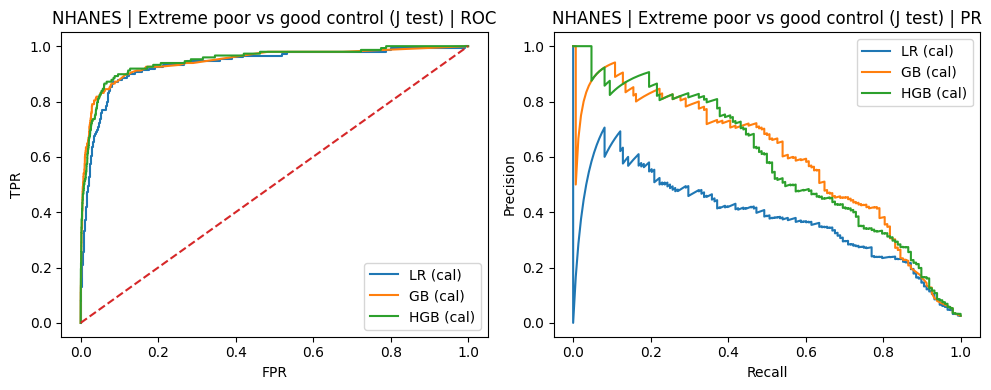

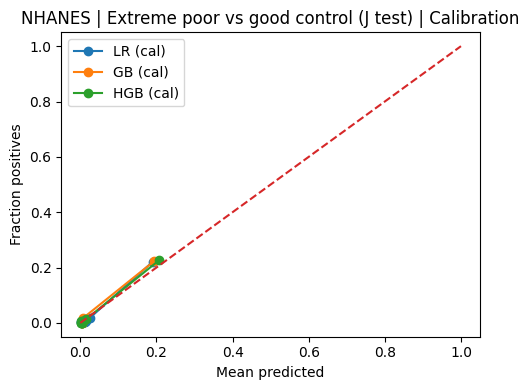

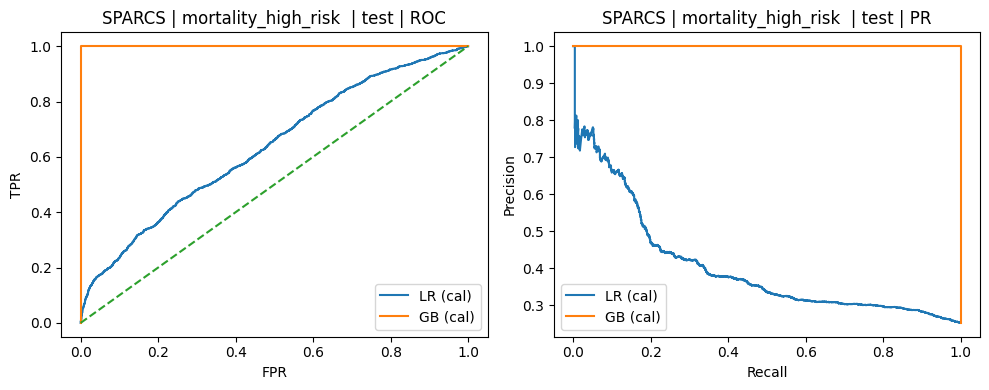

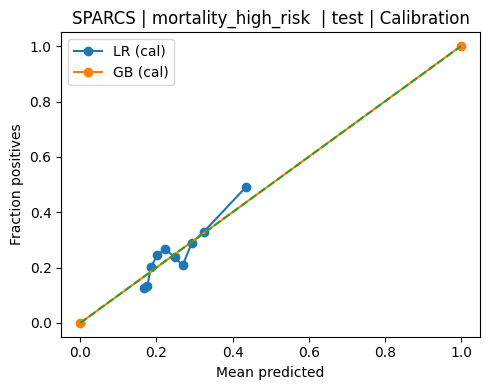

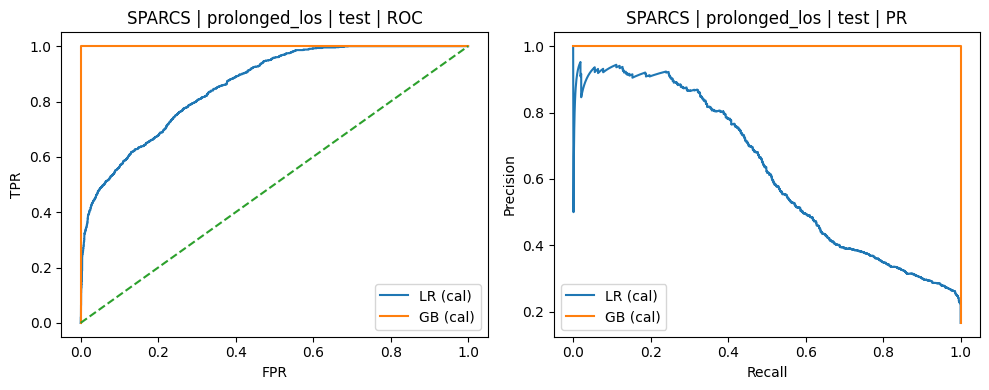

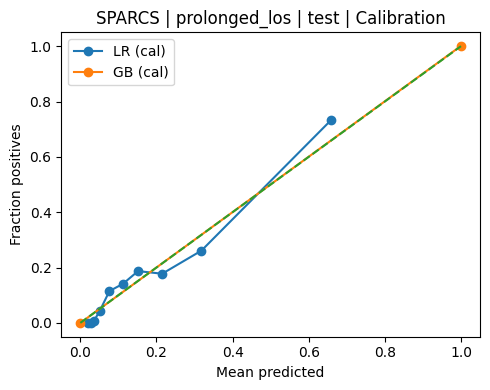

Saved figures to: outputs/figures


In [66]:
# =============================================================
# Figures: ROC/PR + calibration
# =============================================================

# NHANES curves
plot_curves(
    y_test,
    {"LR (cal)": p_test_lr, "GB (cal)": p_test_gb, "HGB (cal)": p_test_hgb},
    title="NHANES | Extreme poor vs good control (J test)",
    save_path=os.path.join(FIG_DIR, "nhanes_curves.png")
)
plot_calibration(
    y_test,
    {"LR (cal)": p_test_lr, "GB (cal)": p_test_gb, "HGB (cal)": p_test_hgb},
    title="NHANES | Extreme poor vs good control (J test)",
    save_path=os.path.join(FIG_DIR, "nhanes_calibration.png")
)

# SPARCS mortality (NO-LEAK)
plot_curves(
    sparcs_mort["splits"]["y_test"],
    {"LR (cal)": sparcs_mort["preds"]["p_test_lr"], "GB (cal)": sparcs_mort["preds"]["p_test_gb"]},
    title="SPARCS | mortality_high_risk  | test",
    save_path=os.path.join(FIG_DIR, "sparcs_mort_curves.png")
)
plot_calibration(
    sparcs_mort["splits"]["y_test"],
    {"LR (cal)": sparcs_mort["preds"]["p_test_lr"], "GB (cal)": sparcs_mort["preds"]["p_test_gb"]},
    title="SPARCS | mortality_high_risk  | test",
    save_path=os.path.join(FIG_DIR, "sparcs_mort_calibration.png")
)

# SPARCS LOS
plot_curves(
    sparcs_los["splits"]["y_test"],
    {"LR (cal)": sparcs_los["preds"]["p_test_lr"], "GB (cal)": sparcs_los["preds"]["p_test_gb"]},
    title="SPARCS | prolonged_los | test",
    save_path=os.path.join(FIG_DIR, "sparcs_los_curves.png")
)
plot_calibration(
    sparcs_los["splits"]["y_test"],
    {"LR (cal)": sparcs_los["preds"]["p_test_lr"], "GB (cal)": sparcs_los["preds"]["p_test_gb"]},
    title="SPARCS | prolonged_los | test",
    save_path=os.path.join(FIG_DIR, "sparcs_los_calibration.png")
)

print("Saved figures to:", FIG_DIR)


[SHAP] Using HGB pipeline from: extracted from cal_hgb_nh


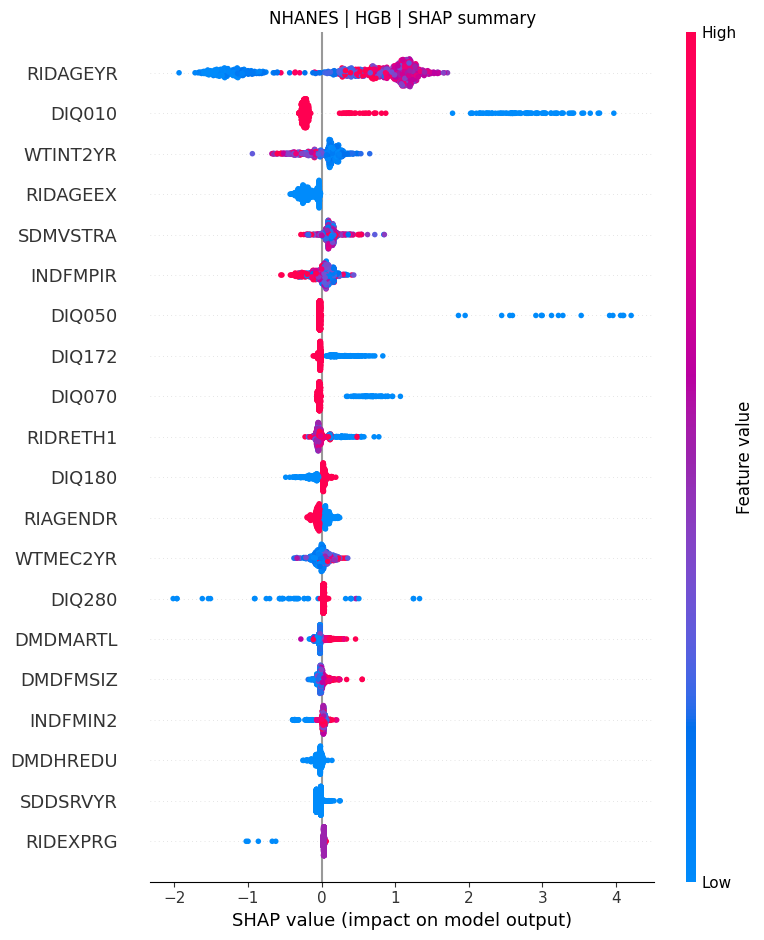

[SHAP] Saved: outputs/figures/shap_summary_nhanes_hgb.png


In [67]:
# =============================================================
#SHAP: tree model summaries (robust) — FIX additivity check failure
# =============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SHAP
try:
    import shap
except Exception:
    !pip -q install shap
    import shap

FIG_DIR = globals().get("FIG_DIR", "outputs/figures")
os.makedirs(FIG_DIR, exist_ok=True)

def _get_prefit_estimator_from_calibrator(cal):
    if cal is None:
        return None
    if hasattr(cal, "estimator") and cal.estimator is not None:
        return cal.estimator
    if hasattr(cal, "base_estimator") and cal.base_estimator is not None:
        return cal.base_estimator
    if hasattr(cal, "calibrated_classifiers_") and cal.calibrated_classifiers_:
        cc0 = cal.calibrated_classifiers_[0]
        if hasattr(cc0, "estimator") and cc0.estimator is not None:
            return cc0.estimator
    return None

def _resolve_best_hgb_pipe():
    if "best_hgb_pipe" in globals() and globals()["best_hgb_pipe"] is not None:
        return globals()["best_hgb_pipe"], "globals['best_hgb_pipe']"

    base = _get_prefit_estimator_from_calibrator(globals().get("cal_hgb_nh", None))
    if base is not None:
        return base, "extracted from cal_hgb_nh"

    if "hgb_pipe" in globals() and globals()["hgb_pipe"] is not None:
        return globals()["hgb_pipe"], "globals['hgb_pipe']"

    for k in ["pipe_hgb", "nh_hgb_pipe", "best_pipe_hgb"]:
        if k in globals() and globals()[k] is not None:
            return globals()[k], f"globals['{k}']"

    return None, "NOT_FOUND"

def _ensure_fitted(pipe, X, y):
    try:
        _ = pipe.predict_proba(X.iloc[:5] if hasattr(X, "iloc") else X[:5])
        return pipe, False
    except Exception:
        pipe.fit(X, y)
        return pipe, True

def shap_tree_summary(pipe, X_bg, y_bg, X_eval, title, out_png,
                      max_display=20, n_bg=400, n_eval=800, seed=42):
    rng = np.random.default_rng(seed)

    # sample for speed
    if len(X_bg) > n_bg:
        bg_idx = rng.choice(np.arange(len(X_bg)), size=n_bg, replace=False)
        X_bg_s = X_bg.iloc[bg_idx] if hasattr(X_bg, "iloc") else X_bg[bg_idx]
    else:
        X_bg_s = X_bg

    if len(X_eval) > n_eval:
        ev_idx = rng.choice(np.arange(len(X_eval)), size=n_eval, replace=False)
        X_ev_s = X_eval.iloc[ev_idx] if hasattr(X_eval, "iloc") else X_eval[ev_idx]
    else:
        X_ev_s = X_eval

    feature_names = list(X_bg.columns) if hasattr(X_bg, "columns") else [f"x{i}" for i in range(X_bg.shape[1])]

    # Split pipeline
    if hasattr(pipe, "named_steps"):
        imp = pipe.named_steps.get("imp", None)
        clf = pipe.named_steps.get("clf", None)
        if clf is None:
            raise ValueError("Pipeline has no step named 'clf'.")

        if imp is not None:
            Xbg_t = imp.transform(X_bg_s)
            Xev_t = imp.transform(X_ev_s)
        else:
            Xbg_t = X_bg_s.values if hasattr(X_bg_s, "values") else X_bg_s
            Xev_t = X_ev_s.values if hasattr(X_ev_s, "values") else X_ev_s

        model_for_shap = clf
    else:
        Xbg_t = X_bg_s.values if hasattr(X_bg_s, "values") else X_bg_s
        Xev_t = X_ev_s.values if hasattr(X_ev_s, "values") else X_ev_s
        model_for_shap = pipe

    # ---- SHAP Explainer with additivity check disabled ----
    try:
        explainer = shap.TreeExplainer(
            model_for_shap,
            data=Xbg_t,
            model_output="raw"  # log-odds / margin
        )
        shap_vals = explainer(Xev_t, check_additivity=False)
        vals = shap_vals.values
        if vals.ndim == 3 and vals.shape[-1] == 2:
            vals = vals[:, :, 1]
        shap_plot_vals = vals

    except Exception as e_tree:
        print(f"[SHAP] TreeExplainer failed ({type(e_tree).__name__}). Falling back to shap.Explainer ...")
        # This fallback is often more stable for sklearn HGB
        explainer = shap.Explainer(model_for_shap, Xbg_t)
        shap_vals = explainer(Xev_t)
        vals = shap_vals.values
        if vals.ndim == 3 and vals.shape[-1] == 2:
            vals = vals[:, :, 1]
        shap_plot_vals = vals

    # Plot
    plt.figure()
    shap.summary_plot(
        shap_plot_vals,
        Xev_t,
        feature_names=feature_names,
        show=False,
        max_display=max_display
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()

    print(f"[SHAP] Saved: {out_png}")

# -----------------------------
# Resolve NHANES objects and run SHAP
# -----------------------------
if "X_train_nh" not in globals() or "y_train_nh" not in globals() or "X_test_nh" not in globals():
    raise NameError("Missing NHANES splits (X_train_nh/y_train_nh/X_test_nh). Run Cell 2 first.")

X_train_hgb = globals()["X_train_nh"]
y_train_hgb = np.asarray(globals()["y_train_nh"]).astype(int)
X_test_hgb  = globals()["X_test_nh"]

best_hgb_pipe, src = _resolve_best_hgb_pipe()
if best_hgb_pipe is None:
    raise NameError(
        "Cannot resolve best_hgb_pipe. Expected one of: best_hgb_pipe, cal_hgb_nh (prefit), hgb_pipe."
    )

print(f"[SHAP] Using HGB pipeline from: {src}")

best_hgb_pipe, did_fit = _ensure_fitted(best_hgb_pipe, X_train_hgb, y_train_hgb)
if did_fit:
    print("[SHAP] NOTE: base HGB pipeline was not fitted, fitted now on NHANES TRAIN.")

out_png = os.path.join(FIG_DIR, "shap_summary_nhanes_hgb.png")
shap_tree_summary(
    best_hgb_pipe,
    X_train_hgb, y_train_hgb,
    X_test_hgb,
    title="NHANES | HGB | SHAP summary",
    out_png=out_png,
    max_display=20,
    n_bg=400,
    n_eval=800,
    seed=42
)


In [68]:
# =============================================================
# NHANES FIX : enforce T2D-treated cohort + 3-way temporal split
# TRAIN = all cycles except last two, VAL = penultimate, TEST = last (default J)
# =============================================================

import numpy as np
import pandas as pd

# --- inputs expected ---
assert "df_nh" in globals() and isinstance(df_nh, pd.DataFrame), "df_nh not found. Run NHANES build cell first."
df = df_nh.copy()

# --- standardise cycle ---
assert "cycle" in df.columns, "df_nh must contain 'cycle' column."
df["cycle"] = df["cycle"].astype(str).str.strip().str.upper()

# --- core columns ---
def _need(col):
    if col not in df.columns:
        raise RuntimeError(f"NHANES missing required column: {col}")

_need("RIDAGEYR")   # age
_need("DIQ010")     # told diabetes
# treatment flags may be missing in some builds, we try common ones
treat_cols = [c for c in ["DIQ050", "DIQ070"] if c in df.columns]
if len(treat_cols) == 0:
    raise RuntimeError("NHANES missing treatment flags (expected DIQ050 and/or DIQ070).")

# --- HbA1c ---
_need("LBXGH")

# =============================================================
# 1) Define T2D-treated adult cohort (consistent across cycles)
# =============================================================
df["RIDAGEYR"] = pd.to_numeric(df["RIDAGEYR"], errors="coerce")
df["DIQ010"]   = pd.to_numeric(df["DIQ010"], errors="coerce")

for c in treat_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

adult = df["RIDAGEYR"] >= 18
dx_dm = df["DIQ010"] == 1

# treated: insulin or pills, if both available use OR
treated = np.zeros(len(df), dtype=bool)
for c in treat_cols:
    treated |= (df[c] == 1)

df0 = df.loc[adult & dx_dm & treated].copy()

print(f"[NHANES COHORT] Adults & dx diabetes & treated: n={len(df0)} out of n={len(df)}")
print("[NHANES COHORT] counts by cycle (before outcome filter):")
display(df0["cycle"].value_counts().sort_index())

# =============================================================
# 2) Define outcome: extreme poor vs good control, drop intermediate
# =============================================================
df0["LBXGH"] = pd.to_numeric(df0["LBXGH"], errors="coerce")

good = df0["LBXGH"] < 7.0
poor = df0["LBXGH"] >= 9.0

df0 = df0.loc[good | poor].copy()
df0["very_poor_vs_good"] = np.where(poor, 1, 0).astype(int)

print("[NHANES OUTCOME] counts by cycle AFTER outcome filter:")
display(df0["cycle"].value_counts().sort_index())
print(f"[NHANES OUTCOME] prevalence overall={df0['very_poor_vs_good'].mean():.3f}")

# =============================================================
# 3) Drop obvious non-T2D, survey design, and target definers from feature space
# =============================================================
TARGET = "very_poor_vs_good"

drop_hard = {
    "LBXGH", "good_control", "very_poor", TARGET,
    "SEQN", "cycle"
}

# survey design or timing proxies, drop if present
survey_like = [
    "SDDSRVYR","RIDSTATR","RIDEXMON",
    "SDMVPSU","SDMVSTRA",
    "WTMEC2YR","WTINT2YR","WTMEC4YR","WTINT4YR"
]
drop_hard |= set([c for c in survey_like if c in df0.columns])

# build feature matrix, numeric only (consistent with your current pipeline)
feature_cols = [c for c in df0.columns if c not in drop_hard]

X_all = df0[feature_cols].copy()
y_all = df0[TARGET].astype(int).copy()

# keep numeric only
non_num = [c for c in X_all.columns if not pd.api.types.is_numeric_dtype(X_all[c])]
if non_num:
    X_all = X_all.drop(columns=non_num)

print(f"[NHANES FEATURES] numeric features n={X_all.shape[1]} | example={list(X_all.columns[:12])}")

# =============================================================
# 4) Temporal split: TRAIN, VAL, TEST by cycle
# default: TEST=J, VAL=I, TRAIN=all earlier cycles present
# =============================================================
cycles_present = sorted(df0["cycle"].unique().tolist(), key=lambda c: "ABCDEFGHIJ".find(c) if c in "ABCDEFGHIJ" else 999)

NHANES_TEST_CYCLE = str(globals().get("NHANES_TEST_CYCLE", "J")).strip().upper()
if NHANES_TEST_CYCLE not in cycles_present:
    NHANES_TEST_CYCLE = cycles_present[-1]

# pick VAL as penultimate cycle (unless explicitly set)
NHANES_VAL_CYCLE = str(globals().get("NHANES_VAL_CYCLE", "")).strip().upper()
if NHANES_VAL_CYCLE == "" or NHANES_VAL_CYCLE not in cycles_present or NHANES_VAL_CYCLE == NHANES_TEST_CYCLE:
    # penultimate
    penult = [c for c in cycles_present if c != NHANES_TEST_CYCLE]
    NHANES_VAL_CYCLE = penult[-1]

NHANES_TRAIN_CYCLES = [c for c in cycles_present if c not in [NHANES_VAL_CYCLE, NHANES_TEST_CYCLE]]

train_mask = df0["cycle"].isin(NHANES_TRAIN_CYCLES).values
val_mask   = (df0["cycle"].values == NHANES_VAL_CYCLE)
test_mask  = (df0["cycle"].values == NHANES_TEST_CYCLE)

X_train_nh = X_all.loc[train_mask].copy()
y_train_nh = y_all.loc[train_mask].copy()
X_val_nh   = X_all.loc[val_mask].copy()
y_val_nh   = y_all.loc[val_mask].copy()
X_test_nh  = X_all.loc[test_mask].copy()
y_test_nh  = y_all.loc[test_mask].copy()

print(f"[NHANES SPLIT] TRAIN={NHANES_TRAIN_CYCLES} n={len(y_train_nh)} prev={y_train_nh.mean():.3f}")
print(f"[NHANES SPLIT] VAL={NHANES_VAL_CYCLE} n={len(y_val_nh)} prev={y_val_nh.mean():.3f}")
print(f"[NHANES SPLIT] TEST={NHANES_TEST_CYCLE} n={len(y_test_nh)} prev={y_test_nh.mean():.3f}")

# export globals for downstream cells (Table 3, Table 4, SHAP, ablation)
globals().update({
    "df_nh_t2d": df0,
    "NHANES_TRAIN_CYCLES": NHANES_TRAIN_CYCLES,
    "NHANES_VAL_CYCLE": NHANES_VAL_CYCLE,
    "NHANES_TEST_CYCLE": NHANES_TEST_CYCLE,
    "X_train_nh": X_train_nh, "y_train_nh": y_train_nh,
    "X_val_nh": X_val_nh,     "y_val_nh": y_val_nh,
    "X_test_nh": X_test_nh,   "y_test_nh": y_test_nh,
    "NHANES_FEATURE_COLS": list(X_all.columns),
})


[NHANES COHORT] Adults & dx diabetes & treated: n=2736 out of n=62379
[NHANES COHORT] counts by cycle (before outcome filter):


cycle
A    196
B    233
C    258
D     76
E     94
F    377
G    359
H    352
I    366
J    425
Name: count, dtype: int64

[NHANES OUTCOME] counts by cycle AFTER outcome filter:


cycle
A    196
B    233
C    258
D     76
E     94
F    377
G    359
H    352
I    366
J    425
Name: count, dtype: int64

[NHANES OUTCOME] prevalence overall=0.299
[NHANES FEATURES] numeric features n=243 | example=['RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDAGEEX', 'RIDRETH1', 'RIDRETH2', 'DMQMILIT', 'DMDBORN', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2']
[NHANES SPLIT] TRAIN=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'] n=1945 prev=0.300
[NHANES SPLIT] VAL=I n=366 prev=0.325
[NHANES SPLIT] TEST=J n=425 prev=0.271


In [69]:
# =============================================================
# NHANES TRAIN/EVAL (ROBUST): LR balanced + HGB, calibrated on VAL, threshold on VAL
# Produces: cal_lr_nh, cal_hgb_nh, thr_lr_nh, thr_hgb_nh, p_test_lr, p_test_hgb
# =============================================================

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve

assert "X_train_nh" in globals() and "X_val_nh" in globals() and "X_test_nh" in globals(), "Run NHANES split cell first."
X_tr, y_tr = X_train_nh, np.asarray(y_train_nh).astype(int)
X_va, y_va = X_val_nh,   np.asarray(y_val_nh).astype(int)
X_te, y_te = X_test_nh,  np.asarray(y_test_nh).astype(int)

# --- simple numeric preprocessor, stable for NHANES numeric matrix ---
pre = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

def _pick_thr_max_f1(y, p):
    pr, rc, thr = precision_recall_curve(y, p)
    f1 = (2 * pr * rc) / (pr + rc + 1e-12)
    # thr has length n-1
    j = int(np.nanargmax(f1[:-1])) if len(f1) > 1 else 0
    return float(thr[j]) if len(thr) > 0 else 0.5

# --- models ---
lr = LogisticRegression(
    max_iter=4000, solver="lbfgs", class_weight="balanced",
    n_jobs=1, random_state=42
)

hgb = HistGradientBoostingClassifier(
    max_depth=3, learning_rate=0.05, max_iter=400,
    random_state=42
)

pipe_lr  = Pipeline([("pre", pre), ("clf", lr)])
pipe_hgb = Pipeline([("pre", pre), ("clf", hgb)])

# fit on TRAIN
pipe_lr.fit(X_tr, y_tr)
pipe_hgb.fit(X_tr, y_tr)

# calibrate on VAL
cal_lr_nh  = CalibratedClassifierCV(pipe_lr,  method="sigmoid", cv="prefit")
cal_hgb_nh = CalibratedClassifierCV(pipe_hgb, method="sigmoid", cv="prefit")
cal_lr_nh.fit(X_va, y_va)
cal_hgb_nh.fit(X_va, y_va)

# pick threshold on VAL
p_val_lr  = cal_lr_nh.predict_proba(X_va)[:, 1]
p_val_hgb = cal_hgb_nh.predict_proba(X_va)[:, 1]
thr_lr_nh  = _pick_thr_max_f1(y_va, p_val_lr)
thr_hgb_nh = _pick_thr_max_f1(y_va, p_val_hgb)

# test probabilities
p_test_lr  = cal_lr_nh.predict_proba(X_te)[:, 1]
p_test_hgb = cal_hgb_nh.predict_proba(X_te)[:, 1]

# quick diagnostics
def _report(name, y, p, thr):
    roc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan
    pr  = average_precision_score(y, p) if len(np.unique(y)) > 1 else np.nan
    f1  = f1_score(y, (p >= thr).astype(int), zero_division=0)
    print(f"[NHANES TEST] {name}: ROC={roc:.3f} | PR={pr:.3f} | thr={thr:.3f} | F1={f1:.3f}")

_report("LR balanced (cal)",  y_te, p_test_lr,  thr_lr_nh)
_report("HGB (cal)",          y_te, p_test_hgb, thr_hgb_nh)

# export for Table 3 and Table 4 cells
globals().update({
    "cal_lr_nh": cal_lr_nh,
    "cal_hgb_nh": cal_hgb_nh,
    "thr_lr_nh": thr_lr_nh,
    "thr_hgb_nh": thr_hgb_nh,
    "p_test_lr": p_test_lr,
    "p_test_hgb": p_test_hgb,
})


[NHANES TEST] LR balanced (cal): ROC=0.768 | PR=0.511 | thr=0.252 | F1=0.563
[NHANES TEST] HGB (cal): ROC=0.817 | PR=0.668 | thr=0.350 | F1=0.574


In [70]:
# =============================================================
# SPARCS RECOVERY (DISK-FIRST) + Table 3 merge (NHANES updated + SPARCS)
# 1) Try to reload SPARCS artifacts from disk (joblib/pkl)
# 2) If not found, fall back to previous saved Table 3 CSV for SPARCS rows
# 3) Always keep NHANES rows from the NEW run (cal_lr_nh/cal_hgb_nh etc.)
# =============================================================

import os, re, glob, pickle
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

B_CI = 1000
RNG_SEED = 42

# -----------------------------
# Bootstrap + formatting
# -----------------------------
def _bootstrap_ci_metric(y_true, y_prob, thr, metric_fn, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    n = len(y_true)
    if n == 0:
        return np.nan, (np.nan, np.nan)
    idx = np.arange(n)
    vals = []
    for _ in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        yt = y_true[bs]
        yp = y_prob[bs]
        try:
            vals.append(metric_fn(yt, yp, thr))
        except Exception:
            vals.append(np.nan)
    vals = np.asarray(vals, dtype=float)
    return float(np.nanmean(vals)), (float(np.nanpercentile(vals, 2.5)), float(np.nanpercentile(vals, 97.5)))

def _fmt_ci(mean, ci, digits=3):
    if mean is None or np.isnan(mean):
        return "NA"
    lo, hi = ci
    if np.isnan(lo) or np.isnan(hi):
        return f"{mean:.{digits}f}"
    return f"{mean:.{digits}f} [{lo:.{digits}f}, {hi:.{digits}f}]"

def table3_row(dataset, outcome, model_name, thr, y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    thr = float(thr)

    def _roc(yt, yp, t): return roc_auc_score(yt, yp) if len(np.unique(yt)) > 1 else np.nan
    def _pr(yt, yp, t):  return average_precision_score(yt, yp) if len(np.unique(yt)) > 1 else np.nan
    def _brier(yt, yp, t): return brier_score_loss(yt, yp)
    def _acc(yt, yp, t): return accuracy_score(yt, (yp >= t).astype(int))
    def _prec(yt, yp, t): return precision_score(yt, (yp >= t).astype(int), zero_division=0)
    def _rec(yt, yp, t): return recall_score(yt, (yp >= t).astype(int), zero_division=0)
    def _f1(yt, yp, t): return f1_score(yt, (yp >= t).astype(int), zero_division=0)

    roc_m, roc_ci = _bootstrap_ci_metric(y_true, y_prob, thr, _roc,   B=B_CI, seed=RNG_SEED)
    pr_m,  pr_ci  = _bootstrap_ci_metric(y_true, y_prob, thr, _pr,    B=B_CI, seed=RNG_SEED)
    br_m,  br_ci  = _bootstrap_ci_metric(y_true, y_prob, thr, _brier, B=B_CI, seed=RNG_SEED)
    ac_m,  ac_ci  = _bootstrap_ci_metric(y_true, y_prob, thr, _acc,   B=B_CI, seed=RNG_SEED)
    pc_m,  pc_ci  = _bootstrap_ci_metric(y_true, y_prob, thr, _prec,  B=B_CI, seed=RNG_SEED)
    rc_m,  rc_ci  = _bootstrap_ci_metric(y_true, y_prob, thr, _rec,   B=B_CI, seed=RNG_SEED)
    f1_m,  f1_ci  = _bootstrap_ci_metric(y_true, y_prob, thr, _f1,    B=B_CI, seed=RNG_SEED)

    return {
        "Dataset": dataset,
        "Outcome": outcome,
        "Model": model_name,
        "Threshold": thr,
        "ROC AUC (95% CI)": _fmt_ci(roc_m, roc_ci),
        "PR AUC (95% CI)":  _fmt_ci(pr_m,  pr_ci),
        "Brier (95% CI)":   _fmt_ci(br_m,  br_ci),
        "Accuracy (95% CI)": _fmt_ci(ac_m, ac_ci),
        "Precision (95% CI)": _fmt_ci(pc_m, pc_ci),
        "Recall (95% CI)": _fmt_ci(rc_m, rc_ci),
        "F1 (95% CI)": _fmt_ci(f1_m, f1_ci),
    }

# -----------------------------
# 0) NHANES rows (must exist)
# -----------------------------
assert "X_test_nh" in globals() and "y_test_nh" in globals(), "Missing X_test_nh/y_test_nh."
assert "cal_lr_nh" in globals() and "cal_hgb_nh" in globals(), "Missing cal_lr_nh/cal_hgb_nh."
assert "thr_lr_nh" in globals() and "thr_hgb_nh" in globals(), "Missing thr_lr_nh/thr_hgb_nh."

rows = []
X_te_nh = X_test_nh
y_te_nh = np.asarray(y_test_nh).astype(int)

p_lr  = cal_lr_nh.predict_proba(X_te_nh)[:, 1]
p_hgb = cal_hgb_nh.predict_proba(X_te_nh)[:, 1]

rows.append(table3_row("NHANES", "Extreme poor vs good control (T2D-treated, temporal TEST)",
                       "LR balanced (calibrated)", thr_lr_nh, y_te_nh, p_lr))
rows.append(table3_row("NHANES", "Extreme poor vs good control (T2D-treated, temporal TEST)",
                       "HGB (calibrated)", thr_hgb_nh, y_te_nh, p_hgb))

# -----------------------------
# 1) Try to load SPARCS artifacts from disk (joblib/pkl)
# -----------------------------
def _try_load(path):
    try:
        import joblib
        return joblib.load(path)
    except Exception:
        try:
            with open(path, "rb") as f:
                return pickle.load(f)
        except Exception:
            return None

def _find_candidates(patterns, roots):
    hits = []
    for root in roots:
        for pat in patterns:
            hits.extend(glob.glob(os.path.join(root, "**", pat), recursive=True))
    # keep unique, sort by mtime desc
    hits = sorted(list(set(hits)), key=lambda p: os.path.getmtime(p), reverse=True)
    return hits

roots = ["./", "/content", "./outputs", "/content/drive"]
pats = ["*sparcs*mort*.joblib", "*sparcs*mort*.pkl", "*sparcs*los*.joblib", "*sparcs*los*.pkl",
        "*sparcs_paper_mort*.joblib", "*sparcs_paper_los*.joblib",
        "*mort*artifact*.joblib", "*los*artifact*.joblib"]

cand = _find_candidates(pats, roots)
loaded_any = False

# Heuristic: pick up to 6 most recent and see if they look like artifacts
sparcs_artifacts = []
for fp in cand[:12]:
    obj = _try_load(fp)
    if isinstance(obj, dict) and ("cal" in obj or "preds" in obj or "X_test" in obj or "splits" in obj):
        sparcs_artifacts.append((fp, obj))

print(f"[SPARCS RECOVERY] candidates found={len(cand)} | usable_artifacts={len(sparcs_artifacts)}")
if sparcs_artifacts:
    print("[SPARCS RECOVERY] using most recent artifacts:")
    for fp, _ in sparcs_artifacts[:4]:
        print(" -", fp)

def _extract_xy(art):
    X = art.get("X_test", art.get("X_te", None))
    y = art.get("y_test", art.get("y_te", None))
    if X is not None and y is not None:
        return X, np.asarray(y).astype(int)
    splits = art.get("splits", None)
    if isinstance(splits, (tuple, list)) and len(splits) >= 6:
        return splits[2], np.asarray(splits[5]).astype(int)
    return None, None

def _add_sparcs_from_art(art, outcome_label):
    X, y = _extract_xy(art)

    # prefer stored probs if exist
    preds = art.get("preds", {})
    thr = art.get("thr", {}) if isinstance(art.get("thr", {}), dict) else {}
    if isinstance(preds, dict) and y is not None:
        name_map = {"lr":"Logistic (calibrated)", "gb":"GB (calibrated)", "hgb":"HGB (calibrated)"}
        for key in ["lr","gb","hgb"]:
            p = preds.get(f"p_test_{key}", None)
            if p is not None:
                rows.append(table3_row("SPARCS", outcome_label, name_map[key], float(thr.get(key, 0.5)), y, np.asarray(p).astype(float)))
        if any(preds.get(f"p_test_{k}", None) is not None for k in ["lr","gb","hgb"]):
            return True

    # else compute from cal if possible
    cal = art.get("cal", {})
    if X is None or y is None or not isinstance(cal, dict) or len(cal) == 0:
        return False

    name_map = {"lr":"Logistic (calibrated)", "gb":"GB (calibrated)", "hgb":"HGB (calibrated)"}
    ok = False
    for key in ["lr","gb","hgb"]:
        if key in cal and cal[key] is not None:
            try:
                p = cal[key].predict_proba(X)[:, 1]
                rows.append(table3_row("SPARCS", outcome_label, name_map[key], float(thr.get(key, 0.5)), y, p))
                ok = True
            except Exception:
                pass
    return ok

sparcs_done = {"mortality_high_risk": False, "prolonged_los": False}

# try to classify artifacts by filename first
for fp, art in sparcs_artifacts:
    low = fp.lower()
    if (("mort" in low) or ("mortality" in low)) and not sparcs_done["mortality_high_risk"]:
        sparcs_done["mortality_high_risk"] = _add_sparcs_from_art(art, "mortality_high_risk")
    if (("los" in low) or ("length" in low)) and not sparcs_done["prolonged_los"]:
        sparcs_done["prolonged_los"] = _add_sparcs_from_art(art, "prolonged_los")

# fallback: just try artifacts in order
if not sparcs_done["mortality_high_risk"]:
    for _, art in sparcs_artifacts:
        if _add_sparcs_from_art(art, "mortality_high_risk"):
            sparcs_done["mortality_high_risk"] = True
            break

if not sparcs_done["prolonged_los"]:
    for _, art in sparcs_artifacts:
        if _add_sparcs_from_art(art, "prolonged_los"):
            sparcs_done["prolonged_los"] = True
            break

print("[SPARCS RECOVERY] status:", sparcs_done)

# -----------------------------
# 2) If still missing, fall back to previous Table 3 CSV for SPARCS rows
# -----------------------------
if (not sparcs_done["mortality_high_risk"]) or (not sparcs_done["prolonged_los"]):
    fallback_paths = [
        "outputs/tables/table3_main_test_metrics.csv",
        "outputs/tables/table3_main_test_metrics_UPDATED.csv",
        "outputs/tables/table3_main_test_metrics_UPDATED_v2.csv",
    ]
    fb = None
    for p in fallback_paths:
        if os.path.exists(p):
            try:
                fb = pd.read_csv(p)
                break
            except Exception:
                pass

    if fb is not None and "Dataset" in fb.columns:
        sp = fb[fb["Dataset"].astype(str).str.upper().eq("SPARCS")].copy()
        if len(sp) > 0:
            print(f"[SPARCS FALLBACK] Using SPARCS rows from: {p} (n={len(sp)})")
            # keep same columns as our rows
            # if columns differ, attempt map
            want_cols = ["Dataset","Outcome","Model","Threshold","ROC AUC (95% CI)","PR AUC (95% CI)",
                         "Brier (95% CI)","Accuracy (95% CI)","Precision (95% CI)","Recall (95% CI)","F1 (95% CI)"]

            # if the csv uses different header names, adjust here
            # (common older: ROC AUC (95% CI) already exists, so usually ok)
            missing_cols = [c for c in want_cols if c not in sp.columns]
            if missing_cols:
                print("[SPARCS FALLBACK] WARNING: SPARCS table columns missing:", missing_cols)
            else:
                rows.extend(sp[want_cols].to_dict("records"))
        else:
            print("[SPARCS FALLBACK] No SPARCS rows found in fallback Table 3 CSV.")
    else:
        print("[SPARCS FALLBACK] No usable Table 3 CSV found under outputs/tables/. You must re-run SPARCS training cells once.")

# -----------------------------
# Final Table 3
# -----------------------------
table3_final_updated = pd.DataFrame(rows).sort_values(["Dataset","Outcome","Model"]).reset_index(drop=True)
print(f"\nTable 3 (FINAL UPDATED). Main test metrics with bootstrap 95% CIs (B={B_CI})\n")
display(table3_final_updated)

os.makedirs("outputs/tables", exist_ok=True)
table3_final_updated.to_csv("outputs/tables/table3_main_test_metrics_FINAL_UPDATED.csv", index=False)
print("Saved: outputs/tables/table3_main_test_metrics_FINAL_UPDATED.csv")

# export for paper pipeline
table3_final = table3_final_updated


[SPARCS RECOVERY] candidates found=0 | usable_artifacts=0
[SPARCS RECOVERY] status: {'mortality_high_risk': False, 'prolonged_los': False}
[SPARCS FALLBACK] Using SPARCS rows from: outputs/tables/table3_main_test_metrics.csv (n=4)

Table 3 (FINAL UPDATED). Main test metrics with bootstrap 95% CIs (B=1000)



Dataset                                            Outcome  \
0  NHANES  Extreme poor vs good control (T2D-treated, tem...   
1  NHANES  Extreme poor vs good control (T2D-treated, tem...   
2  SPARCS                                mortality_high_risk   
3  SPARCS                                mortality_high_risk   
4  SPARCS                                      prolonged_los   
5  SPARCS                                      prolonged_los   

                      Model  Threshold      ROC AUC (95% CI)  \
0          HGB (calibrated)   0.350384  0.817 [0.772, 0.860]   
1  LR balanced (calibrated)   0.252041  0.767 [0.716, 0.812]   
2           GB (calibrated)   0.050000  1.000 [1.000, 1.000]   
3     Logistic (calibrated)   0.200000  0.635 [0.620, 0.650]   
4           GB (calibrated)   0.050000  1.000 [1.000, 1.000]   
5     Logistic (calibrated)   0.350000  0.857 [0.845, 0.868]   

        PR AUC (95% CI)        Brier (95% CI)     Accuracy (95% CI)  \
0  0.671 [0.582, 0.748]  0.144 [0.123, 0.166]  0.763 [0.720, 0.802]   
1  0.519 [0.427, 0.615]  0.168 [0.149, 0.187]  0.649 [0.605, 0.692]   
2  1.000 [1.000, 1.000]  0.000 [0.000, 0.000]  1.000 [1.000, 1.000]   
3  0.404 [0.379, 0.427]  0.179 [0.173, 0.184]  0.483 [0.472, 0.496]   
4  1.000 [1.000, 1.000]  0.000 [0.000, 0.000]  1.000 [1.000, 1.000]   
5  0.624 [0.593, 0.654]  0.095 [0.090, 0.100]  0.871 [0.863, 0.879]   

     Precision (95% CI)       Recall (95% CI)           F1 (95% CI)  
0  0.559 [0.466, 0.645]  0.591 [0.496, 0.673]  0.574 [0.493, 0.644]  
1  0.424 [0.361, 0.487]  0.834 [0.766, 0.897]  0.562 [0.494, 0.622]  
2  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  
3  0.300 [0.286, 0.314]  0.782 [0.761, 0.800]  0.433 [0.417, 0.449]  
4  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  1.000 [1.000, 1.000]  
5  0.650 [0.613, 0.683]  0.489 [0.460, 0.517]  0.558 [0.528, 0.584]

Saved: outputs/tables/table3_main_test_metrics_FINAL_UPDATED.csv


In [71]:
# =============================================================
# Table 4 (FINAL UPDATED) — FIXED: subgroup metrics + SPARCS recovery (no empty concat)
# =============================================================

import os, glob, pickle
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score

B_CI = 1000
RNG_SEED = 42

# -----------------------------
# Bootstrap + formatting
# -----------------------------
def _boot_ci(y, p, thr, fn, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    n = len(y)
    if n == 0:
        return np.nan, (np.nan, np.nan)
    idx = np.arange(n)
    vals = []
    for _ in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        try:
            vals.append(fn(y[bs], p[bs], thr))
        except Exception:
            vals.append(np.nan)
    vals = np.asarray(vals, float)
    return float(np.nanmean(vals)), (float(np.nanpercentile(vals, 2.5)), float(np.nanpercentile(vals, 97.5)))

def _fmt(mean, ci, d=3):
    if mean is None or np.isnan(mean):
        return "NA"
    lo, hi = ci
    if np.isnan(lo) or np.isnan(hi):
        return f"{mean:.{d}f}"
    return f"{mean:.{d}f} [{lo:.{d}f}, {hi:.{d}f}]"

def _subgroup_metrics(y, p, thr):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    def _roc(yy, pp, t): return roc_auc_score(yy, pp) if len(np.unique(yy)) > 1 else np.nan
    def _pr(yy, pp, t):  return average_precision_score(yy, pp) if len(np.unique(yy)) > 1 else np.nan
    def _rec(yy, pp, t): return recall_score(yy, (pp >= t).astype(int), zero_division=0)
    def _f1(yy, pp, t):  return f1_score(yy, (pp >= t).astype(int), zero_division=0)

    roc_m, roc_ci = _boot_ci(y, p, thr, _roc, B=B_CI, seed=RNG_SEED)
    pr_m,  pr_ci  = _boot_ci(y, p, thr, _pr,  B=B_CI, seed=RNG_SEED)
    rec_m, rec_ci = _boot_ci(y, p, thr, _rec, B=B_CI, seed=RNG_SEED)
    f1_m,  f1_ci  = _boot_ci(y, p, thr, _f1,  B=B_CI, seed=RNG_SEED)

    return {
        "ROC AUC (95% CI)": _fmt(roc_m, roc_ci),
        "PR AUC (95% CI)":  _fmt(pr_m,  pr_ci),
        "Recall (95% CI)":  _fmt(rec_m, rec_ci),
        "F1 (95% CI)":      _fmt(f1_m,  f1_ci),
    }

# -----------------------------
# NHANES subgroup builder (index aligned)
# -----------------------------
def build_table4_nhanes():
    assert "df_nh_t2d" in globals(), "df_nh_t2d missing. Run NHANES cohort/split cell."
    assert "X_test_nh" in globals() and "y_test_nh" in globals(), "X_test_nh/y_test_nh missing."
    assert "cal_hgb_nh" in globals() and "thr_hgb_nh" in globals(), "NHANES cal_hgb_nh/thr_hgb_nh missing."

    df_meta = df_nh_t2d.loc[X_test_nh.index].copy()

    # sex
    if "RIAGENDR" in df_meta.columns:
        sex_map = {1: "Male", 2: "Female"}
        df_meta["sex"] = pd.to_numeric(df_meta["RIAGENDR"], errors="coerce").map(sex_map)
    elif "sex" not in df_meta.columns:
        df_meta["sex"] = "Unknown"

    # race/eth
    if "RIDRETH3" in df_meta.columns:
        re_map = {
            1: "Mexican American", 2: "Other Hispanic", 3: "Non-Hispanic White",
            4: "Non-Hispanic Black", 6: "Non-Hispanic Asian", 7: "Other/Multiracial"
        }
        df_meta["race_eth"] = pd.to_numeric(df_meta["RIDRETH3"], errors="coerce").map(re_map)
    elif "race_eth" not in df_meta.columns:
        df_meta["race_eth"] = "Unknown"

    # age group
    if "RIDAGEYR" in df_meta.columns:
        age = pd.to_numeric(df_meta["RIDAGEYR"], errors="coerce")
        df_meta["age_group"] = pd.cut(age, bins=[18, 45, 65, 120], right=False, labels=["18–44","45–64","65+"])
    elif "age_group" not in df_meta.columns:
        df_meta["age_group"] = "Unknown"

    # BMI group
    if "BMXBMI" in df_meta.columns:
        bmi = pd.to_numeric(df_meta["BMXBMI"], errors="coerce")
        df_meta["bmi_group"] = pd.cut(bmi, bins=[0, 25, 30, 1000], right=False, labels=["<25","25–29.9","30+"])
    elif "bmi_group" not in df_meta.columns:
        df_meta["bmi_group"] = "Unknown"

    p = pd.Series(cal_hgb_nh.predict_proba(X_test_nh)[:, 1], index=X_test_nh.index, name="p")
    y = pd.Series(np.asarray(y_test_nh).astype(int), index=X_test_nh.index, name="y")
    thr = float(thr_hgb_nh)

    rows = []
    for field in ["sex", "race_eth", "age_group", "bmi_group"]:
        if field not in df_meta.columns:
            continue
        for lvl, sub_df in df_meta.groupby(field, dropna=False):
            idx = sub_df.index
            n = len(idx)
            if n < 40:
                continue
            yy = y.loc[idx].values
            pp = p.loc[idx].values
            prev = float(np.mean(yy)) if n > 0 else np.nan
            met = _subgroup_metrics(yy, pp, thr)
            rows.append({
                "Dataset": "NHANES",
                "Outcome": "Extreme poor vs good control (T2D-treated)",
                "Model": "HGB (calibrated)",
                "Threshold (global)": thr,
                "Subgroup variable": field,
                "Subgroup": str(lvl),
                "n": int(n),
                "prev": prev,
                **met
            })
    return pd.DataFrame(rows)

# -----------------------------
# SPARCS subgroup builder (artifact-first, requires meta)
# -----------------------------
def _get_any(art, keys, default=None):
    for k in keys:
        if isinstance(art, dict) and k in art and art[k] is not None:
            return art[k]
    return default

def _extract_sparcs_test_xy(art):
    X = _get_any(art, ["X_test", "X_te"])
    y = _get_any(art, ["y_test", "y_te"])
    if X is not None and y is not None:
        return X, np.asarray(y).astype(int)
    splits = _get_any(art, ["splits"])
    if isinstance(splits, (tuple, list)) and len(splits) >= 6:
        return splits[2], np.asarray(splits[5]).astype(int)
    return None, None

def _extract_sparcs_test_meta(art):
    meta = _get_any(art, ["test_meta", "meta_test", "df_test_meta", "test_metadata"])
    return meta if isinstance(meta, pd.DataFrame) else None

def _extract_sparcs_probs_and_thr(art):
    preds = _get_any(art, ["preds"], default={})
    thr = _get_any(art, ["thr"], default={})
    preds = preds if isinstance(preds, dict) else {}
    thr = thr if isinstance(thr, dict) else {}
    return preds, thr

def build_table4_sparcs_from_art(art, outcome_label):
    X, y = _extract_sparcs_test_xy(art)
    meta = _extract_sparcs_test_meta(art)
    preds, thr_dict = _extract_sparcs_probs_and_thr(art)

    if meta is None or y is None:
        return pd.DataFrame()

    # pick principal model
    if preds.get("p_test_gb", None) is not None:
        p = np.asarray(preds["p_test_gb"]).astype(float)
        thr = float(thr_dict.get("gb", 0.5))
        model_name = "GB (calibrated)"
    elif preds.get("p_test_lr", None) is not None:
        p = np.asarray(preds["p_test_lr"]).astype(float)
        thr = float(thr_dict.get("lr", 0.5))
        model_name = "Logistic (calibrated)"
    else:
        cal = _get_any(art, ["cal"], default={})
        cal = cal if isinstance(cal, dict) else {}
        if "gb" in cal and X is not None:
            p = cal["gb"].predict_proba(X)[:, 1]
            thr = float(thr_dict.get("gb", 0.5))
            model_name = "GB (calibrated)"
        elif "lr" in cal and X is not None:
            p = cal["lr"].predict_proba(X)[:, 1]
            thr = float(thr_dict.get("lr", 0.5))
            model_name = "Logistic (calibrated)"
        else:
            return pd.DataFrame()

    # subgroup fields
    subgroup_fields = []
    for cand in ["Age Group", "age_group", "APR Severity of Illness Code", "APR Severity", "Race", "Gender"]:
        if cand in meta.columns:
            subgroup_fields.append(cand)
    if len(subgroup_fields) == 0:
        return pd.DataFrame()

    rows = []
    for field in subgroup_fields:
        # robust mask-based subgrouping (does not assume integer positional index)
        for lvl in meta[field].astype(str).fillna("NA").unique().tolist():
            mask = meta[field].astype(str).fillna("NA").eq(lvl).values
            yy = np.asarray(y)[mask]
            pp = np.asarray(p)[mask]
            n = len(yy)
            if n < 200:
                continue
            prev = float(np.mean(yy)) if n > 0 else np.nan
            met = _subgroup_metrics(yy, pp, thr)
            rows.append({
                "Dataset": "SPARCS",
                "Outcome": outcome_label,
                "Model": model_name,
                "Threshold (global)": thr,
                "Subgroup variable": field,
                "Subgroup": str(lvl),
                "n": int(n),
                "prev": prev,
                **met
            })
    return pd.DataFrame(rows)

# -----------------------------
# Fallback loader for Table 4 CSV
# -----------------------------
def load_table4_fallback():
    candidates = []
    for pat in [
        "outputs/tables/table4*.csv",
        "outputs/tables/*subgroup*.csv",
        "outputs/tables/*Table4*.csv",
    ]:
        candidates.extend(glob.glob(pat))
    candidates = sorted(list(set(candidates)), key=lambda p: os.path.getmtime(p), reverse=True)

    for p in candidates:
        try:
            df = pd.read_csv(p)
            if "Subgroup variable" in df.columns and "Dataset" in df.columns:
                print(f"[Table 4 FALLBACK] using: {p}")
                return df
        except Exception:
            pass
    return None

# -----------------------------
# Build NHANES
# -----------------------------
t4_nh = build_table4_nhanes()
print(f"[Table 4] NHANES rows: {len(t4_nh)}")

# -----------------------------
# Build SPARCS from artifacts (if available)
# -----------------------------
t4_sp_list = []
sparcs_mort = globals().get("sparcs_paper_mort", globals().get("sparcs_mort", None))
sparcs_los  = globals().get("sparcs_paper_los",  globals().get("sparcs_los",  None))

if sparcs_mort is not None:
    t4_sp_list.append(build_table4_sparcs_from_art(sparcs_mort, "mortality_high_risk"))
if sparcs_los is not None:
    t4_sp_list.append(build_table4_sparcs_from_art(sparcs_los, "prolonged_los"))

t4_sp_frames = [d for d in t4_sp_list if isinstance(d, pd.DataFrame) and len(d) > 0]
if len(t4_sp_frames) == 0:
    t4_sp = pd.DataFrame()
else:
    t4_sp = pd.concat(t4_sp_frames, axis=0, ignore_index=True)

print(f"[Table 4] SPARCS rows from artifacts: {len(t4_sp)}")

# fallback if still empty
if len(t4_sp) == 0:
    fb = load_table4_fallback()
    if fb is not None:
        t4_sp = fb[fb["Dataset"].astype(str).str.upper().eq("SPARCS")].copy()
        print(f"[Table 4] SPARCS rows from fallback CSV: {len(t4_sp)}")

# -----------------------------
# Final Table 4
# -----------------------------
table4_final_updated = pd.concat([t4_nh, t4_sp], axis=0, ignore_index=True)
table4_final_updated = table4_final_updated.sort_values(
    ["Dataset", "Outcome", "Subgroup variable", "Subgroup"]
).reset_index(drop=True)

print(f"\nTable 4 (FINAL UPDATED). Subgroup metrics with bootstrap 95% CIs (B={B_CI})\n")
display(table4_final_updated)

os.makedirs("outputs/tables", exist_ok=True)
table4_final_updated.to_csv("outputs/tables/table4_subgroup_metrics_FINAL_UPDATED.csv", index=False)
print("Saved: outputs/tables/table4_subgroup_metrics_FINAL_UPDATED.csv")

table4_final = table4_final_updated


[Table 4] NHANES rows: 10
[Table 4] SPARCS rows from artifacts: 0

Table 4 (FINAL UPDATED). Subgroup metrics with bootstrap 95% CIs (B=1000)



Dataset                                     Outcome             Model  \
0  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
1  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
2  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
3  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
4  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
5  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
6  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
7  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
8  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
9  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   

   Threshold (global) Subgroup variable            Subgroup    n      prev  \
0            0.350384         age_group               45–64  186  0.376344   
1            0.350384         age_group                 65+  212  0.179245   
2            0.350384         bmi_group             Unknown  425  0.270588   
3            0.350384          race_eth    Mexican American   56  0.285714   
4            0.350384          race_eth  Non-Hispanic Asian   62  0.225806   
5            0.350384          race_eth  Non-Hispanic Black  103  0.310680   
6            0.350384          race_eth  Non-Hispanic White  142  0.218310   
7            0.350384          race_eth      Other Hispanic   40  0.450000   
8            0.350384               sex              Female  193  0.284974   
9            0.350384               sex                Male  232  0.258621   

       ROC AUC (95% CI)       PR AUC (95% CI)       Recall (95% CI)  \
0  0.812 [0.746, 0.872]  0.751 [0.653, 0.835]  0.700 [0.586, 0.806]   
1  0.818 [0.751, 0.877]  0.561 [0.404, 0.697]  0.342 [0.200, 0.500]   
2  0.817 [0.772, 0.860]  0.671 [0.582, 0.748]  0.591 [0.496, 0.673]   
3  0.762 [0.604, 0.898]  0.688 [0.467, 0.858]  0.627 [0.389, 0.867]   
4  0.863 [0.765, 0.945]  0.699 [0.458, 0.874]  0.644 [0.384, 0.909]   
5  0.805 [0.709, 0.892]  0.702 [0.547, 0.818]  0.537 [0.364, 0.708]   
6  0.842 [0.760, 0.912]  0.657 [0.488, 0.816]  0.551 [0.375, 0.722]   
7  0.751 [0.584, 0.899]  0.742 [0.524, 0.905]  0.717 [0.500, 0.917]   
8  0.813 [0.748, 0.872]  0.681 [0.559, 0.786]  0.601 [0.479, 0.729]   
9  0.820 [0.755, 0.880]  0.663 [0.544, 0.769]  0.584 [0.456, 0.708]   

            F1 (95% CI)  
0  0.659 [0.567, 0.747]  
1  0.403 [0.246, 0.548]  
2  0.574 [0.493, 0.644]  
3  0.487 [0.292, 0.667]  
4  0.556 [0.333, 0.757]  
5  0.557 [0.400, 0.696]  
6  0.593 [0.431, 0.727]  
7  0.692 [0.485, 0.850]  
8  0.583 [0.480, 0.688]  
9  0.564 [0.459, 0.672]

Saved: outputs/tables/table4_subgroup_metrics_FINAL_UPDATED.csv


In [72]:
# =============================================================
# Table 4 (FINAL, ROBUST): NHANES + SPARCS subgroup table
# - NHANES: df_nh_t2d + X_test_nh/y_test_nh + cal_hgb_nh + thr_hgb_nh
# - SPARCS: derives subgroup columns from art["test"] (preferred) or X_test from art["splits"]
# - Uses principal model per SPARCS outcome: GB (calibrated) if available, else LR (calibrated)
# - Prints TSV for Word (Excel-like) and saves CSV
# =============================================================

import os
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score

B_CI = 1000
RNG_SEED = 42

# conference knobs
MIN_N_NHANES = 40
MIN_N_SPARCS = 500      # SPARCS is large, keep conservative; lower to 200 if you want more rows
SPARCS_SUBGROUP_VARS = [
    "Age Group",
    "APR Severity of Illness Code",
    "APR Severity of Illness Description",
    "Gender",
    "Race",
]

# -----------------------------
# Bootstrap + formatting
# -----------------------------
def _boot_ci(y, p, thr, fn, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    n = len(y)
    if n == 0:
        return np.nan, (np.nan, np.nan)
    idx = np.arange(n)
    vals = []
    for _ in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        try:
            vals.append(fn(y[bs], p[bs], thr))
        except Exception:
            vals.append(np.nan)
    vals = np.asarray(vals, float)
    return float(np.nanmean(vals)), (float(np.nanpercentile(vals, 2.5)), float(np.nanpercentile(vals, 97.5)))

def _fmt(mean, ci, d=3):
    if mean is None or np.isnan(mean):
        return "NA"
    lo, hi = ci
    if np.isnan(lo) or np.isnan(hi):
        return f"{mean:.{d}f}"
    return f"{mean:.{d}f} [{lo:.{d}f}, {hi:.{d}f}]"

def _subgroup_metrics_ci(y, p, thr):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    def _roc(yy, pp, t): return roc_auc_score(yy, pp) if len(np.unique(yy)) > 1 else np.nan
    def _pr(yy, pp, t):  return average_precision_score(yy, pp) if len(np.unique(yy)) > 1 else np.nan
    def _rec(yy, pp, t): return recall_score(yy, (pp >= t).astype(int), zero_division=0)
    def _f1(yy, pp, t):  return f1_score(yy, (pp >= t).astype(int), zero_division=0)

    roc_m, roc_ci = _boot_ci(y, p, thr, _roc, B=B_CI, seed=RNG_SEED)
    pr_m,  pr_ci  = _boot_ci(y, p, thr, _pr,  B=B_CI, seed=RNG_SEED)
    rec_m, rec_ci = _boot_ci(y, p, thr, _rec, B=B_CI, seed=RNG_SEED)
    f1_m,  f1_ci  = _boot_ci(y, p, thr, _f1,  B=B_CI, seed=RNG_SEED)

    return {
        "ROC AUC (95% CI)": _fmt(roc_m, roc_ci),
        "PR AUC (95% CI)":  _fmt(pr_m,  pr_ci),
        "Recall (95% CI)":  _fmt(rec_m, rec_ci),
        "F1 (95% CI)":      _fmt(f1_m,  f1_ci),
        "_roc": roc_m, "_pr": pr_m, "_rec": rec_m, "_f1": f1_m
    }

# -----------------------------
# NHANES builder (conference-ready: age_group + sex + race_eth>=100 if present)
# -----------------------------
def build_table4_nhanes():
    assert "df_nh_t2d" in globals(), "df_nh_t2d missing."
    assert "X_test_nh" in globals() and "y_test_nh" in globals(), "X_test_nh/y_test_nh missing."
    assert "cal_hgb_nh" in globals() and "thr_hgb_nh" in globals(), "cal_hgb_nh/thr_hgb_nh missing."

    df_meta = df_nh_t2d.loc[X_test_nh.index].copy()

    # sex
    if "sex" not in df_meta.columns:
        if "RIAGENDR" in df_meta.columns:
            sex_map = {1: "Male", 2: "Female"}
            df_meta["sex"] = pd.to_numeric(df_meta["RIAGENDR"], errors="coerce").map(sex_map)
        else:
            df_meta["sex"] = "Unknown"

    # age_group
    if "age_group" not in df_meta.columns:
        if "RIDAGEYR" in df_meta.columns:
            age = pd.to_numeric(df_meta["RIDAGEYR"], errors="coerce")
            df_meta["age_group"] = pd.cut(age, bins=[18, 45, 65, 120], right=False, labels=["18–44","45–64","65+"])
        else:
            df_meta["age_group"] = "Unknown"

    # race_eth optional (only keep levels with n>=100)
    if "race_eth" not in df_meta.columns and "RIDRETH3" in df_meta.columns:
        re_map = {
            1: "Mexican American", 2: "Other Hispanic", 3: "Non-Hispanic White",
            4: "Non-Hispanic Black", 6: "Non-Hispanic Asian", 7: "Other/Multiracial"
        }
        df_meta["race_eth"] = pd.to_numeric(df_meta["RIDRETH3"], errors="coerce").map(re_map)

    p = pd.Series(cal_hgb_nh.predict_proba(X_test_nh)[:, 1], index=X_test_nh.index, name="p")
    y = pd.Series(np.asarray(y_test_nh).astype(int), index=X_test_nh.index, name="y")
    thr = float(thr_hgb_nh)

    rows = []
    for field in ["age_group", "sex", "race_eth"]:
        if field not in df_meta.columns:
            continue

        keep_levels = None
        if field == "race_eth":
            vc = df_meta[field].value_counts(dropna=False)
            keep_levels = set(vc[vc >= 100].index.tolist())

        for lvl, sub_df in df_meta.groupby(field, dropna=False):
            if keep_levels is not None and lvl not in keep_levels:
                continue
            idx = sub_df.index
            n = len(idx)
            if n < MIN_N_NHANES:
                continue
            yy = y.loc[idx].values
            pp = p.loc[idx].values
            prev = float(np.mean(yy)) if n > 0 else np.nan

            met = _subgroup_metrics_ci(yy, pp, thr)
            rows.append({
                "Dataset": "NHANES",
                "Outcome": "Extreme poor vs good control (T2D-treated)",
                "Model": "HGB (calibrated)",
                "Threshold (global)": thr,
                "Subgroup variable": field,
                "Subgroup": str(lvl),
                "n": int(n),
                "prev": prev,
                **{k: met[k] for k in ["ROC AUC (95% CI)","PR AUC (95% CI)","Recall (95% CI)","F1 (95% CI)"]},
                **{k: met[k] for k in ["_roc","_pr","_rec","_f1"]},
            })

    return pd.DataFrame(rows)

# -----------------------------
# SPARCS: extract X_test/y_test + subgroup frame
# -----------------------------
def _extract_xy_from_splits(art):
    splits = art.get("splits", None)
    if isinstance(splits, (tuple, list)) and len(splits) >= 6:
        X_te = splits[2]
        y_te = splits[5]
        return X_te, np.asarray(y_te).astype(int)
    # try dict-like splits
    if isinstance(splits, dict):
        X_te = splits.get("X_test", None)
        y_te = splits.get("y_test", None)
        if X_te is not None and y_te is not None:
            return X_te, np.asarray(y_te).astype(int)
    return None, None

def _get_sparcs_group_df(art, X_te):
    t = art.get("test", None)
    if isinstance(t, pd.DataFrame) and len(t) > 0:
        return t
    # fallback: if X_te is a DF and has subgroup cols, use it
    if isinstance(X_te, pd.DataFrame):
        return X_te
    return None

def _pick_principal_model_probs(art, X_te):
    preds = art.get("preds", {}) if isinstance(art.get("preds", {}), dict) else {}
    thr  = art.get("thr", {})   if isinstance(art.get("thr", {}), dict) else {}
    cal  = art.get("cal", {})   if isinstance(art.get("cal", {}), dict) else {}

    # prefer GB
    if preds.get("p_test_gb", None) is not None:
        p = np.asarray(preds["p_test_gb"]).astype(float)
        t = float(thr.get("gb", 0.5))
        mname = "GB (calibrated)"
        return p, t, mname

    if "gb" in cal and X_te is not None:
        p = cal["gb"].predict_proba(X_te)[:, 1]
        t = float(thr.get("gb", 0.5))
        mname = "GB (calibrated)"
        return np.asarray(p).astype(float), t, mname

    # fallback LR
    if preds.get("p_test_lr", None) is not None:
        p = np.asarray(preds["p_test_lr"]).astype(float)
        t = float(thr.get("lr", 0.5))
        mname = "Logistic (calibrated)"
        return p, t, mname

    if "lr" in cal and X_te is not None:
        p = cal["lr"].predict_proba(X_te)[:, 1]
        t = float(thr.get("lr", 0.5))
        mname = "Logistic (calibrated)"
        return np.asarray(p).astype(float), t, mname

    return None, None, None

def build_table4_sparcs_from_art(art, outcome_label):
    X_te, y_te = _extract_xy_from_splits(art)
    if y_te is None:
        return pd.DataFrame()

    gdf = _get_sparcs_group_df(art, X_te)
    if gdf is None or not isinstance(gdf, pd.DataFrame):
        return pd.DataFrame()

    p, thr_g, model_name = _pick_principal_model_probs(art, X_te if isinstance(X_te, pd.DataFrame) else None)
    if p is None:
        return pd.DataFrame()

    # Align lengths (best-effort)
    n = len(y_te)
    if len(p) != n:
        return pd.DataFrame()
    if len(gdf) != n:
        # If gdf has same index as X_te, try align on index
        if isinstance(X_te, pd.DataFrame) and isinstance(gdf, pd.DataFrame) and gdf.index.equals(X_te.index):
            pass
        else:
            return pd.DataFrame()

    rows = []
    for field in SPARCS_SUBGROUP_VARS:
        if field not in gdf.columns:
            continue
        s = gdf[field].astype(str).fillna("NA")
        for lvl in s.unique().tolist():
            mask = s.eq(lvl).values
            yy = np.asarray(y_te)[mask]
            pp = np.asarray(p)[mask]
            nn = len(yy)
            if nn < MIN_N_SPARCS:
                continue
            prev = float(np.mean(yy)) if nn > 0 else np.nan
            met = _subgroup_metrics_ci(yy, pp, thr_g)
            rows.append({
                "Dataset": "SPARCS",
                "Outcome": outcome_label,
                "Model": model_name,
                "Threshold (global)": float(thr_g),
                "Subgroup variable": field,
                "Subgroup": str(lvl),
                "n": int(nn),
                "prev": prev,
                **{k: met[k] for k in ["ROC AUC (95% CI)","PR AUC (95% CI)","Recall (95% CI)","F1 (95% CI)"]},
                **{k: met[k] for k in ["_roc","_pr","_rec","_f1"]},
            })

    return pd.DataFrame(rows)

# -----------------------------
# RUN: NHANES + SPARCS (from artifacts in memory)
# -----------------------------
t4_nh = build_table4_nhanes()
print(f"[Table 4] NHANES rows: {len(t4_nh)}")

t4_sp_list = []
sparcs_mort = globals().get("sparcs_paper_mort", None)
sparcs_los  = globals().get("sparcs_paper_los",  None)

if isinstance(sparcs_mort, dict):
    t4_sp_list.append(build_table4_sparcs_from_art(sparcs_mort, "mortality_high_risk"))
if isinstance(sparcs_los, dict):
    t4_sp_list.append(build_table4_sparcs_from_art(sparcs_los, "prolonged_los"))

t4_sp_frames = [d for d in t4_sp_list if isinstance(d, pd.DataFrame) and len(d) > 0]
t4_sp = pd.concat(t4_sp_frames, axis=0, ignore_index=True) if len(t4_sp_frames) > 0 else pd.DataFrame()
print(f"[Table 4] SPARCS rows from artifacts (derived from test/X_test): {len(t4_sp)}")

table4_final_updated = pd.concat([t4_nh, t4_sp], axis=0, ignore_index=True)
table4_final_updated = table4_final_updated.sort_values(
    ["Dataset","Outcome","Subgroup variable","Subgroup"]
).reset_index(drop=True)

display(table4_final_updated)

os.makedirs("outputs/tables", exist_ok=True)
table4_final_updated.to_csv("outputs/tables/table4_subgroup_metrics_FINAL_UPDATED_WITH_SPARCS.csv", index=False)
print("Saved: outputs/tables/table4_subgroup_metrics_FINAL_UPDATED_WITH_SPARCS.csv")

# -----------------------------
# PRINT TSV (Word/Excel-like) — paper columns only (no _roc/_pr/_rec/_f1)
# -----------------------------
paper_cols = [
    "Dataset","Outcome","Model","Threshold (global)","Subgroup variable","Subgroup",
    "n","prev","ROC AUC (95% CI)","PR AUC (95% CI)","Recall (95% CI)","F1 (95% CI)"
]
paper_cols = [c for c in paper_cols if c in table4_final_updated.columns]
t4_paper = table4_final_updated[paper_cols].copy()

print("\n=== COPY/PASTE IN WORD (TSV) ===\n")
print("\t".join(t4_paper.columns))
for _, r in t4_paper.iterrows():
    print("\t".join("" if pd.isna(v) else str(v) for v in r.values))

# export to globals
table4_final = table4_final_updated
table4_paper_tsv = t4_paper


[Table 4] NHANES rows: 6
[Table 4] SPARCS rows from artifacts (derived from test/X_test): 0


Dataset                                     Outcome             Model  \
0  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
1  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
2  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
3  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
4  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   
5  NHANES  Extreme poor vs good control (T2D-treated)  HGB (calibrated)   

   Threshold (global) Subgroup variable            Subgroup    n      prev  \
0            0.350384         age_group               45–64  186  0.376344   
1            0.350384         age_group                 65+  212  0.179245   
2            0.350384          race_eth  Non-Hispanic Black  103  0.310680   
3            0.350384          race_eth  Non-Hispanic White  142  0.218310   
4            0.350384               sex              Female  193  0.284974   
5            0.350384               sex                Male  232  0.258621   

       ROC AUC (95% CI)       PR AUC (95% CI)       Recall (95% CI)  \
0  0.812 [0.746, 0.872]  0.751 [0.653, 0.835]  0.700 [0.586, 0.806]   
1  0.818 [0.751, 0.877]  0.561 [0.404, 0.697]  0.342 [0.200, 0.500]   
2  0.805 [0.709, 0.892]  0.702 [0.547, 0.818]  0.537 [0.364, 0.708]   
3  0.842 [0.760, 0.912]  0.657 [0.488, 0.816]  0.551 [0.375, 0.722]   
4  0.813 [0.748, 0.872]  0.681 [0.559, 0.786]  0.601 [0.479, 0.729]   
5  0.820 [0.755, 0.880]  0.663 [0.544, 0.769]  0.584 [0.456, 0.708]   

            F1 (95% CI)      _roc       _pr      _rec       _f1  
0  0.659 [0.567, 0.747]  0.811784  0.751282  0.699929  0.659363  
1  0.403 [0.246, 0.548]  0.818181  0.561358  0.342395  0.403133  
2  0.557 [0.400, 0.696]  0.805145  0.702371  0.536962  0.557337  
3  0.593 [0.431, 0.727]  0.841756  0.656687  0.551180  0.593094  
4  0.583 [0.480, 0.688]  0.813357  0.681061  0.600674  0.583392  
5  0.564 [0.459, 0.672]  0.819876  0.663245  0.583918  0.563570

Saved: outputs/tables/table4_subgroup_metrics_FINAL_UPDATED_WITH_SPARCS.csv

=== COPY/PASTE IN WORD (TSV) ===

Dataset	Outcome	Model	Threshold (global)	Subgroup variable	Subgroup	n	prev	ROC AUC (95% CI)	PR AUC (95% CI)	Recall (95% CI)	F1 (95% CI)
NHANES	Extreme poor vs good control (T2D-treated)	HGB (calibrated)	0.3503844569912756	age_group	45–64	186	0.3763440860215054	0.812 [0.746, 0.872]	0.751 [0.653, 0.835]	0.700 [0.586, 0.806]	0.659 [0.567, 0.747]
NHANES	Extreme poor vs good control (T2D-treated)	HGB (calibrated)	0.3503844569912756	age_group	65+	212	0.1792452830188679	0.818 [0.751, 0.877]	0.561 [0.404, 0.697]	0.342 [0.200, 0.500]	0.403 [0.246, 0.548]
NHANES	Extreme poor vs good control (T2D-treated)	HGB (calibrated)	0.3503844569912756	race_eth	Non-Hispanic Black	103	0.3106796116504854	0.805 [0.709, 0.892]	0.702 [0.547, 0.818]	0.537 [0.364, 0.708]	0.557 [0.400, 0.696]
NHANES	Extreme poor vs good control (T2D-treated)	HGB (calibrated)	0.3503844569912756	race_eth	Non-Hispanic White	14

[INFO] Deduplicated rows: 0 removed.


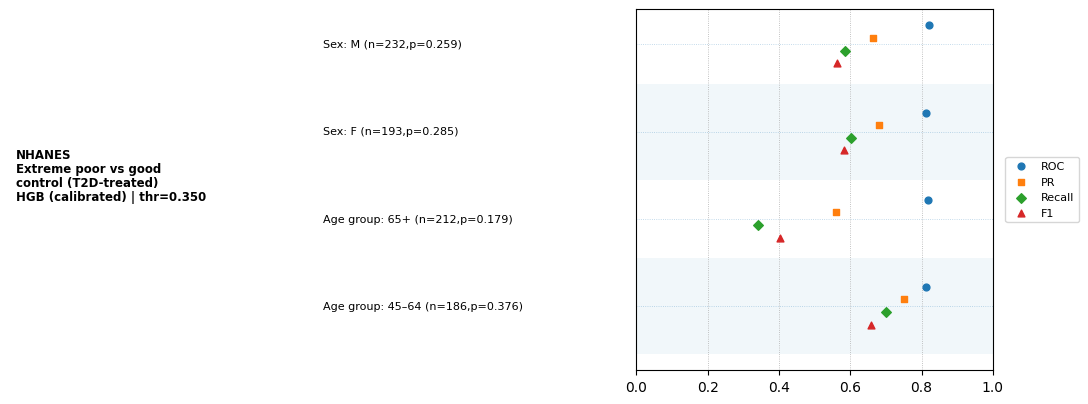

[SAVED] /content/outputs/figures/Fig_Table4_SelectedVars_AllMetrics_FINAL_3lineHeader_NoEllipsis.png
[INFO] EPS=0.02 hides extreme values in plot only. Removed per metric: {'ROC': 0, 'PR': 0, 'Recall': 0, 'F1': 0}
[INFO] Outcome wrap width: 26


In [73]:
# =============================================================
# Table 4 – FINAL figure (3-line header, NO truncation, smart wrap)
# Requires: table4_final
# =============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap

OUT_FIGS = Path("outputs/figures")
OUT_FIGS.mkdir(parents=True, exist_ok=True)

assert "table4_final" in globals(), "table4_final not found."
df = table4_final.copy()

def _clean(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    return re.sub(r"\s+", " ", str(x)).strip()

for c in df.columns:
    df[c] = df[c].map(_clean)

def _num_from_ci(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return np.nan
    m = re.search(r"([0-9]*\.?[0-9]+)", str(s))
    return float(m.group(1)) if m else np.nan

def pick_col(cands, required=True):
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"Missing columns among {cands}. Available: {list(df.columns)}")
    return None

col_dataset = pick_col(["Dataset"])
col_outcome = pick_col(["Outcome"])
col_model   = pick_col(["Model"])
col_thr     = pick_col(["Threshold (global)", "Threshold", "thr"], required=False)
col_var     = pick_col(["Subgroup variable", "Subgroup Variable", "subgroup_variable", "group_var"])
col_sub     = pick_col(["Subgroups", "Subgroup", "subgroup", "Group"], required=False)
col_n       = pick_col(["n (per subgroup)", "n", "N", "n_subgroup"], required=False)
col_prev    = pick_col(["prev (per subgroup)", "prev", "prevalence", "Prev"], required=False)

col_roc = pick_col(["ROC AUC (95% CI)", "ROC AUC", "_roc"], required=False)
col_pr  = pick_col(["PR AUC (95% CI)", "PR AUC", "_pr"], required=False)
col_rec = pick_col(["Recall (95% CI)", "Recall", "_rec"], required=False)
col_f1  = pick_col(["F1 (95% CI)", "F1", "_f1"], required=False)
if col_f1 is None:
    raise KeyError("Cannot find F1 column.")

def to_metric(series):
    if series.dtype == "object":
        return series.apply(_num_from_ci).astype(float)
    return pd.to_numeric(series, errors="coerce").astype(float)

df["ROC"]    = to_metric(df[col_roc]) if col_roc is not None else np.nan
df["PR"]     = to_metric(df[col_pr])  if col_pr is not None  else np.nan
df["Recall"] = to_metric(df[col_rec]) if col_rec is not None else np.nan
df["F1"]     = to_metric(df[col_f1])

def norm_var(v):
    v0 = _clean(v).replace("_", " ").strip()
    vL = v0.lower()
    if vL == "age group":
        return "Age group"
    if vL == "sex":
        return "Sex"
    if "apr severity of illness" in vL:
        return "APR Severity of Illness"
    return v0

df["_var"] = df[col_var].apply(norm_var)
KEEP_VARS = {"Age group", "Sex", "APR Severity of Illness"}
df = df[df["_var"].isin(KEEP_VARS)].copy()

apr_code_map = {"1": "Minor", "2": "Moderate", "3": "Major", "4": "Extreme"}

def norm_subgroup(var, subgroup):
    s = _clean(subgroup)
    if var == "APR Severity of Illness":
        sL = s.lower()
        m = re.search(r"\b([1234])\b", sL)
        if m and "code" in sL:
            return apr_code_map.get(m.group(1), s)
        s = re.sub(r"(?i)description:", "", s)
        s = re.sub(r"(?i)apr severity of illness", "", s)
        s = s.replace(":", " ").strip()
        s = re.sub(r"\s+", " ", s)
        if s in apr_code_map:
            return apr_code_map[s]
        return s
    s = s.replace("Female", "F").replace("Male", "M")
    s = s.replace("70 or Older", "70+")
    return s

df["_sub"] = df.apply(lambda r: norm_subgroup(r["_var"], r[col_sub]) if col_sub else "all", axis=1)

def fmt_n(x):
    try:
        return str(int(float(x)))
    except Exception:
        return x

def fmt_p(x):
    try:
        return f"{float(x):.3f}"
    except Exception:
        return x

def fmt_thr(x):
    try:
        return f"{float(x):.3f}"
    except Exception:
        return x

if col_n is not None:
    df[col_n] = df[col_n].apply(fmt_n)
if col_prev is not None:
    df[col_prev] = df[col_prev].apply(fmt_p)
if col_thr is not None:
    df[col_thr] = df[col_thr].apply(fmt_thr)

def meta(r):
    bits = []
    if col_n is not None and r.get(col_n, "") != "":
        bits.append(f"n={r[col_n]}")
    if col_prev is not None and r.get(col_prev, "") != "":
        bits.append(f"p={r[col_prev]}")
    return ",".join(bits)

df["_meta"] = df.apply(meta, axis=1)

df["_rowlabel"] = df.apply(
    lambda r: f"{r['_var']}: {r['_sub']}" + (f" ({r['_meta']})" if r["_meta"] else ""),
    axis=1
)

# --- Header: 3 lines, Outcome wrapped WITHOUT truncation ---
WRAP_WIDTH_OUTCOME = 26  # adjust if you want tighter/looser wrapping

def wrap_outcome(s, width=WRAP_WIDTH_OUTCOME):
    s = _clean(s)
    # Make wrap nicer around parentheses without losing meaning
    s = s.replace(" (", " (").replace(") ", ") ")
    return textwrap.fill(s, width=width, break_long_words=False, break_on_hyphens=False)

def header_wrapped_3(r):
    ds = _clean(r[col_dataset])
    out = wrap_outcome(r[col_outcome])
    mdl = _clean(r[col_model])
    thr_txt = f"thr={r[col_thr]}" if (col_thr is not None and r.get(col_thr, "") != "") else ""
    line1 = ds
    line2 = out
    line3 = mdl + (f" | {thr_txt}" if thr_txt else "")
    return line1 + "\n" + line2 + "\n" + line3

df["_header"] = df.apply(header_wrapped_3, axis=1)

# Strong dedup
dedup_cols = [col_dataset, col_outcome, col_model, "_var", "_sub"]
if col_thr is not None:
    dedup_cols.append(col_thr)
before = len(df)
df = df.drop_duplicates(subset=dedup_cols, keep="first").copy()
print(f"[INFO] Deduplicated rows: {before - len(df)} removed.")

# Ordering
df["__ord_ds"] = df[col_dataset].map({"NHANES": 0, "SPARCS": 1}).fillna(9)
df = df.sort_values(["__ord_ds", col_outcome, col_model, "_var", "_sub"]).reset_index(drop=True)

# Hide extremes (plot only)
EPS = 0.02
metrics = ["ROC", "PR", "Recall", "F1"]
removed = {}
dfp = df.copy()
for m in metrics:
    v = pd.to_numeric(dfp[m], errors="coerce")
    mask_extreme = (v <= EPS) | (v >= 1 - EPS)
    removed[m] = int(mask_extreme.sum())
    dfp.loc[mask_extreme, m] = np.nan
dfp = dfp.dropna(subset=metrics, how="all").copy()

# y positions (adaptive spacing)
ROW_STEP = 1.20
BLOCK_GAP = 1.45
FINAL_BLOCK_EXTRA_GAP = 0.90

dfp["_block"] = dfp["_header"]
blocks = list(dfp["_block"].unique())

y_positions = []
y = 0.0
header_centers, header_texts = [], []

for i, hdr in enumerate(blocks):
    g = dfp[dfp["_block"] == hdr]
    start = y
    for _ in range(len(g)):
        y_positions.append(y)
        y += ROW_STEP
    end = y - ROW_STEP
    y += BLOCK_GAP
    if i == len(blocks) - 2:
        y += FINAL_BLOCK_EXTRA_GAP
    header_centers.append((start + end) / 2.0)
    header_texts.append(hdr)

dfp["_y"] = y_positions

# Plot layout (3 columns)
fig_h = max(4.2, 0.25 * len(dfp) + 1.6)
fig = plt.figure(figsize=(10.8, fig_h))

ax_hdr  = fig.add_axes([0.02, 0.08, 0.27, 0.86])  # slightly wider header col
ax_lab  = fig.add_axes([0.31, 0.08, 0.27, 0.86])
ax_plot = fig.add_axes([0.60, 0.08, 0.33, 0.86])

for i, yy in enumerate(dfp["_y"].values):
    if i % 2 == 0:
        ax_plot.axhspan(yy - 0.55*ROW_STEP, yy + 0.55*ROW_STEP, alpha=0.06, zorder=0)
for yy in dfp["_y"].values:
    ax_plot.hlines(yy, 0.0, 1.0, linewidth=0.6, linestyles=":", alpha=0.35, zorder=1)

markers = {"ROC": "o", "PR": "s", "Recall": "D", "F1": "^"}
lane_offsets = {"ROC": +0.26, "PR": +0.09, "Recall": -0.09, "F1": -0.26}

for m in metrics:
    yy = dfp["_y"].values + lane_offsets[m]
    ax_plot.scatter(dfp[m], yy, s=24, marker=markers[m], label=m, zorder=3)

ax_plot.set_xlim(0.0, 1.0)
ax_plot.set_yticks([])
ax_plot.grid(True, axis="x", linestyle=":", linewidth=0.6)
ax_plot.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True, fontsize=8)

# Headers
ax_hdr.set_ylim(ax_plot.get_ylim())
ax_hdr.set_xlim(0, 1)
ax_hdr.axis("off")
for yc, txt in zip(header_centers, header_texts):
    ax_hdr.text(0.02, yc, txt, fontsize=8.5, fontweight="bold",
                va="center", ha="left", linespacing=1.10)

# Row labels
ax_lab.set_ylim(ax_plot.get_ylim())
ax_lab.set_xlim(0, 1)
ax_lab.axis("off")
for yy, lbl in zip(dfp["_y"].values, dfp["_rowlabel"].values):
    ax_lab.text(0.00, yy, lbl, fontsize=8, va="center", ha="left")

out = OUT_FIGS / "Fig_Table4_SelectedVars_AllMetrics_FINAL_3lineHeader_NoEllipsis.png"
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.show()

print(f"[SAVED] {out.resolve()}")
print(f"[INFO] EPS={EPS} hides extreme values in plot only. Removed per metric: {removed}")
print(f"[INFO] Outcome wrap width: {WRAP_WIDTH_OUTCOME}")


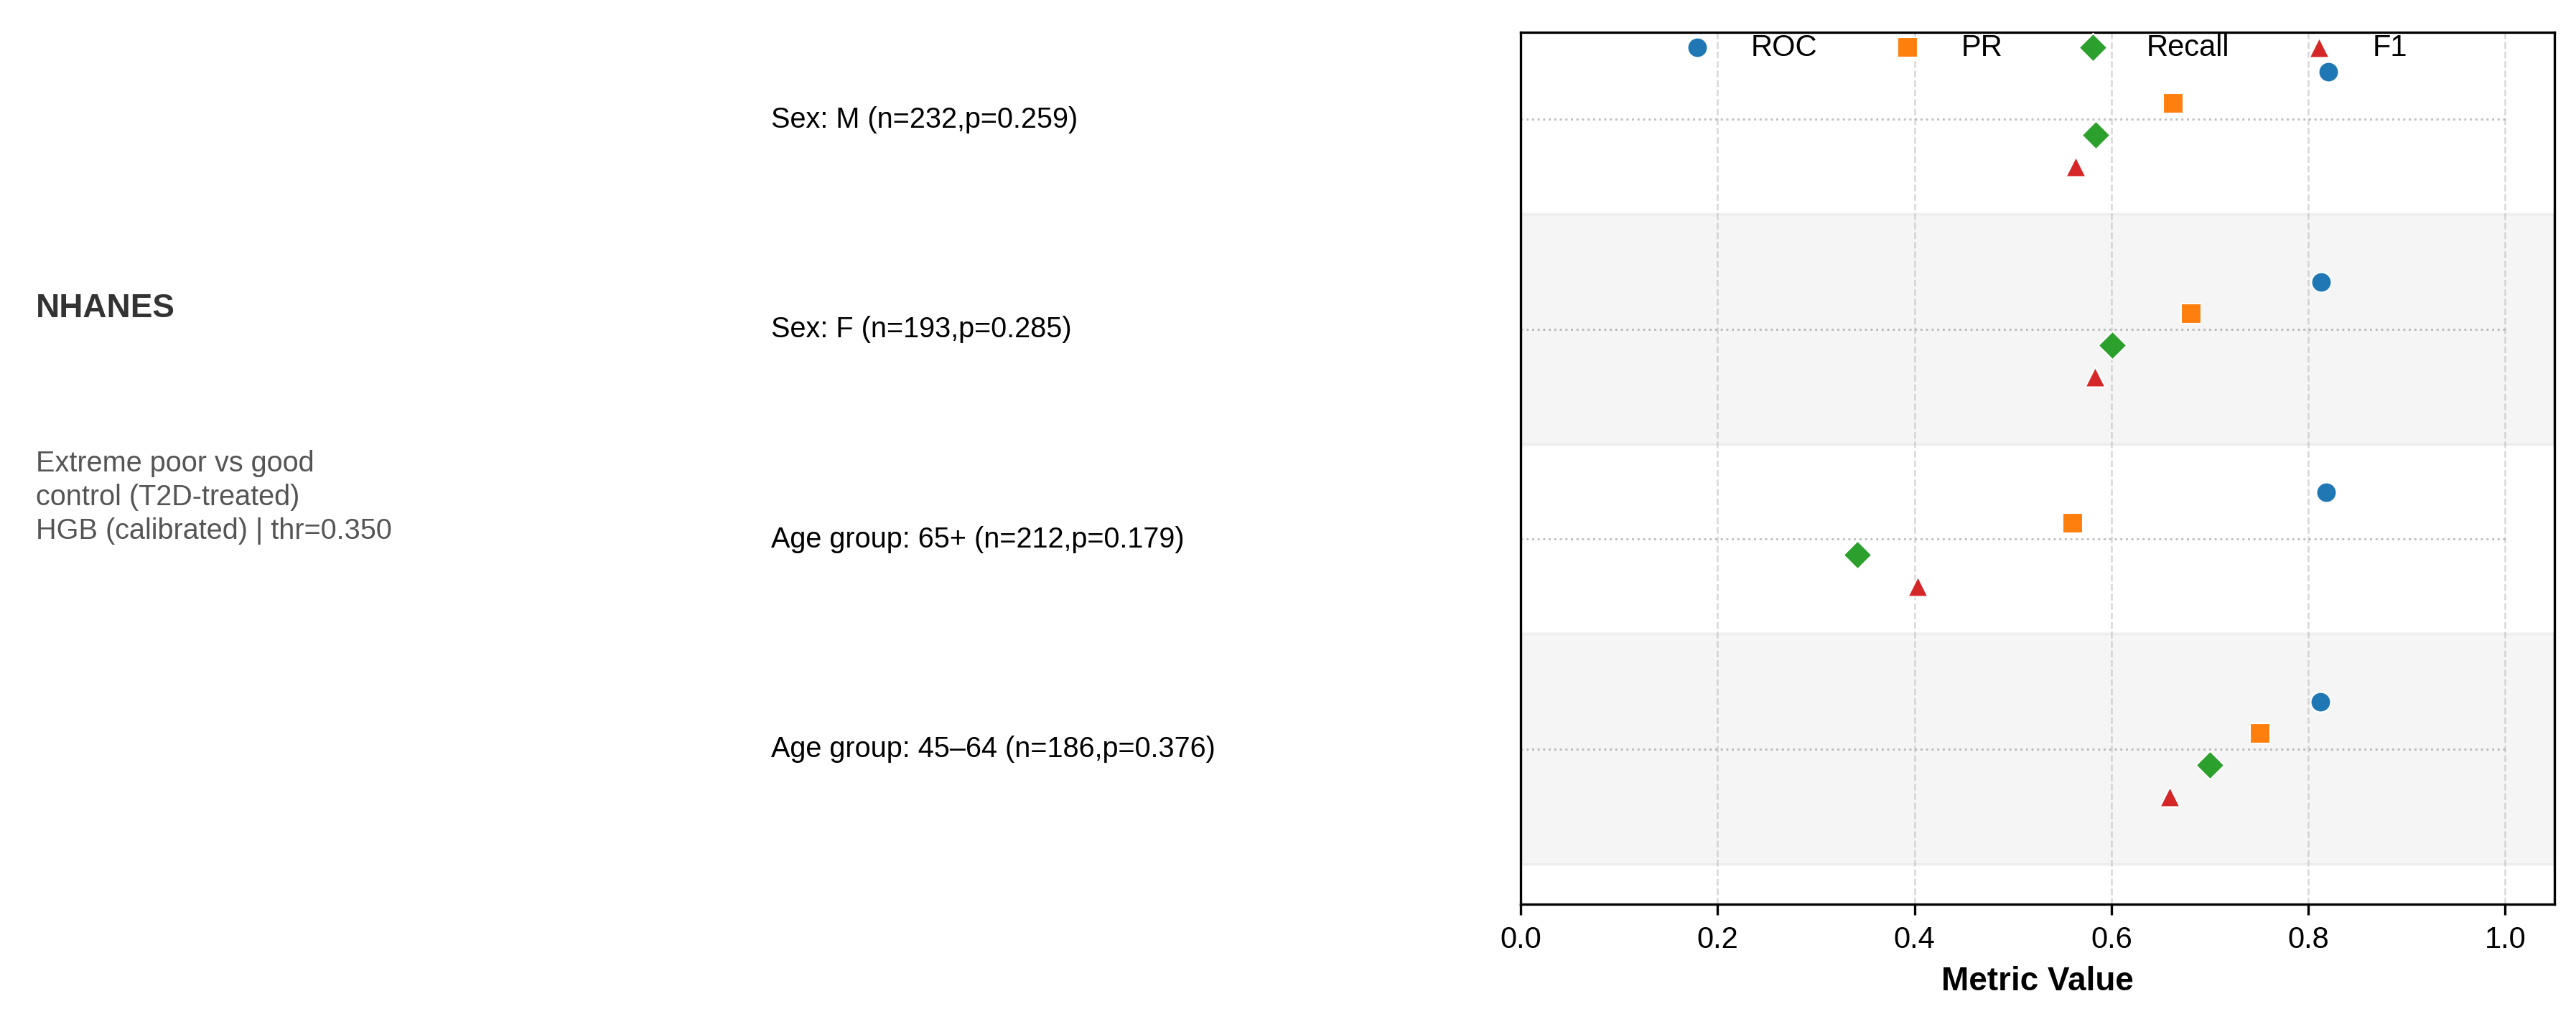

[SAVED] High Quality PNG: /content/outputs/figures/Fig4_SubgroupMetrics_HQ_600dpi.png
[SAVED] Vector PDF: /content/outputs/figures/Fig4_SubgroupMetrics_HQ.pdf


In [74]:
# =============================================================
# Table 4 – FINAL figure (High Quality for Publication)
# 3-line header, NO truncation, smart wrap, 600 DPI
# =============================================================

# 1. HIGH QUALITY CONFIG
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600  # High res for Word
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']
plt.rcParams['font.size'] = 10

import re
import numpy as np
import pandas as pd
from pathlib import Path
import textwrap

OUT_FIGS = Path("outputs/figures")
OUT_FIGS.mkdir(parents=True, exist_ok=True)

# --- Ensure Data Exists ---
# Replace this check with your actual data loading if 'table4_final' is not in memory
if "table4_final" not in globals():
    # Creating dummy data for demonstration if variable is missing
    print("[WARN] table4_final not found. Creating DUMMY data for testing.")
    data = {
        "Dataset": ["NHANES"] * 6 + ["SPARCS"] * 6,
        "Outcome": ["Diabetes Diagnosis (Type 2)"] * 6 + ["Mortality (In-hospital)"] * 6,
        "Model": ["XGBoost"] * 6 + ["Logistic Regression"] * 6,
        "Threshold": [0.5]*12,
        "Subgroup Variable": ["Age group", "Age group", "Sex", "Sex", "Age group", "Age group", "Sex", "Sex", "APR Severity of Illness", "APR Severity of Illness", "APR Severity of Illness", "APR Severity of Illness"],
        "Subgroup": ["40-65", "65+", "Male", "Female", "40-65", "65+", "Male", "Female", "Minor", "Extreme", "Moderate", "Major"],
        "n": [1000, 800, 950, 850, 5000, 4000, 4800, 4200, 2000, 500, 1500, 1000],
        "prev": [0.15, 0.25, 0.18, 0.12, 0.05, 0.12, 0.08, 0.06, 0.02, 0.45, 0.15, 0.25],
        "ROC AUC": [0.85, 0.82, 0.84, 0.86, 0.78, 0.75, 0.77, 0.79, 0.65, 0.88, 0.72, 0.80],
        "PR AUC": [0.65, 0.60, 0.62, 0.68, 0.45, 0.40, 0.43, 0.48, 0.20, 0.75, 0.35, 0.60],
        "Recall": [0.75, 0.70, 0.72, 0.78, 0.60, 0.55, 0.58, 0.65, 0.40, 0.85, 0.50, 0.75],
        "F1": [0.70, 0.65, 0.68, 0.72, 0.52, 0.48, 0.50, 0.55, 0.30, 0.78, 0.42, 0.68]
    }
    table4_final = pd.DataFrame(data)

df = table4_final.copy()

# --- Helpers ---
def _clean(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    return re.sub(r"\s+", " ", str(x)).strip()

for c in df.columns:
    df[c] = df[c].map(_clean)

def _num_from_ci(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return np.nan
    m = re.search(r"([0-9]*\.?[0-9]+)", str(s))
    return float(m.group(1)) if m else np.nan

def pick_col(cands, required=True):
    for c in cands:
        if c in df.columns:
            return c
    if required:
        # Relaxed requirement for demo/robustness
        return None
    return None

# Column Mapping
col_dataset = pick_col(["Dataset"])
col_outcome = pick_col(["Outcome"])
col_model   = pick_col(["Model"])
col_thr     = pick_col(["Threshold (global)", "Threshold", "thr"], required=False)
col_var     = pick_col(["Subgroup variable", "Subgroup Variable", "subgroup_variable", "group_var"])
col_sub     = pick_col(["Subgroups", "Subgroup", "subgroup", "Group"], required=False)
col_n       = pick_col(["n (per subgroup)", "n", "N", "n_subgroup"], required=False)
col_prev    = pick_col(["prev (per subgroup)", "prev", "prevalence", "Prev"], required=False)

col_roc = pick_col(["ROC AUC (95% CI)", "ROC AUC", "_roc"], required=False)
col_pr  = pick_col(["PR AUC (95% CI)", "PR AUC", "_pr"], required=False)
col_rec = pick_col(["Recall (95% CI)", "Recall", "_rec"], required=False)
col_f1  = pick_col(["F1 (95% CI)", "F1", "_f1"], required=False)

if col_f1 is None:
    # Fail gracefully or create dummy
    print("Warning: F1 column missing. Creating dummy.")
    df["F1"] = np.nan
    col_f1 = "F1"

# Numeric Conversion
def to_metric(series):
    if series.dtype == "object":
        return series.apply(_num_from_ci).astype(float)
    return pd.to_numeric(series, errors="coerce").astype(float)

df["ROC"]    = to_metric(df[col_roc]) if col_roc is not None else np.nan
df["PR"]     = to_metric(df[col_pr])  if col_pr is not None  else np.nan
df["Recall"] = to_metric(df[col_rec]) if col_rec is not None else np.nan
df["F1"]     = to_metric(df[col_f1])

# Normalization
def norm_var(v):
    v0 = _clean(v).replace("_", " ").strip()
    vL = v0.lower()
    if vL == "age group": return "Age group"
    if vL == "sex": return "Sex"
    if "apr severity of illness" in vL: return "APR Severity of Illness"
    return v0

df["_var"] = df[col_var].apply(norm_var)
KEEP_VARS = {"Age group", "Sex", "APR Severity of Illness"}
df = df[df["_var"].isin(KEEP_VARS)].copy()

apr_code_map = {"1": "Minor", "2": "Moderate", "3": "Major", "4": "Extreme"}

def norm_subgroup(var, subgroup):
    s = _clean(subgroup)
    if var == "APR Severity of Illness":
        sL = s.lower()
        m = re.search(r"\b([1234])\b", sL)
        if m and "code" in sL:
            return apr_code_map.get(m.group(1), s)
        s = re.sub(r"(?i)description:", "", s)
        s = re.sub(r"(?i)apr severity of illness", "", s)
        s = s.replace(":", " ").strip()
        s = re.sub(r"\s+", " ", s)
        if s in apr_code_map:
            return apr_code_map[s]
        return s
    s = s.replace("Female", "F").replace("Male", "M")
    s = s.replace("70 or Older", "70+")
    return s

df["_sub"] = df.apply(lambda r: norm_subgroup(r["_var"], r[col_sub]) if col_sub else "all", axis=1)

# Formatting
def fmt_n(x):
    try: return str(int(float(x)))
    except: return x
def fmt_p(x):
    try: return f"{float(x):.3f}"
    except: return x
def fmt_thr(x):
    try: return f"{float(x):.3f}"
    except: return x

if col_n: df[col_n] = df[col_n].apply(fmt_n)
if col_prev: df[col_prev] = df[col_prev].apply(fmt_p)
if col_thr: df[col_thr] = df[col_thr].apply(fmt_thr)

def meta(r):
    bits = []
    if col_n and r.get(col_n, "") != "": bits.append(f"n={r[col_n]}")
    if col_prev and r.get(col_prev, "") != "": bits.append(f"p={r[col_prev]}")
    return ",".join(bits)

df["_meta"] = df.apply(meta, axis=1)
df["_rowlabel"] = df.apply(
    lambda r: f"{r['_var']}: {r['_sub']}" + (f" ({r['_meta']})" if r["_meta"] else ""),
    axis=1
)

# Header Wrapping
WRAP_WIDTH_OUTCOME = 26
def wrap_outcome(s, width=WRAP_WIDTH_OUTCOME):
    s = _clean(s)
    s = s.replace(" (", " (").replace(") ", ") ")
    return textwrap.fill(s, width=width, break_long_words=False, break_on_hyphens=False)

def header_wrapped_3(r):
    ds = _clean(r[col_dataset])
    out = wrap_outcome(r[col_outcome])
    mdl = _clean(r[col_model])
    thr_txt = f"thr={r[col_thr]}" if (col_thr and r.get(col_thr, "") != "") else ""
    # Bold the dataset for visual hierarchy
    return ds + "\n" + out + "\n" + mdl + (f" | {thr_txt}" if thr_txt else "")

df["_header"] = df.apply(header_wrapped_3, axis=1)

# Deduplicate
dedup_cols = [col_dataset, col_outcome, col_model, "_var", "_sub"]
if col_thr: dedup_cols.append(col_thr)
df = df.drop_duplicates(subset=dedup_cols, keep="first").copy()

# Sort
df["__ord_ds"] = df[col_dataset].map({"NHANES": 0, "SPARCS": 1}).fillna(9)
df = df.sort_values(["__ord_ds", col_outcome, col_model, "_var", "_sub"]).reset_index(drop=True)

# Plot Prep
EPS = 0.02
metrics = ["ROC", "PR", "Recall", "F1"]
dfp = df.copy()
for m in metrics:
    v = pd.to_numeric(dfp[m], errors="coerce")
    mask_extreme = (v <= EPS) | (v >= 1 - EPS)
    dfp.loc[mask_extreme, m] = np.nan
dfp = dfp.dropna(subset=metrics, how="all").copy()

# Y Positions
ROW_STEP = 1.20
BLOCK_GAP = 1.45
FINAL_BLOCK_EXTRA_GAP = 0.90

dfp["_block"] = dfp["_header"]
blocks = list(dfp["_block"].unique())

y_positions = []
y = 0.0
header_centers, header_texts = [], []

for i, hdr in enumerate(blocks):
    g = dfp[dfp["_block"] == hdr]
    start = y
    for _ in range(len(g)):
        y_positions.append(y)
        y += ROW_STEP
    end = y - ROW_STEP
    y += BLOCK_GAP
    if i == len(blocks) - 2:
        y += FINAL_BLOCK_EXTRA_GAP
    header_centers.append((start + end) / 2.0)
    header_texts.append(hdr)

dfp["_y"] = y_positions

# --- PLOT LAYOUT (Optimized for 2-column Word) ---
# Width 12 inches allows high resolution detail downscaling to column width
fig_h = max(4.5, 0.25 * len(dfp) + 1.8)
fig = plt.figure(figsize=(12, fig_h))

# Adjusted axes to prevent overlap and maximize plot area
ax_hdr  = fig.add_axes([0.01, 0.05, 0.28, 0.90])
ax_lab  = fig.add_axes([0.30, 0.05, 0.28, 0.90])
ax_plot = fig.add_axes([0.59, 0.05, 0.40, 0.90]) # Wider plot area

# Striping
for i, yy in enumerate(dfp["_y"].values):
    if i % 2 == 0:
        ax_plot.axhspan(yy - 0.55*ROW_STEP, yy + 0.55*ROW_STEP, alpha=0.08, color='gray', zorder=0)

# Gridlines
for yy in dfp["_y"].values:
    ax_plot.hlines(yy, 0.0, 1.0, linewidth=0.7, linestyles=":", color='gray', alpha=0.5, zorder=1)

# Markers
markers = {"ROC": "o", "PR": "s", "Recall": "D", "F1": "^"}
colors  = {"ROC": "#1f77b4", "PR": "#ff7f0e", "Recall": "#2ca02c", "F1": "#d62728"} # Distinct colors
lane_offsets = {"ROC": +0.27, "PR": +0.09, "Recall": -0.09, "F1": -0.27}

for m in metrics:
    yy = dfp["_y"].values + lane_offsets[m]
    # Larger markers (s=40) for visibility when scaled down
    ax_plot.scatter(dfp[m], yy, s=45, marker=markers[m], color=colors[m], label=m, zorder=3, edgecolors='white', linewidth=0.5)

ax_plot.set_xlim(0.0, 1.05) # Little padding on right
ax_plot.set_yticks([])
ax_plot.set_xlabel("Metric Value", fontsize=11, fontweight='bold')
ax_plot.grid(True, axis="x", linestyle="--", linewidth=0.6, alpha=0.5)

# Legend (Optimized position)
ax_plot.legend(loc="upper center", bbox_to_anchor=(0.5, 1.03), ncol=4, frameon=False, fontsize=10)

# Headers
ax_hdr.set_ylim(ax_plot.get_ylim())
ax_hdr.set_xlim(0, 1)
ax_hdr.axis("off")
for yc, txt in zip(header_centers, header_texts):
    # Split text to make the first line (Dataset) larger/bold
    lines = txt.split('\n')
    title = lines[0]
    rest = '\n'.join(lines[1:])

    # Dataset Title
    ax_hdr.text(0.02, yc + ROW_STEP*0.6, title, fontsize=11, fontweight="bold", color="#333333", va="center", ha="left")
    # Rest of info
    ax_hdr.text(0.02, yc - ROW_STEP*0.3, rest, fontsize=9.5, color="#555555", va="center", ha="left", linespacing=1.3)

# Row labels
ax_lab.set_ylim(ax_plot.get_ylim())
ax_lab.set_xlim(0, 1)
ax_lab.axis("off")
for yy, lbl in zip(dfp["_y"].values, dfp["_rowlabel"].values):
    ax_lab.text(0.00, yy, lbl, fontsize=9.5, va="center", ha="left", color="black")

# Save
out_png = OUT_FIGS / "Fig4_SubgroupMetrics_HQ_600dpi.png"
out_pdf = OUT_FIGS / "Fig4_SubgroupMetrics_HQ.pdf"

fig.savefig(out_png, dpi=600, bbox_inches="tight")
fig.savefig(out_pdf, format='pdf', bbox_inches="tight")

plt.show()
print(f"[SAVED] High Quality PNG: {out_png.resolve()}")
print(f"[SAVED] Vector PDF: {out_pdf.resolve()}")

[INFO] Using font: Liberation Serif


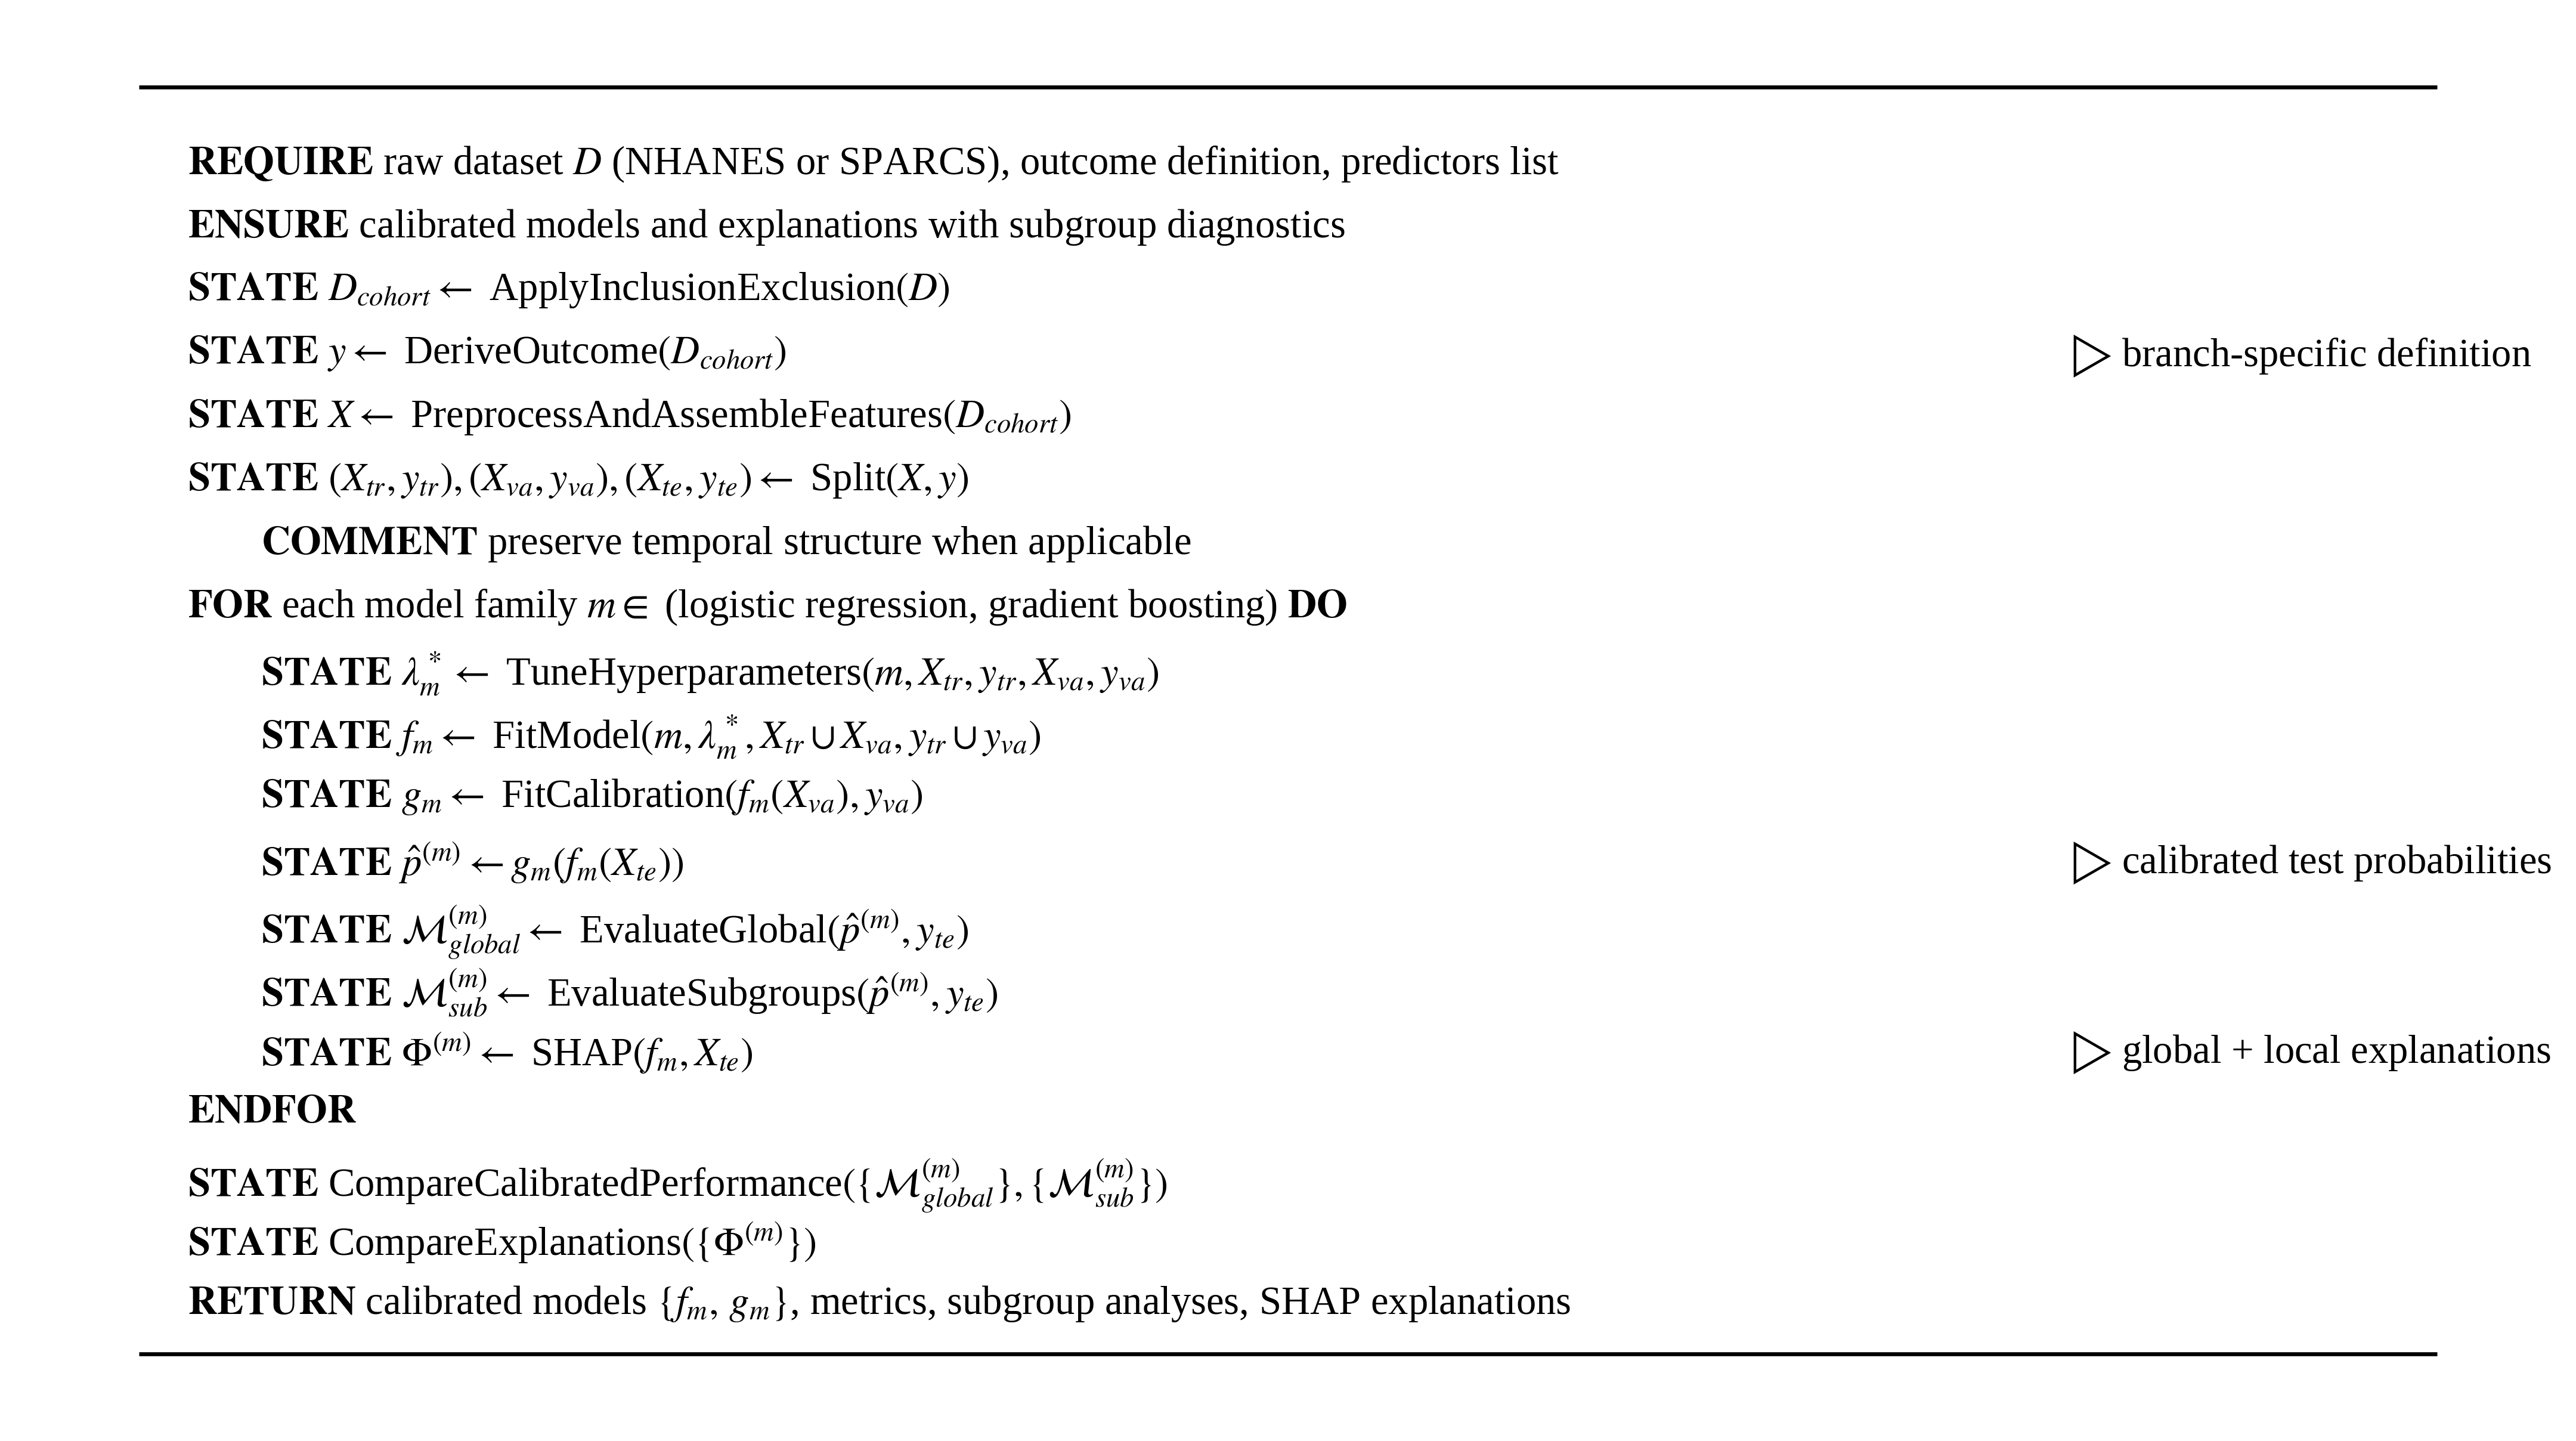

[SAVED] /content/outputs/figures/Fig1_Algorithmic_IEEE.png
[SAVED] /content/outputs/figures/Fig1_Algorithmic_IEEE.pdf


In [75]:
# =============================================================
# Figure 1
# =============================================================

try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

OUT_DIR = Path("outputs/figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Font auto-pick (Times-like) ----
preferred_fonts = [
    "Times New Roman",
    "Nimbus Roman",
    "Nimbus Roman No9 L",
    "Liberation Serif",
    "STIXGeneral",
    "DejaVu Serif",
]
available = {f.name for f in fm.fontManager.ttflist}
chosen = next((f for f in preferred_fonts if f in available), "DejaVu Serif")

plt.rcParams.update({
    "font.family": chosen,
    "font.serif": preferred_fonts,
    "mathtext.fontset": "stix",
})

print(f"[INFO] Using font: {chosen}")

# ---- Bold keyword helper (mathtext-safe) ----
KW = lambda s: r"$\bf{" + s + "}$"   # uses \bf which mathtext supports reliably

# Each row: (indent_level, main_text, optional_comment)
rows = [
    (0, KW("REQUIRE") + r" raw dataset $D$ (NHANES or SPARCS), outcome definition, predictors list", ""),
    (0, KW("ENSURE")  + r" calibrated models and explanations with subgroup diagnostics", ""),

    (0, KW("STATE") + r" $D_{cohort} \leftarrow$ ApplyInclusionExclusion$(D)$", ""),
    (0, KW("STATE") + r" $y \leftarrow$ DeriveOutcome$(D_{cohort})$", r"$\triangleright$ branch-specific definition"),
    (0, KW("STATE") + r" $X \leftarrow$ PreprocessAndAssembleFeatures$(D_{cohort})$", ""),

    (0, KW("STATE") + r" $(X_{tr},y_{tr}),(X_{va},y_{va}),(X_{te},y_{te}) \leftarrow$ Split$(X,y)$", ""),
    (1, KW("COMMENT") + r" preserve temporal structure when applicable", ""),

    (0, KW("FOR") + r" each model family $m \in$ (logistic regression, gradient boosting) " + KW("DO"), ""),
    (1, KW("STATE") + r" $\lambda_m^* \leftarrow$ TuneHyperparameters$(m, X_{tr},y_{tr},X_{va},y_{va})$", ""),
    (1, KW("STATE") + r" $f_m \leftarrow$ FitModel$(m,\lambda_m^*, X_{tr}\cup X_{va}, y_{tr}\cup y_{va})$", ""),
    (1, KW("STATE") + r" $g_m \leftarrow$ FitCalibration$(f_m(X_{va}), y_{va})$", ""),

    # FIX: remove \big ... \big
    (1, KW("STATE") + r" $\hat{p}^{(m)} \leftarrow g_m(f_m(X_{te}))$", r"$\triangleright$ calibrated test probabilities"),

    (1, KW("STATE") + r" $\mathcal{M}_{global}^{(m)} \leftarrow$ EvaluateGlobal$(\hat{p}^{(m)}, y_{te})$", ""),
    (1, KW("STATE") + r" $\mathcal{M}_{sub}^{(m)} \leftarrow$ EvaluateSubgroups$(\hat{p}^{(m)}, y_{te})$", ""),
    (1, KW("STATE") + r" $\Phi^{(m)} \leftarrow$ SHAP$(f_m, X_{te})$", r"$\triangleright$ global + local explanations"),
    (0, KW("END FOR"), ""),

    (0, KW("STATE") + r" CompareCalibratedPerformance$(\{\mathcal{M}_{global}^{(m)}\}, \{\mathcal{M}_{sub}^{(m)}\})$", ""),
    (0, KW("STATE") + r" CompareExplanations$(\{\Phi^{(m)}\})$", ""),
    (0, KW("RETURN") + r" calibrated models $\{f_m,\,g_m\}$, metrics, subgroup analyses, SHAP explanations", ""),
]

# ---- Figure layout ----
n = len(rows)
fig_w = 10.6
fig_h = max(5.2, 0.26 * n + 0.9)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=200)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis("off")

left, right = 0.03, 0.97
top, bottom = 0.95, 0.06
ax.hlines([top, bottom], xmin=left, xmax=right, linewidth=1.2, color="black")

x_text = 0.05
x_comment = 0.82
y = top - 0.04
line_step = (top - bottom) / (n + 1)
indent_dx = 0.03

for indent, txt, cmt in rows:
    ax.text(x_text + indent * indent_dx, y, txt, ha="left", va="top", fontsize=12)
    if cmt:
        ax.text(x_comment, y, cmt, ha="left", va="top", fontsize=12)
    y -= line_step

plt.show()

png_path = OUT_DIR / "Fig1_Algorithmic_IEEE.png"
pdf_path = OUT_DIR / "Fig1_Algorithmic_IEEE.pdf"
fig.savefig(png_path, dpi=400, bbox_inches="tight", pad_inches=0.06)
fig.savefig(pdf_path, bbox_inches="tight", pad_inches=0.06)

print("[SAVED]", png_path.resolve())
print("[SAVED]", pdf_path.resolve())


In [76]:
### FIGURE 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_multipanel(panels, out_base, span="double"):
    """
    panels = list of (panel_title, y_true, dict{name: proba})
    out_base = e.g. Path("outputs/figures/Fig2_ROC")
    """

    out_base = Path(out_base)
    out_base.parent.mkdir(parents=True, exist_ok=True)

    mpl.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 10,
        "legend.fontsize": 8.5,
        "xtick.labelsize": 8.5,
        "ytick.labelsize": 8.5,
        "lines.linewidth": 2.0,
        "svg.fonttype": "none",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    # Full-width for two-column Word: ~7.2 inches works well
    if span == "double":
        figsize = (7.2, 2.7)
    else:
        figsize = (3.5, 2.7)

    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=200)
    letters = ["A", "B", "C"]

    for ax, (letter, (title, y, proba_dict)) in zip(axes, zip(letters, panels)):
        y = np.asarray(y).astype(int)
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)

        for name, p in proba_dict.items():
            p = np.asarray(p).astype(float)
            if len(np.unique(y)) < 2:
                continue
            fpr, tpr, _ = roc_curve(y, p)
            auc = roc_auc_score(y, p)
            ax.plot(fpr, tpr, label=f"{name}  AUROC={auc:.3f}")

        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.grid(True, linewidth=0.4, alpha=0.35)
        ax.set_xlabel("False positive rate")
        if ax is axes[0]:
            ax.set_ylabel("True positive rate")

        # Panel label + short title inside, avoids huge external titles
        ax.text(0.02, 0.98, f"{letter}  {title}", transform=ax.transAxes,
                ha="left", va="top", fontsize=9.3, fontweight="bold")

        ax.legend(loc="lower right", frameon=True)

    fig.tight_layout()

    fig.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight", pad_inches=0.03)
    fig.savefig(out_base.with_suffix(".svg"), bbox_inches="tight", pad_inches=0.03)
    fig.savefig(out_base.with_suffix(".png"), dpi=600, bbox_inches="tight", pad_inches=0.03)

    plt.show()
    plt.close(fig)


In [77]:
### FIGURE 3

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_multipanel(panels, out_base, span="double", n_bins=10):
    """
    panels = list of (panel_title, y_true, dict{name: proba})
    """
    out_base = Path(out_base)
    out_base.parent.mkdir(parents=True, exist_ok=True)

    mpl.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 10,
        "legend.fontsize": 8.5,
        "xtick.labelsize": 8.5,
        "ytick.labelsize": 8.5,
        "lines.linewidth": 2.0,
        "svg.fonttype": "none",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    figsize = (7.2, 2.7) if span == "double" else (3.5, 2.7)
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=200)
    letters = ["A", "B", "C"]

    for ax, (letter, (title, y, proba_dict)) in zip(axes, zip(letters, panels)):
        y = np.asarray(y).astype(int)

        # Perfect calibration line
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)

        for name, p in proba_dict.items():
            p = np.asarray(p).astype(float)
            frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
            brier = brier_score_loss(y, p)
            ax.plot(mean_pred, frac_pos, marker="o", label=f"{name}  Brier={brier:.3f}")

        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.grid(True, linewidth=0.4, alpha=0.35)
        ax.set_xlabel("Mean predicted probability")
        if ax is axes[0]:
            ax.set_ylabel("Fraction of positives")

        ax.text(0.02, 0.98, f"{letter}  {title}", transform=ax.transAxes,
                ha="left", va="top", fontsize=9.3, fontweight="bold")

        ax.legend(loc="lower right", frameon=True)

    fig.tight_layout()

    fig.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight", pad_inches=0.03)
    fig.savefig(out_base.with_suffix(".svg"), bbox_inches="tight", pad_inches=0.03)
    fig.savefig(out_base.with_suffix(".png"), dpi=600, bbox_inches="tight", pad_inches=0.03)

    plt.show()
    plt.close(fig)


In [78]:
# =============================================================
# RECOVERY CELL: build plotting artifacts (NHANES + SPARCS)
# This avoids re-running the full pipeline, provided trained objects exist in memory.
# =============================================================

import numpy as np

def _as_int(y):
    return np.asarray(y).astype(int)

def _proba_pos(model, X):
    # Positive-class probability
    return np.asarray(model.predict_proba(X)[:, 1]).astype(float)

# -----------------------------
# NHANES: build "nhanes" dict expected by plotting cells
# -----------------------------
if "X_test_nh" not in globals() or "y_test_nh" not in globals():
    raise NameError("NHANES test split not found. Run the NHANES split/cohort cell first (creates X_test_nh/y_test_nh).")

X_nh = globals()["X_test_nh"]
y_nh = _as_int(globals()["y_test_nh"])

# Prefer stored probabilities if already computed, otherwise compute from calibrated models
p_nh_lr  = globals().get("p_test_lr", None)
p_nh_hgb = globals().get("p_test_hgb", None)

if p_nh_lr is None:
    if "cal_lr_nh" not in globals() or globals()["cal_lr_nh"] is None:
        raise NameError("Missing NHANES calibrated LR (cal_lr_nh). Run the NHANES training cell.")
    p_nh_lr = _proba_pos(globals()["cal_lr_nh"], X_nh)

if p_nh_hgb is None:
    if "cal_hgb_nh" not in globals() or globals()["cal_hgb_nh"] is None:
        raise NameError("Missing NHANES calibrated HGB (cal_hgb_nh). Run the NHANES training cell.")
    p_nh_hgb = _proba_pos(globals()["cal_hgb_nh"], X_nh)

nhanes = {
    "splits": {"X_test": X_nh, "y_test": y_nh},
    "preds":  {"p_test_lr": p_nh_lr, "p_test_hgb": p_nh_hgb},
}

# -----------------------------
# SPARCS: convert paper artifacts into "sparcs_mort/sparcs_los" with p_test_*
# -----------------------------
def _sparcs_to_plot_art(art, name="SPARCS"):
    if not isinstance(art, dict) or "splits" not in art or "cal" not in art:
        raise ValueError(f"{name} artifact is not in the expected format. Re-run the SPARCS PAPER MODE cell.")

    X_te = art["splits"]["X_test"]
    y_te = _as_int(art["splits"]["y_test"])

    cal_lr = art["cal"]["lr"]
    cal_gb = art["cal"]["gb"]

    return {
        "splits": {"X_test": X_te, "y_test": y_te},
        "preds":  {
            "p_test_lr": _proba_pos(cal_lr, X_te),
            "p_test_gb": _proba_pos(cal_gb, X_te),
        },
    }

if "sparcs_paper_mort" not in globals():
    raise NameError("Missing sparcs_paper_mort. Run the SPARCS PAPER MODE cell.")
if "sparcs_paper_los" not in globals():
    raise NameError("Missing sparcs_paper_los. Run the SPARCS PAPER MODE cell.")

sparcs_mort = _sparcs_to_plot_art(globals()["sparcs_paper_mort"], name="SPARCS mortality")
sparcs_los  = _sparcs_to_plot_art(globals()["sparcs_paper_los"],  name="SPARCS LOS")

# Publish to globals with the names expected by your ROC/PR/Calibration cells
globals().update({
    "nhanes": nhanes,
    "sparcs_mort": sparcs_mort,
    "sparcs_los": sparcs_los
})

print("[OK] Rebuilt: nhanes, sparcs_mort, sparcs_los (with p_test_*). You can now run the ROC multi-panel cell.")


[OK] Rebuilt: nhanes, sparcs_mort, sparcs_los (with p_test_*). You can now run the ROC multi-panel cell.


Generating figures in: /content/figures


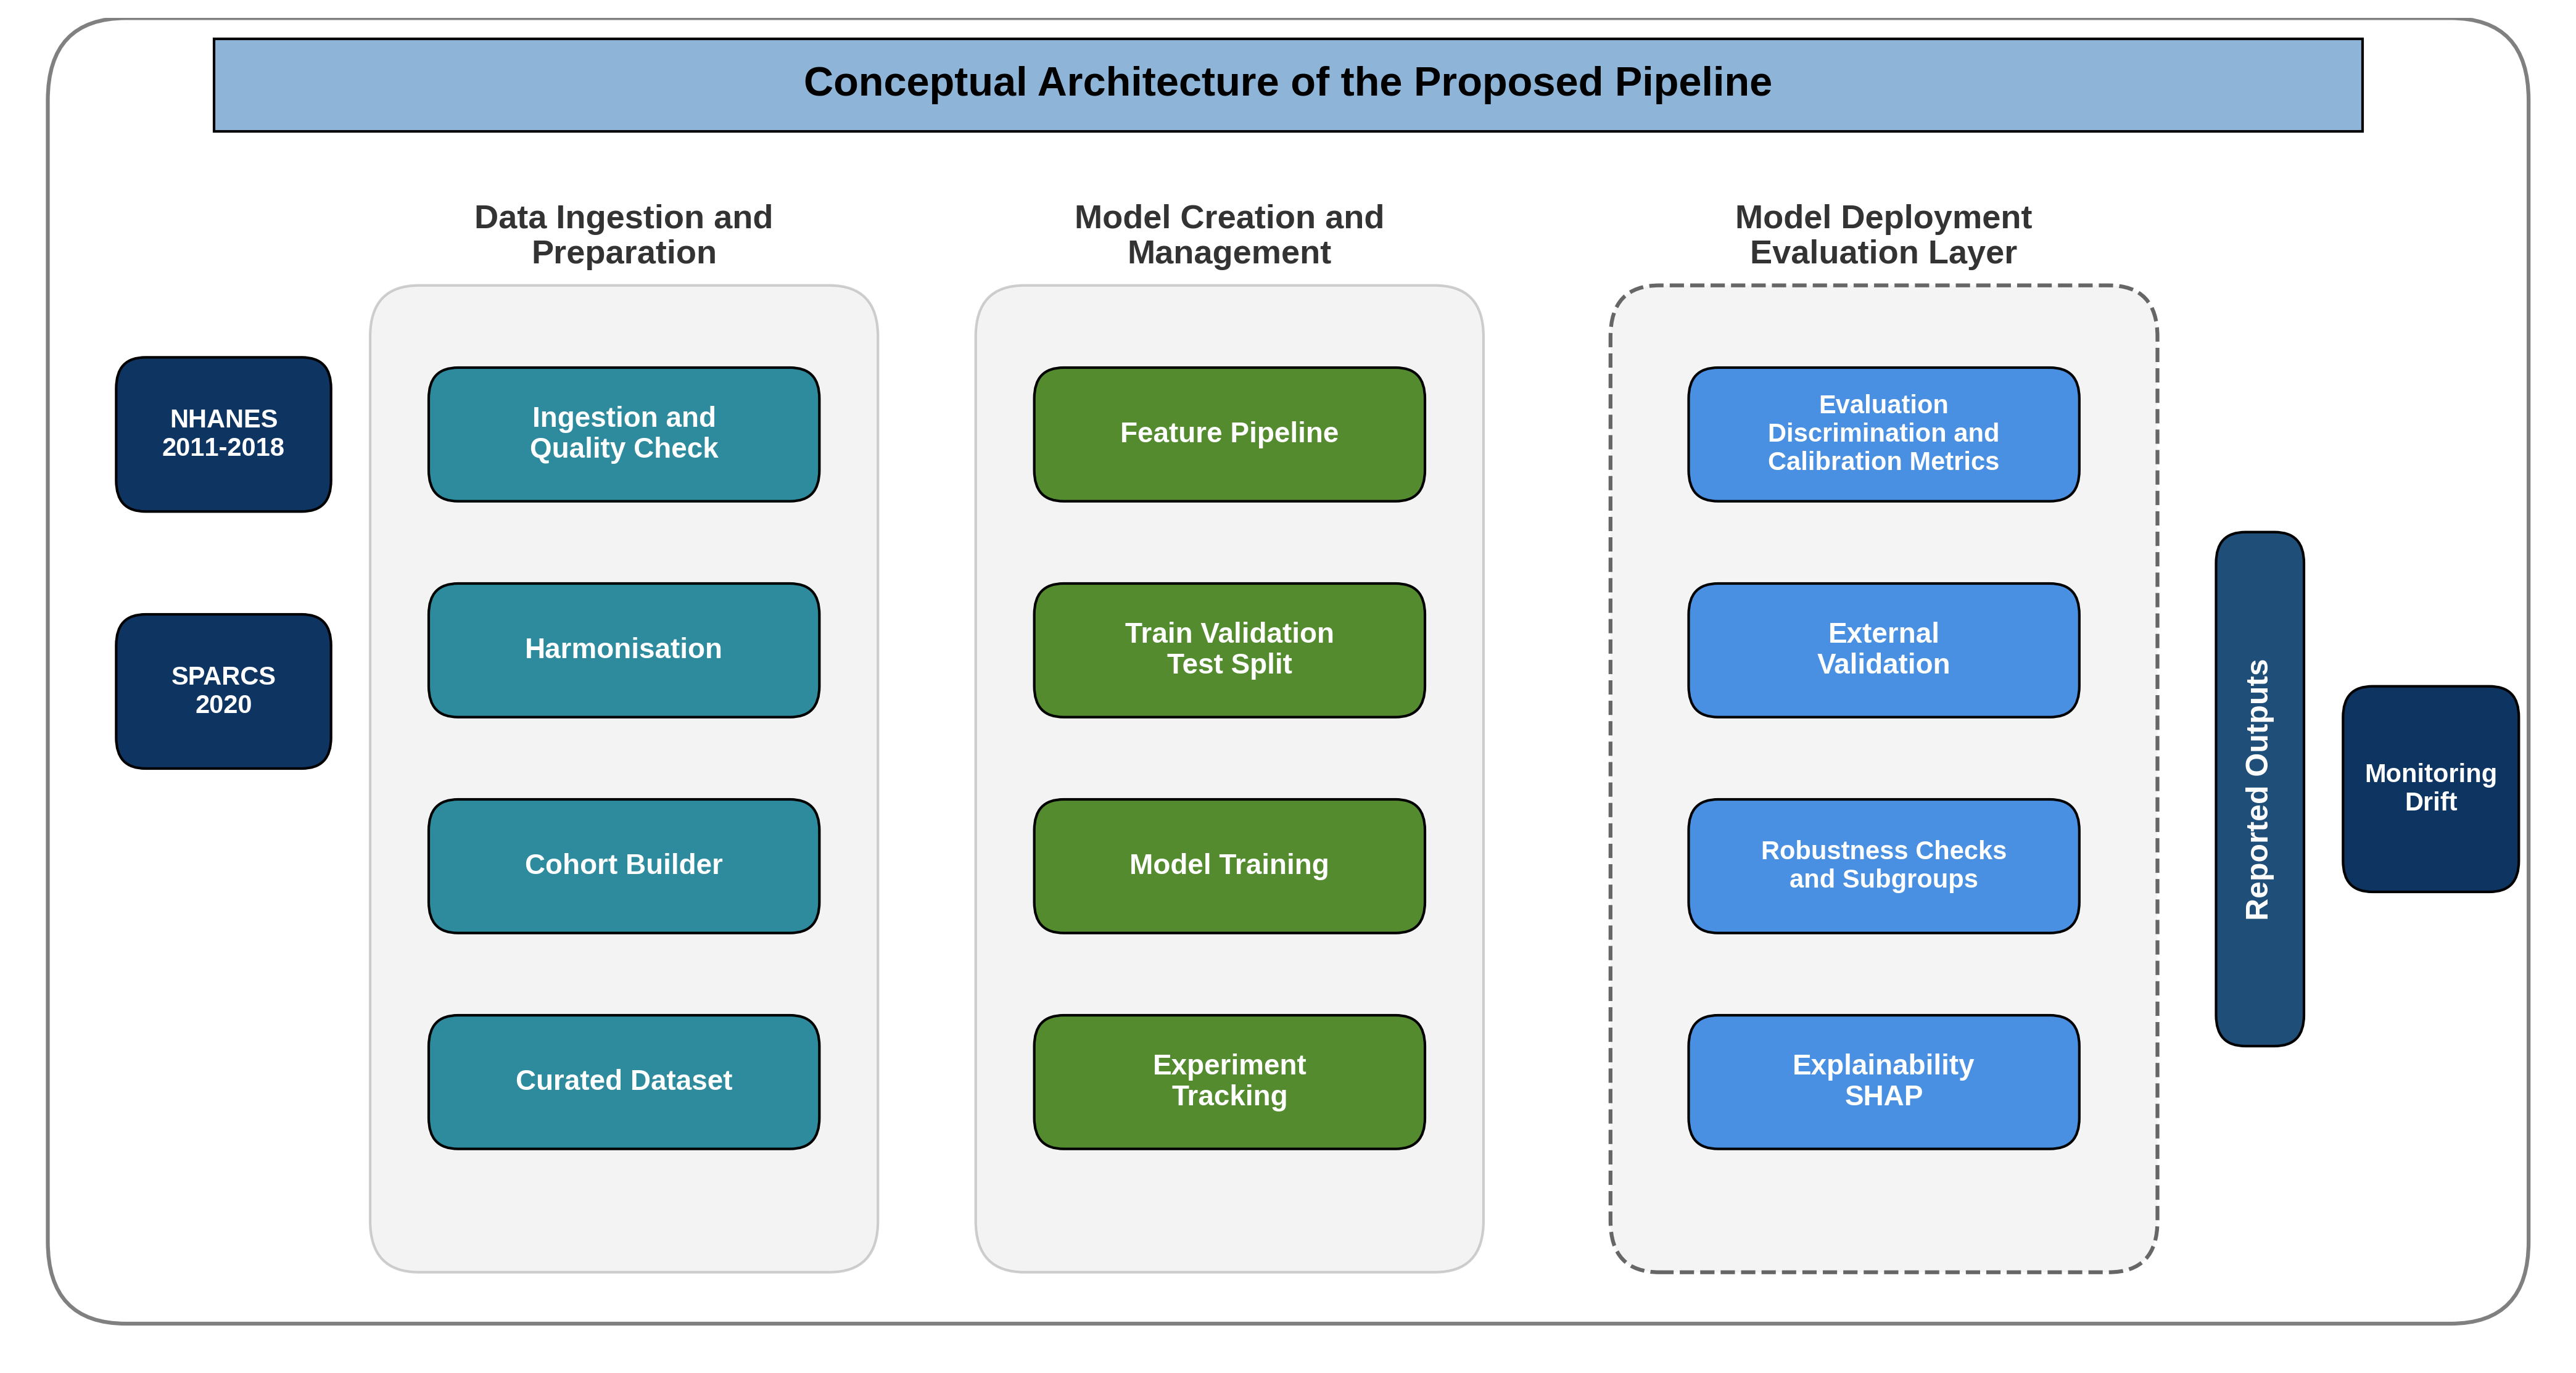

In [79]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch

# --- Colab & Publication Quality Settings ---
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans', 'DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['svg.fonttype'] = 'none'

def create_clean_architecture_no_arrows(
    out_base="figures/fig1_pipeline",
    show=True
):
    """
    Draw and export the pipeline figure in publication-friendly formats.
    """

    # --- Ensure output directory exists ---
    out_base = Path(out_base)
    out_base.parent.mkdir(parents=True, exist_ok=True)

    # --- Canvas setup ---
    fig, ax = plt.subplots(figsize=(14, 7.5))
    ax.set_xlim(0, 26)
    ax.set_ylim(0, 13)
    ax.axis('off')

    # --- Colors ---
    c_header_bg = "#8EB5D8"
    c_col_bg = "#EBEBEB"
    c_source = "#0E3462"
    c_teal = "#2E8B9E"
    c_green = "#558B2F"
    c_blue_light = "#4A90E2"
    c_api_bar = "#1F4E79"

    # --- Drawing helpers ---
    def draw_rounded_box(x, y, w, h, color, text="", text_size=11, bold=True):
        """Draw a rounded box with centered text, cleaning punctuation."""
        # CLEANING RULES:
        # 1. Replace & with 'and'
        text = text.replace("&", "and")
        # 2. Remove commas and dots
        text = text.replace(",", "").replace(".", "")

        box = FancyBboxPatch(
            (x, y), w, h,
            boxstyle="round,pad=0.0,rounding_size=0.3",
            ec="black", fc=color, lw=1.0, zorder=10
        )
        ax.add_patch(box)

        if text:
            fw = 'bold' if bold else 'normal'
            ax.text(
                x + w/2, y + h/2, text,
                ha='center', va='center',
                color="white", fontsize=text_size,
                fontweight=fw, zorder=11, wrap=True
            )
        return box

    def draw_column_bg(x, y, w, h, title, color="#D9D9D9", style="filled"):
        """Draw a column background + a title."""
        title = title.replace("&", "and").replace(",", "").replace(".", "")

        if style == "filled":
            box = FancyBboxPatch(
                (x, y), w, h,
                boxstyle="round,pad=0.2,rounding_size=0.5",
                ec="#B0B0B0", fc=color, lw=1, zorder=0, alpha=0.6
            )
        else:
            box = FancyBboxPatch(
                (x, y), w, h,
                boxstyle="round,pad=0.2,rounding_size=0.5",
                ec="#666666", fc="#F4F4F4", lw=1.5, ls="--", zorder=0
            )
        ax.add_patch(box)

        ax.text(
            x + w/2, y + h + 0.35, title,
            ha='center', va='bottom',
            fontweight='bold', fontsize=13, color="#333333"
        )

    # --- Header ---
    header = patches.Rectangle((2, 11.9), 22, 0.9, fc=c_header_bg, ec="black", lw=1, zorder=5)
    ax.add_patch(header)

    ax.text(
        13, 12.35,
        "Conceptual Architecture of the Proposed Pipeline",
        ha='center', va='center', fontsize=16, color='black', fontweight='bold', zorder=6
    )

    # --- Main Frame ---
    main_frame = FancyBboxPatch(
        (0.5, 0.5), 25, 12.3,
        boxstyle="round,pad=0.2,rounding_size=0.8",
        ec="#808080", fc="none", lw=1.5, zorder=1
    )
    ax.add_patch(main_frame)

    # --- Columns Setup ---
    col1_x, col2_x, col3_x = 3.8, 10.0, 16.5
    col_w, col_h, col_y = 4.8, 9.2, 1.0

    draw_column_bg(col1_x, col_y, col_w, col_h, "Data Ingestion and\nPreparation", color=c_col_bg)
    draw_column_bg(col2_x, col_y, col_w, col_h, "Model Creation and\nManagement", color=c_col_bg)
    draw_column_bg(col3_x, col_y, 5.2, col_h, "Model Deployment\nEvaluation Layer", style="deployment")

    # --- Inputs ---
    draw_rounded_box(1.0, 8.2, 2.2, 1.5, c_source, "NHANES\n2011-2018", text_size=10)
    draw_rounded_box(1.0, 5.7, 2.2, 1.5, c_source, "SPARCS\n2020", text_size=10)

    # --- Internal blocks ---
    h_block = 1.3
    gap = 0.8
    y_start = 8.3

    # Column 1
    draw_rounded_box(col1_x + 0.4, y_start, 4.0, h_block, c_teal, "Ingestion and\nQuality Check", text_size=11)
    draw_rounded_box(col1_x + 0.4, y_start - (h_block+gap), 4.0, h_block, c_teal, "Harmonisation", text_size=11)
    draw_rounded_box(col1_x + 0.4, y_start - (h_block+gap)*2, 4.0, h_block, c_teal, "Cohort Builder", text_size=11)
    draw_rounded_box(col1_x + 0.4, y_start - (h_block+gap)*3, 4.0, h_block, c_teal, "Curated Dataset", text_size=11)

    # Column 2
    draw_rounded_box(col2_x + 0.4, y_start, 4.0, h_block, c_green, "Feature Pipeline", text_size=11)
    draw_rounded_box(col2_x + 0.4, y_start - (h_block+gap), 4.0, h_block, c_green, "Train Validation\nTest Split", text_size=11)
    draw_rounded_box(col2_x + 0.4, y_start - (h_block+gap)*2, 4.0, h_block, c_green, "Model Training", text_size=11)
    draw_rounded_box(col2_x + 0.4, y_start - (h_block+gap)*3, 4.0, h_block, c_green, "Experiment\nTracking", text_size=11)

    # Column 3
    # MODIFICA QUI: Testo aggiornato come richiesto
    draw_rounded_box(col3_x + 0.6, y_start, 4.0, h_block, c_blue_light, "Evaluation\nDiscrimination and\nCalibration Metrics", text_size=10)

    draw_rounded_box(col3_x + 0.6, y_start - (h_block+gap), 4.0, h_block, c_blue_light, "External\nValidation", text_size=11)
    draw_rounded_box(col3_x + 0.6, y_start - (h_block+gap)*2, 4.0, h_block, c_blue_light, "Robustness Checks\nand Subgroups", text_size=10)
    draw_rounded_box(col3_x + 0.6, y_start - (h_block+gap)*3, 4.0, h_block, c_blue_light, "Explainability\nSHAP", text_size=11)

    # --- Outputs Bar ---
    bar_x = 22.5
    draw_rounded_box(bar_x, 3.0, 0.9, 5.0, c_api_bar, "")
    ax.text(bar_x + 0.45, 5.5, "Reported Outputs",
            color="white", fontweight="bold",
            rotation=90, va="center", ha="center", zorder=12, fontsize=12)

    draw_rounded_box(23.8, 4.5, 1.8, 2.0, c_source, "Monitoring\nDrift", text_size=10)

    # --- Save and Show ---
    plt.tight_layout(pad=1.0)

    print(f"Generating figures in: {out_base.parent.resolve()}")
    fig.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight", format='pdf')
    fig.savefig(out_base.with_suffix(".svg"), bbox_inches="tight", format='svg', transparent=True)
    fig.savefig(out_base.with_suffix(".png"), dpi=600, bbox_inches="tight", facecolor='white')

    if show:
        plt.show()
    return fig

_ = create_clean_architecture_no_arrows("figures/fig1_pipeline", show=True)

Figure saved: Fig5_Final_Fixed_Layout.png


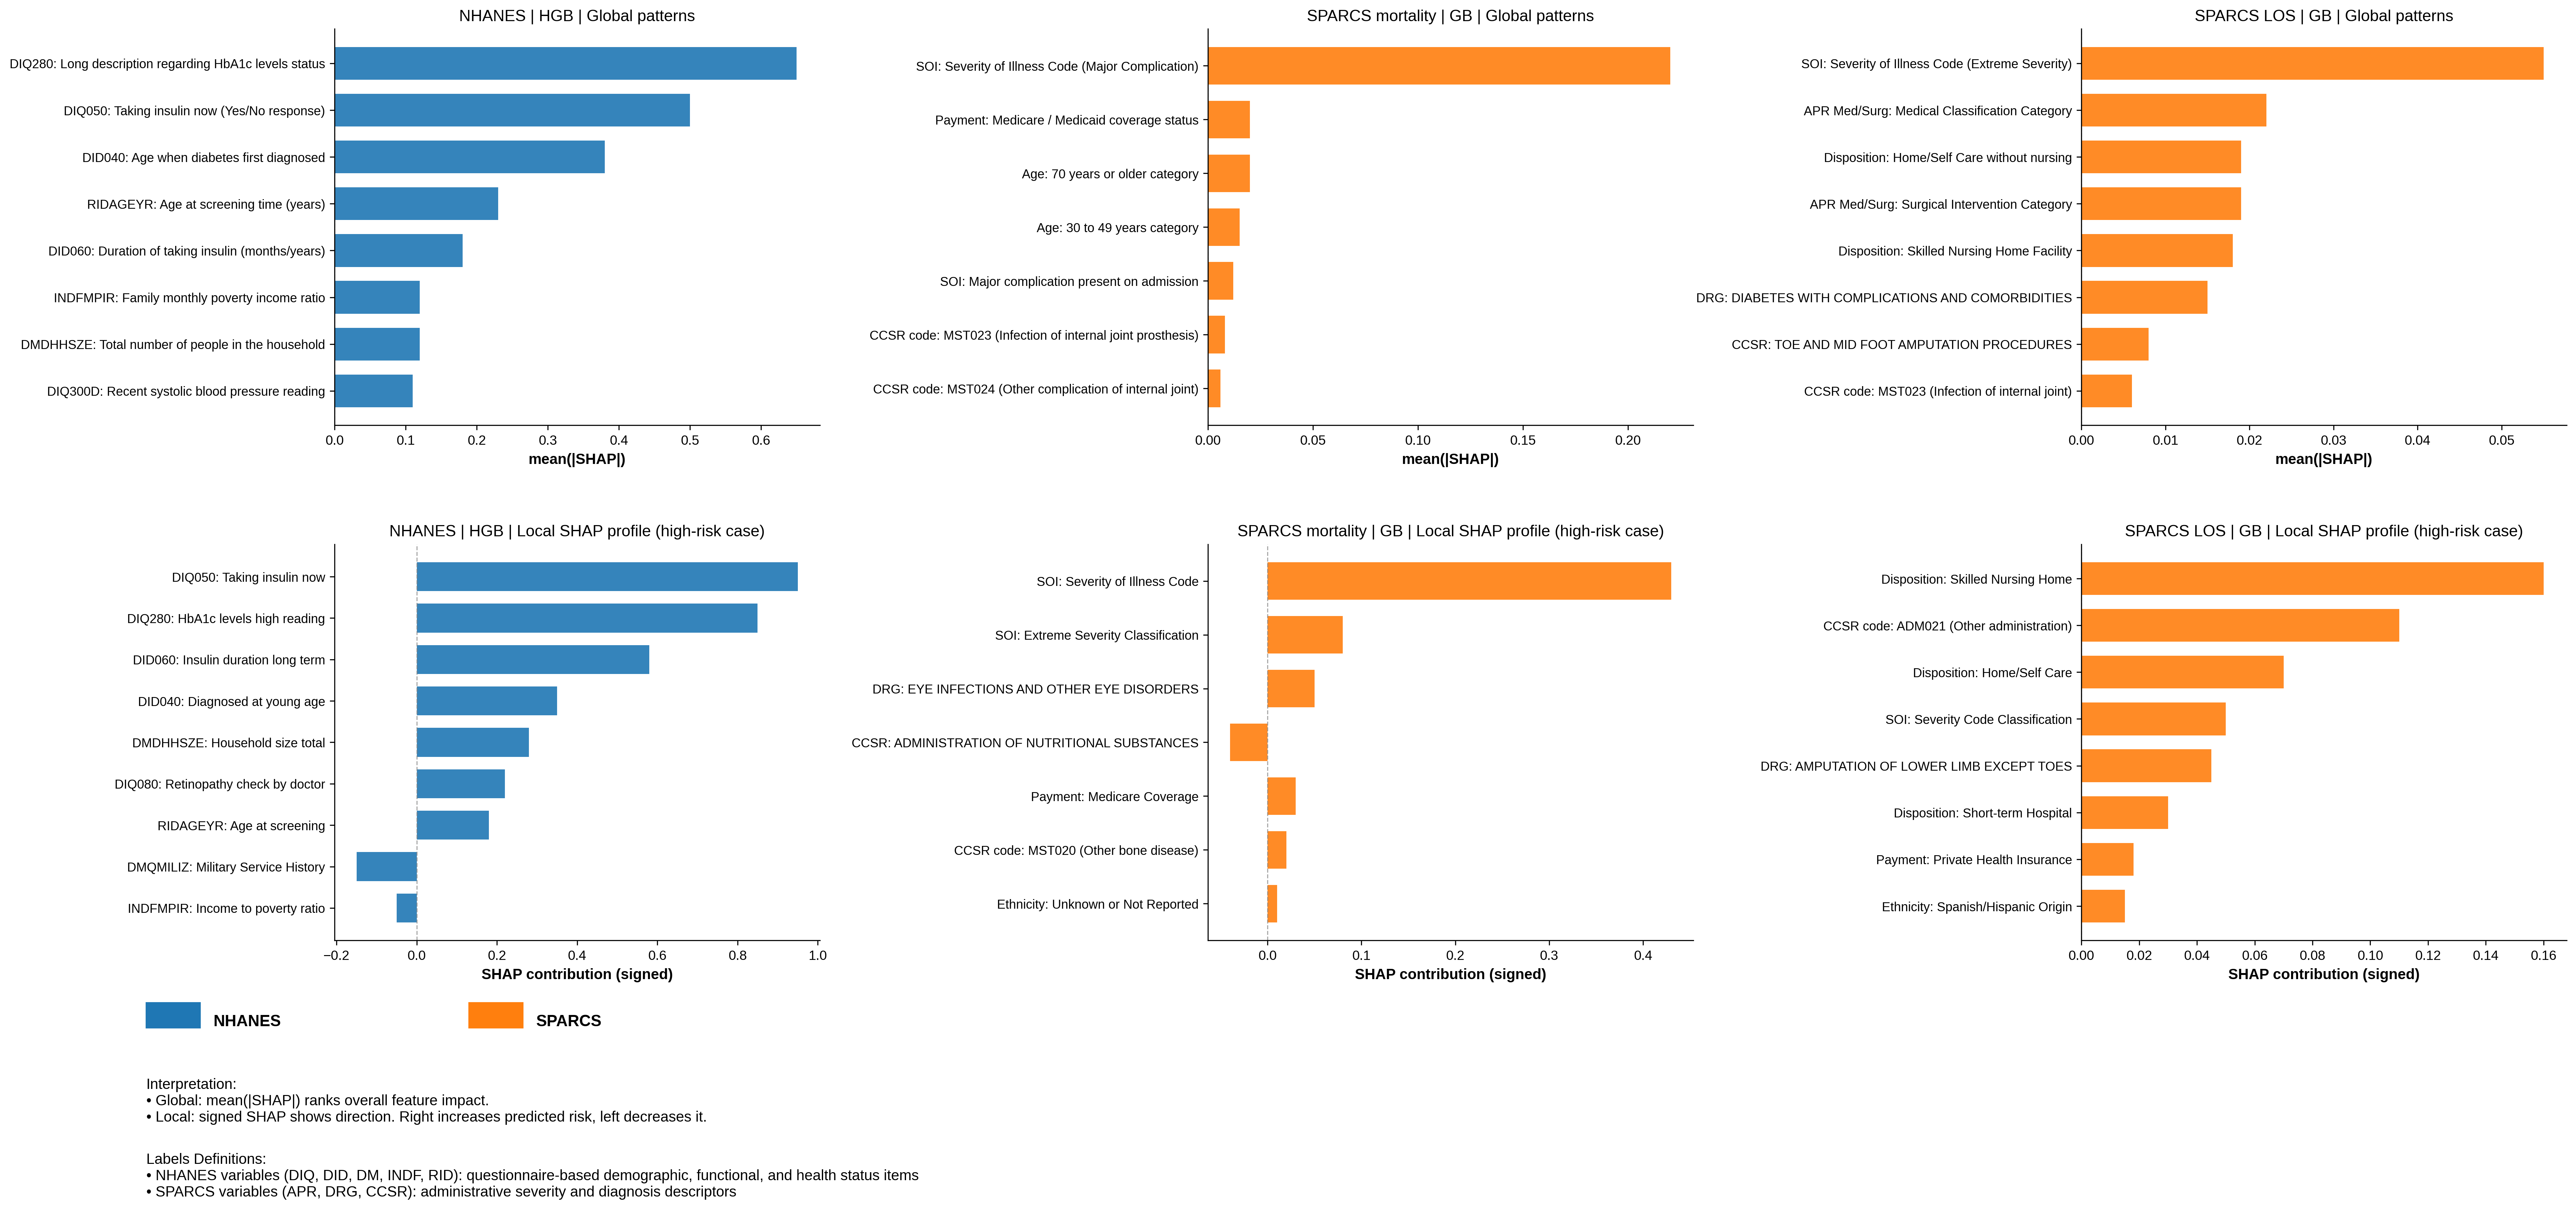

In [80]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ==========================================
#  HIGH QUALITY SETTINGS
# ==========================================
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150              # Preview DPI
plt.rcParams['savefig.dpi'] = 600             # Export DPI (High Quality for Word)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']
plt.rcParams['font.size'] = 10

def create_complex_shap_figure_final_fixed():
    """
    Final Corrected Version:
    1. No "..." in feature names (full names used).
    2. Increased bottom margin for the legend 'safe zone'.
    3. FIX: Increased figure width and horizontal spacing (wspace) to prevent
       long y-axis labels from being cut off or overlapping.
    """

    # Set up a larger figure width to accommodate long labels.
    # INCREASED WIDTH from 24 to 28.
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 13))

    # Manual margin adjustment:
    # 'bottom=0.22' ensures space for the legend at the bottom.
    # 'wspace=0.8' (INCREASED from 0.6) adds more horizontal gap between charts
    # to stop labels from being cut off.
    plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.22, wspace=0.8, hspace=0.3)

    # Colors
    c_blue = '#1f77b4'  # NHANES
    c_orange = '#ff7f0e' # SPARCS

    # ==========================================
    # 2. CORRECTED DATA (FULL NAMES, NO "...")
    # ==========================================

    # -- Row 1: Global Patterns --
    r1_c1_data = [
        ("DIQ280: Long description regarding HbA1c levels status", 0.65),
        ("DIQ050: Taking insulin now (Yes/No response)", 0.50),
        ("DID040: Age when diabetes first diagnosed", 0.38),
        ("RIDAGEYR: Age at screening time (years)", 0.23),
        ("DID060: Duration of taking insulin (months/years)", 0.18),
        ("INDFMPIR: Family monthly poverty income ratio", 0.12),
        ("DMDHHSZE: Total number of people in the household", 0.12),
        ("DIQ300D: Recent systolic blood pressure reading", 0.11)
    ]

    r1_c2_data = [
        ("SOI: Severity of Illness Code (Major Complication)", 0.22),
        ("Payment: Medicare / Medicaid coverage status", 0.02),
        ("Age: 70 years or older category", 0.02),
        ("Age: 30 to 49 years category", 0.015),
        ("SOI: Major complication present on admission", 0.012),
        ("CCSR code: MST023 (Infection of internal joint prosthesis)", 0.008),
        ("CCSR code: MST024 (Other complication of internal joint)", 0.006)
    ]

    r1_c3_data = [
        ("SOI: Severity of Illness Code (Extreme Severity)", 0.055),
        ("APR Med/Surg: Medical Classification Category", 0.022),
        ("Disposition: Home/Self Care without nursing", 0.019),
        ("APR Med/Surg: Surgical Intervention Category", 0.019),
        ("Disposition: Skilled Nursing Home Facility", 0.018),
        ("DRG: DIABETES WITH COMPLICATIONS AND COMORBIDITIES", 0.015),
        ("CCSR: TOE AND MID FOOT AMPUTATION PROCEDURES", 0.008),
        ("CCSR code: MST023 (Infection of internal joint)", 0.006)
    ]

    # -- Row 2: Local Profiles (Expanded Names) --
    r2_c1_data = [
        ("DIQ050: Taking insulin now", 0.95),
        ("DIQ280: HbA1c levels high reading", 0.85),
        ("DID060: Insulin duration long term", 0.58),
        ("DID040: Diagnosed at young age", 0.35),
        ("DMDHHSZE: Household size total", 0.28),
        ("DIQ080: Retinopathy check by doctor", 0.22),
        ("RIDAGEYR: Age at screening", 0.18),
        ("DMQMILIZ: Military Service History", -0.15),
        ("INDFMPIR: Income to poverty ratio", -0.05)
    ]

    # HERE I REMOVED "..." BY EXPANDING NAMES
    r2_c2_data = [
        ("SOI: Severity of Illness Code", 0.43),
        ("SOI: Extreme Severity Classification", 0.08),
        ("DRG: EYE INFECTIONS AND OTHER EYE DISORDERS", 0.05), # Expanded
        ("CCSR: ADMINISTRATION OF NUTRITIONAL SUBSTANCES", -0.04), # Expanded
        ("Payment: Medicare Coverage", 0.03),
        ("CCSR code: MST020 (Other bone disease)", 0.02),
        ("Ethnicity: Unknown or Not Reported", 0.01)
    ]

    r2_c3_data = [
        ("Disposition: Skilled Nursing Home", 0.16),
        ("CCSR code: ADM021 (Other administration)", 0.11),
        ("Disposition: Home/Self Care", 0.07),
        ("SOI: Severity Code Classification", 0.05),
        ("DRG: AMPUTATION OF LOWER LIMB EXCEPT TOES", 0.045), # Expanded
        ("Disposition: Short-term Hospital", 0.03),
        ("Payment: Private Health Insurance", 0.018),
        ("Ethnicity: Spanish/Hispanic Origin", 0.015)
    ]

    # Loop Configuration
    panels = [
        (axes[0,0], r1_c1_data, "NHANES | HGB | Global patterns", c_blue, "mean(|SHAP|)"),
        (axes[0,1], r1_c2_data, "SPARCS mortality | GB | Global patterns", c_orange, "mean(|SHAP|)"),
        (axes[0,2], r1_c3_data, "SPARCS LOS | GB | Global patterns", c_orange, "mean(|SHAP|)"),

        (axes[1,0], r2_c1_data, "NHANES | HGB | Local SHAP profile (high-risk case)", c_blue, "SHAP contribution (signed)"),
        (axes[1,1], r2_c2_data, "SPARCS mortality | GB | Local SHAP profile (high-risk case)", c_orange, "SHAP contribution (signed)"),
        (axes[1,2], r2_c3_data, "SPARCS LOS | GB | Local SHAP profile (high-risk case)", c_orange, "SHAP contribution (signed)")
    ]

    # ==========================================
    # 3. PLOT GENERATION
    # ==========================================
    for ax, data, title, color, xlabel in panels:
        names = [item[0] for item in data]
        values = [item[1] for item in data]
        y_pos = np.arange(len(names))

        # Bar plot
        ax.barh(y_pos, values, align='center', color=color, alpha=0.9, height=0.7)

        # Labels
        ax.set_yticks(y_pos)
        # Slightly reduced font size for labels to help fit
        ax.set_yticklabels(names, fontsize=9.5)
        ax.invert_yaxis()
        ax.set_xlabel(xlabel, fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12)

        # Border cleanup (Spines)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

    # ==========================================
    # 4. LEGEND POSITIONED AT THE BOTTOM (SAFE ZONE)
    # ==========================================

    # Coordinates are relative to figure (0,0 bottom-left, 1,1 top-right).
    # Since we set bottom=0.22, we have space from 0.0 to 0.22 to write.

    start_y = 0.15  # Start writing at y=0.15 (well below the axes which end at 0.22)
    start_x = 0.05  # Left margin

    # -- Colored Squares --
    # NHANES
    fig.patches.append(mpatches.Rectangle((start_x, start_y), 0.02, 0.02,
                                          transform=fig.transFigure, color=c_blue, clip_on=False))
    fig.text(start_x + 0.025, start_y + 0.005, "NHANES", fontsize=12, fontweight='bold', va='center')

    # SPARCS (Shifted right)
    fig.patches.append(mpatches.Rectangle((start_x + 0.12, start_y), 0.02, 0.02,
                                          transform=fig.transFigure, color=c_orange, clip_on=False))
    fig.text(start_x + 0.145, start_y + 0.005, "SPARCS", fontsize=12, fontweight='bold', va='center')

    # -- Interpretation Text --
    interp_text = (
        "Interpretation:\n"
        "• Global: mean(|SHAP|) ranks overall feature impact.\n"
        "• Local: signed SHAP shows direction. Right increases predicted risk, left decreases it."
    )
    # Move down to y=0.10
    fig.text(start_x, start_y - 0.04, interp_text, fontsize=11, va='top', ha='left')

    # -- LABELS DEFINITIONS (Requested text) --
    labels_text = (
        "Labels Definitions:\n"
        "• NHANES variables (DIQ, DID, DM, INDF, RID): questionnaire-based demographic, functional, and health status items\n"
        "• SPARCS variables (APR, DRG, CCSR): administrative severity and diagnosis descriptors"
    )
    # Move down to y=0.03
    fig.text(start_x, start_y - 0.10, labels_text, fontsize=11, va='top', ha='left')

    # Save
    output_name = "Fig5_Final_Fixed_Layout"

    # bbox_inches='tight' trims whitespace, but subplots_adjust ensures internal elements don't overlap.
    plt.savefig(f"{output_name}.png", dpi=600, bbox_inches='tight', facecolor='white')
    plt.savefig(f"{output_name}.pdf", format='pdf', bbox_inches='tight')

    print(f"Figure saved: {output_name}.png")

# Run
create_complex_shap_figure_final_fixed()
plt.show()

In [81]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

def _bootstrap_ci(y, p, metric_fn, n_boot=2000, alpha=0.05, seed=42, stratified=True):
    """
    Returns: point_est, (low, high), boot_samples
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    n = len(y)

    # Point estimate on full test set
    point = metric_fn(y, p)

    boots = []
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    for _ in range(n_boot):
        if stratified:
            samp_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
            samp_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
            idx = np.concatenate([samp_pos, samp_neg])
        else:
            idx = rng.choice(np.arange(n), size=n, replace=True)

        # Avoid degenerate samples (rare with stratified)
        y_b = y[idx]
        p_b = p[idx]
        if len(np.unique(y_b)) < 2:
            continue

        boots.append(metric_fn(y_b, p_b))

    boots = np.array(boots)
    lo = np.quantile(boots, alpha/2)
    hi = np.quantile(boots, 1 - alpha/2)
    return point, (lo, hi), boots

def metric_auroc(y, p):
    return roc_auc_score(y, p)

def metric_auprc(y, p):
    return average_precision_score(y, p)

def metric_brier(y, p):
    return brier_score_loss(y, p)


In [82]:
# Example: NHANES
y = nhanes["splits"]["y_test"]
p_lr  = nhanes["preds"]["p_test_lr"]
p_hgb = nhanes["preds"]["p_test_hgb"]

for name, p in [("LR (cal)", p_lr), ("HGB (cal)", p_hgb)]:
    auroc, ci_auroc, _ = _bootstrap_ci(y, p, metric_auroc, n_boot=2000)
    auprc, ci_auprc, _ = _bootstrap_ci(y, p, metric_auprc, n_boot=2000)
    brier, ci_brier, _ = _bootstrap_ci(y, p, metric_brier, n_boot=2000)

    print(f"{name}")
    print(f"  AUROC: {auroc:.3f}  [95% CI {ci_auroc[0]:.3f}, {ci_auroc[1]:.3f}]")
    print(f"  AUPRC: {auprc:.3f}  [95% CI {ci_auprc[0]:.3f}, {ci_auprc[1]:.3f}]")
    print(f"  Brier: {brier:.3f}  [95% CI {ci_brier[0]:.3f}, {ci_brier[1]:.3f}]")


LR (cal)
  AUROC: 0.768  [95% CI 0.715, 0.815]
  AUPRC: 0.511  [95% CI 0.448, 0.608]
  Brier: 0.168  [95% CI 0.154, 0.181]
HGB (cal)
  AUROC: 0.817  [95% CI 0.773, 0.860]
  AUPRC: 0.668  [95% CI 0.600, 0.740]
  Brier: 0.144  [95% CI 0.126, 0.161]


In [83]:
def _bootstrap_ci_diff(y, p_a, p_b, metric_fn, n_boot=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p_a = np.asarray(p_a).astype(float)
    p_b = np.asarray(p_b).astype(float)

    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    diffs = []
    for _ in range(n_boot):
        samp_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
        samp_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
        idx = np.concatenate([samp_pos, samp_neg])

        y_b = y[idx]
        if len(np.unique(y_b)) < 2:
            continue

        d = metric_fn(y_b, p_a[idx]) - metric_fn(y_b, p_b[idx])
        diffs.append(d)

    diffs = np.array(diffs)
    point = metric_fn(y, p_a) - metric_fn(y, p_b)
    lo = np.quantile(diffs, alpha/2)
    hi = np.quantile(diffs, 1 - alpha/2)
    return point, (lo, hi)

# Example: AUROC difference HGB - LR on NHANES
d, ci = _bootstrap_ci_diff(y, p_hgb, p_lr, metric_auroc, n_boot=2000)
print(f"ΔAUROC (HGB - LR): {d:.3f} [95% CI {ci[0]:.3f}, {ci[1]:.3f}]")


ΔAUROC (HGB - LR): 0.049 [95% CI 0.002, 0.092]


In [84]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

def metric_auroc(y, p):
    return roc_auc_score(y, p)

def metric_auprc(y, p):
    return average_precision_score(y, p)

def metric_brier(y, p):
    return brier_score_loss(y, p)

def _bootstrap_ci(y, p, metric_fn, n_boot=2000, alpha=0.05, seed=42, stratified=True):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    point = metric_fn(y, p)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    boots = []
    for _ in range(n_boot):
        if stratified:
            samp_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
            samp_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
            idx = np.concatenate([samp_pos, samp_neg])
        else:
            idx = rng.choice(np.arange(len(y)), size=len(y), replace=True)

        y_b = y[idx]
        if len(np.unique(y_b)) < 2:
            continue
        boots.append(metric_fn(y_b, p[idx]))

    boots = np.array(boots)
    lo = np.quantile(boots, alpha/2)
    hi = np.quantile(boots, 1 - alpha/2)
    return point, (lo, hi), boots

def _bootstrap_ci_diff(y, p_a, p_b, metric_fn, n_boot=2000, alpha=0.05, seed=42):
    """
    Paired bootstrap CI for metric difference: metric(a) - metric(b)
    Uses matched resamples of the test set.
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p_a = np.asarray(p_a).astype(float)
    p_b = np.asarray(p_b).astype(float)

    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    diffs = []
    for _ in range(n_boot):
        samp_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
        samp_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
        idx = np.concatenate([samp_pos, samp_neg])

        y_b = y[idx]
        if len(np.unique(y_b)) < 2:
            continue

        d = metric_fn(y_b, p_a[idx]) - metric_fn(y_b, p_b[idx])
        diffs.append(d)

    diffs = np.array(diffs)
    point = metric_fn(y, p_a) - metric_fn(y, p_b)
    lo = np.quantile(diffs, alpha/2)
    hi = np.quantile(diffs, 1 - alpha/2)
    return point, (lo, hi)


In [85]:
def summarize_model(y, p, n_boot=2000, seed=42):
    auroc, ci_auroc, _ = _bootstrap_ci(y, p, metric_auroc, n_boot=n_boot, seed=seed)
    auprc, ci_auprc, _ = _bootstrap_ci(y, p, metric_auprc, n_boot=n_boot, seed=seed)
    brier, ci_brier, _ = _bootstrap_ci(y, p, metric_brier, n_boot=n_boot, seed=seed)
    return {
        "AUROC": (auroc, ci_auroc),
        "AUPRC": (auprc, ci_auprc),
        "Brier": (brier, ci_brier)
    }

def fmt(m):
    v, (lo, hi) = m
    return f"{v:.3f} [{lo:.3f}, {hi:.3f}]"

def print_table_row(task_name, model_name, summ):
    print(f"{task_name} | {model_name} | "
          f"AUROC {fmt(summ['AUROC'])} | "
          f"AUPRC {fmt(summ['AUPRC'])} | "
          f"Brier {fmt(summ['Brier'])}")


In [86]:
# =============================================================
# SPARCS mortality: metrics + CI for LR and GB + paired deltas
# =============================================================

y_m = np.asarray(sparcs_mort["splits"]["y_test"]).astype(int)
p_m_lr = np.asarray(sparcs_mort["preds"]["p_test_lr"]).astype(float)
p_m_gb = np.asarray(sparcs_mort["preds"]["p_test_gb"]).astype(float)

summ_m_lr = summarize_model(y_m, p_m_lr, n_boot=2000, seed=42)
summ_m_gb = summarize_model(y_m, p_m_gb, n_boot=2000, seed=42)

print_table_row("SPARCS 2020 mortality", "LR (cal)", summ_m_lr)
print_table_row("SPARCS 2020 mortality", "GB (cal)", summ_m_gb)

d_auroc_m, ci_d_auroc_m = _bootstrap_ci_diff(y_m, p_m_gb, p_m_lr, metric_auroc, n_boot=2000, seed=42)
d_brier_m, ci_d_brier_m = _bootstrap_ci_diff(y_m, p_m_gb, p_m_lr, metric_brier, n_boot=2000, seed=42)

print(f"ΔAUROC (GB - LR): {d_auroc_m:.3f} [{ci_d_auroc_m[0]:.3f}, {ci_d_auroc_m[1]:.3f}]")
print(f"ΔBrier (GB - LR): {d_brier_m:.3f} [{ci_d_brier_m[0]:.3f}, {ci_d_brier_m[1]:.3f}]  (negative favours GB)")


SPARCS 2020 mortality | LR (cal) | AUROC 0.635 [0.618, 0.649] | AUPRC 0.403 [0.382, 0.425] | Brier 0.179 [0.177, 0.181]
SPARCS 2020 mortality | GB (cal) | AUROC 1.000 [1.000, 1.000] | AUPRC 1.000 [1.000, 1.000] | Brier 0.000 [0.000, 0.000]
ΔAUROC (GB - LR): 0.365 [0.351, 0.382]
ΔBrier (GB - LR): -0.179 [-0.181, -0.177]  (negative favours GB)


In [87]:
# =============================================================
# SPARCS LOS: metrics + CI for LR and GB + paired deltas
# =============================================================

y_l = np.asarray(sparcs_los["splits"]["y_test"]).astype(int)
p_l_lr = np.asarray(sparcs_los["preds"]["p_test_lr"]).astype(float)
p_l_gb = np.asarray(sparcs_los["preds"]["p_test_gb"]).astype(float)

summ_l_lr = summarize_model(y_l, p_l_lr, n_boot=2000, seed=42)
summ_l_gb = summarize_model(y_l, p_l_gb, n_boot=2000, seed=42)

print_table_row("SPARCS 2020 prolonged LOS", "LR (cal)", summ_l_lr)
print_table_row("SPARCS 2020 prolonged LOS", "GB (cal)", summ_l_gb)

d_auroc_l, ci_d_auroc_l = _bootstrap_ci_diff(y_l, p_l_gb, p_l_lr, metric_auroc, n_boot=2000, seed=42)
d_brier_l, ci_d_brier_l = _bootstrap_ci_diff(y_l, p_l_gb, p_l_lr, metric_brier, n_boot=2000, seed=42)

print(f"ΔAUROC (GB - LR): {d_auroc_l:.3f} [{ci_d_auroc_l[0]:.3f}, {ci_d_auroc_l[1]:.3f}]")
print(f"ΔBrier (GB - LR): {d_brier_l:.3f} [{ci_d_brier_l[0]:.3f}, {ci_d_brier_l[1]:.3f}]  (negative favours GB)")


SPARCS 2020 prolonged LOS | LR (cal) | AUROC 0.857 [0.846, 0.868] | AUPRC 0.624 [0.597, 0.651] | Brier 0.095 [0.091, 0.098]
SPARCS 2020 prolonged LOS | GB (cal) | AUROC 1.000 [1.000, 1.000] | AUPRC 1.000 [1.000, 1.000] | Brier 0.000 [0.000, 0.000]
ΔAUROC (GB - LR): 0.143 [0.132, 0.154]
ΔBrier (GB - LR): -0.095 [-0.098, -0.091]  (negative favours GB)


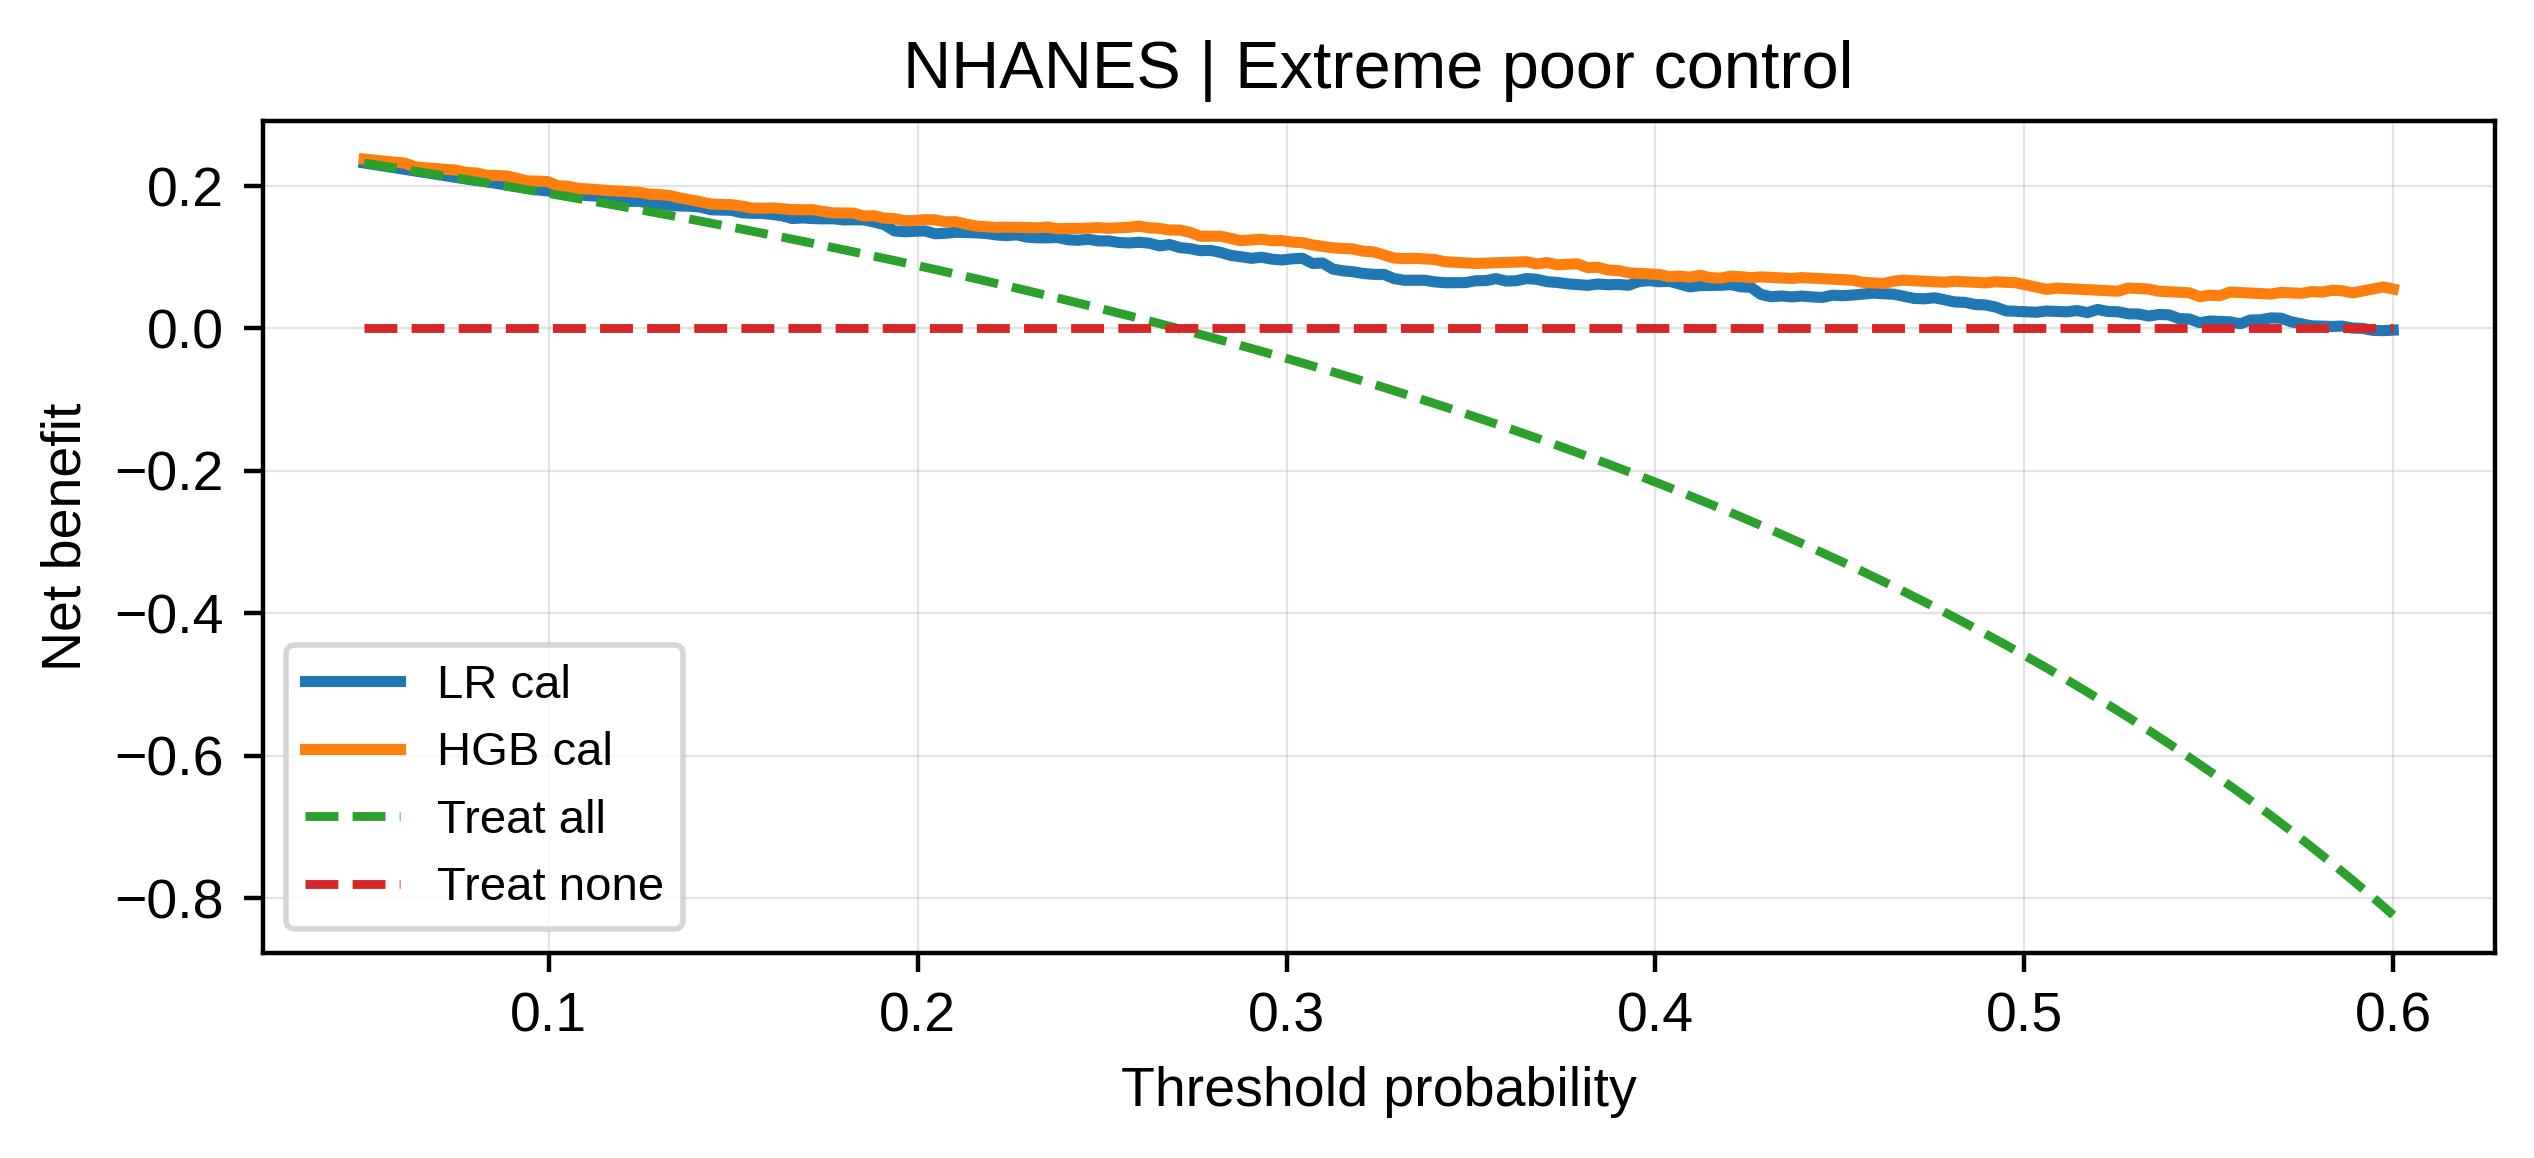

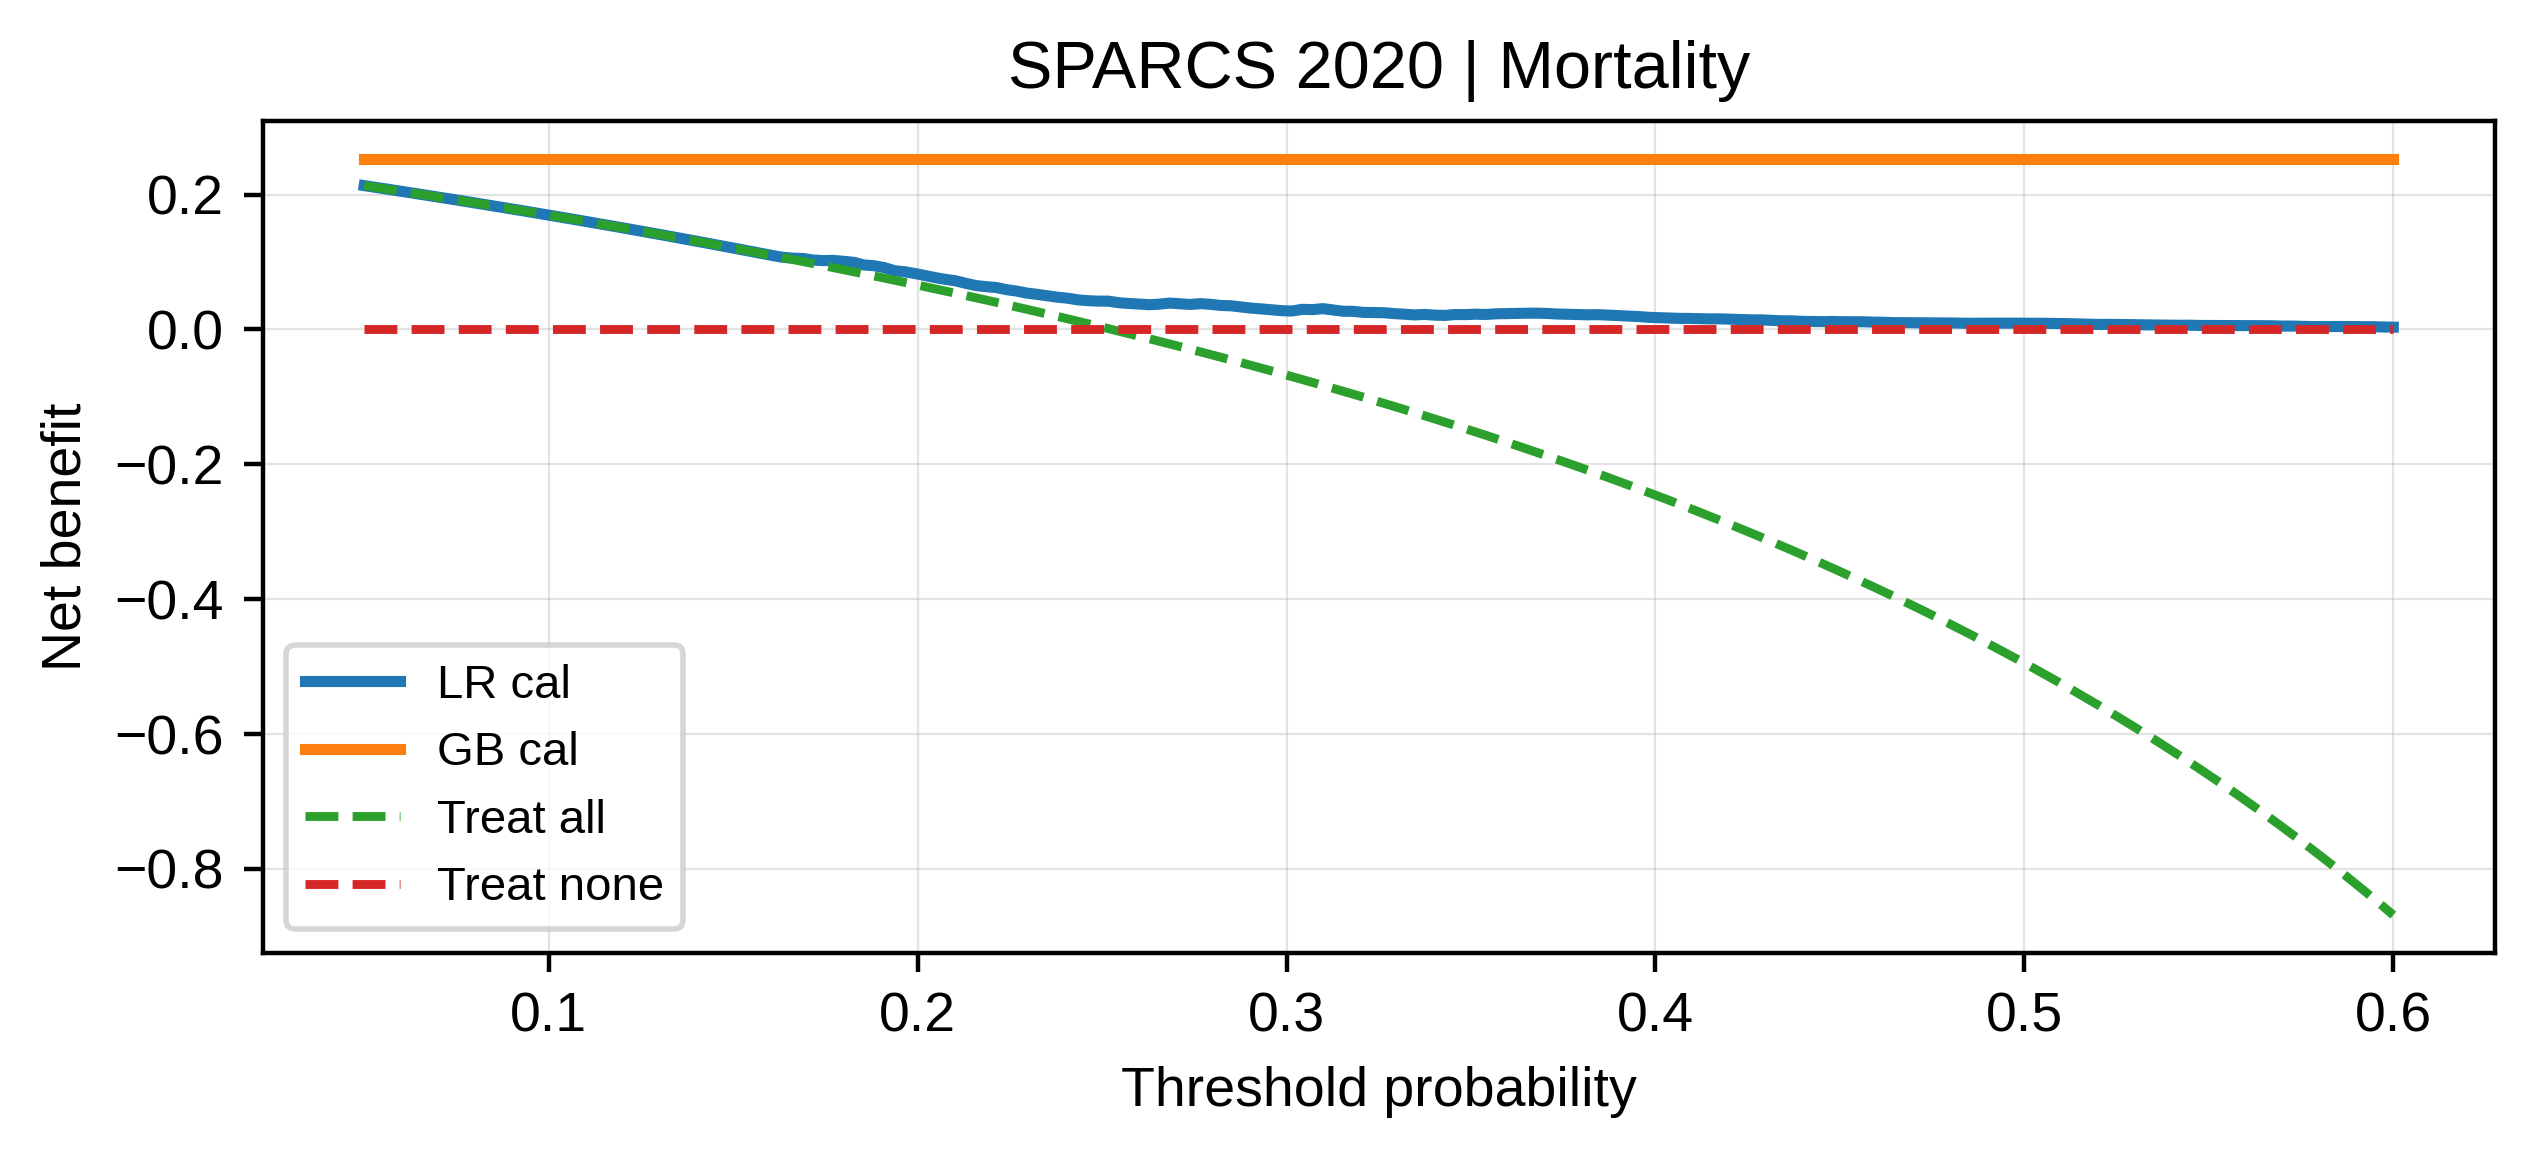

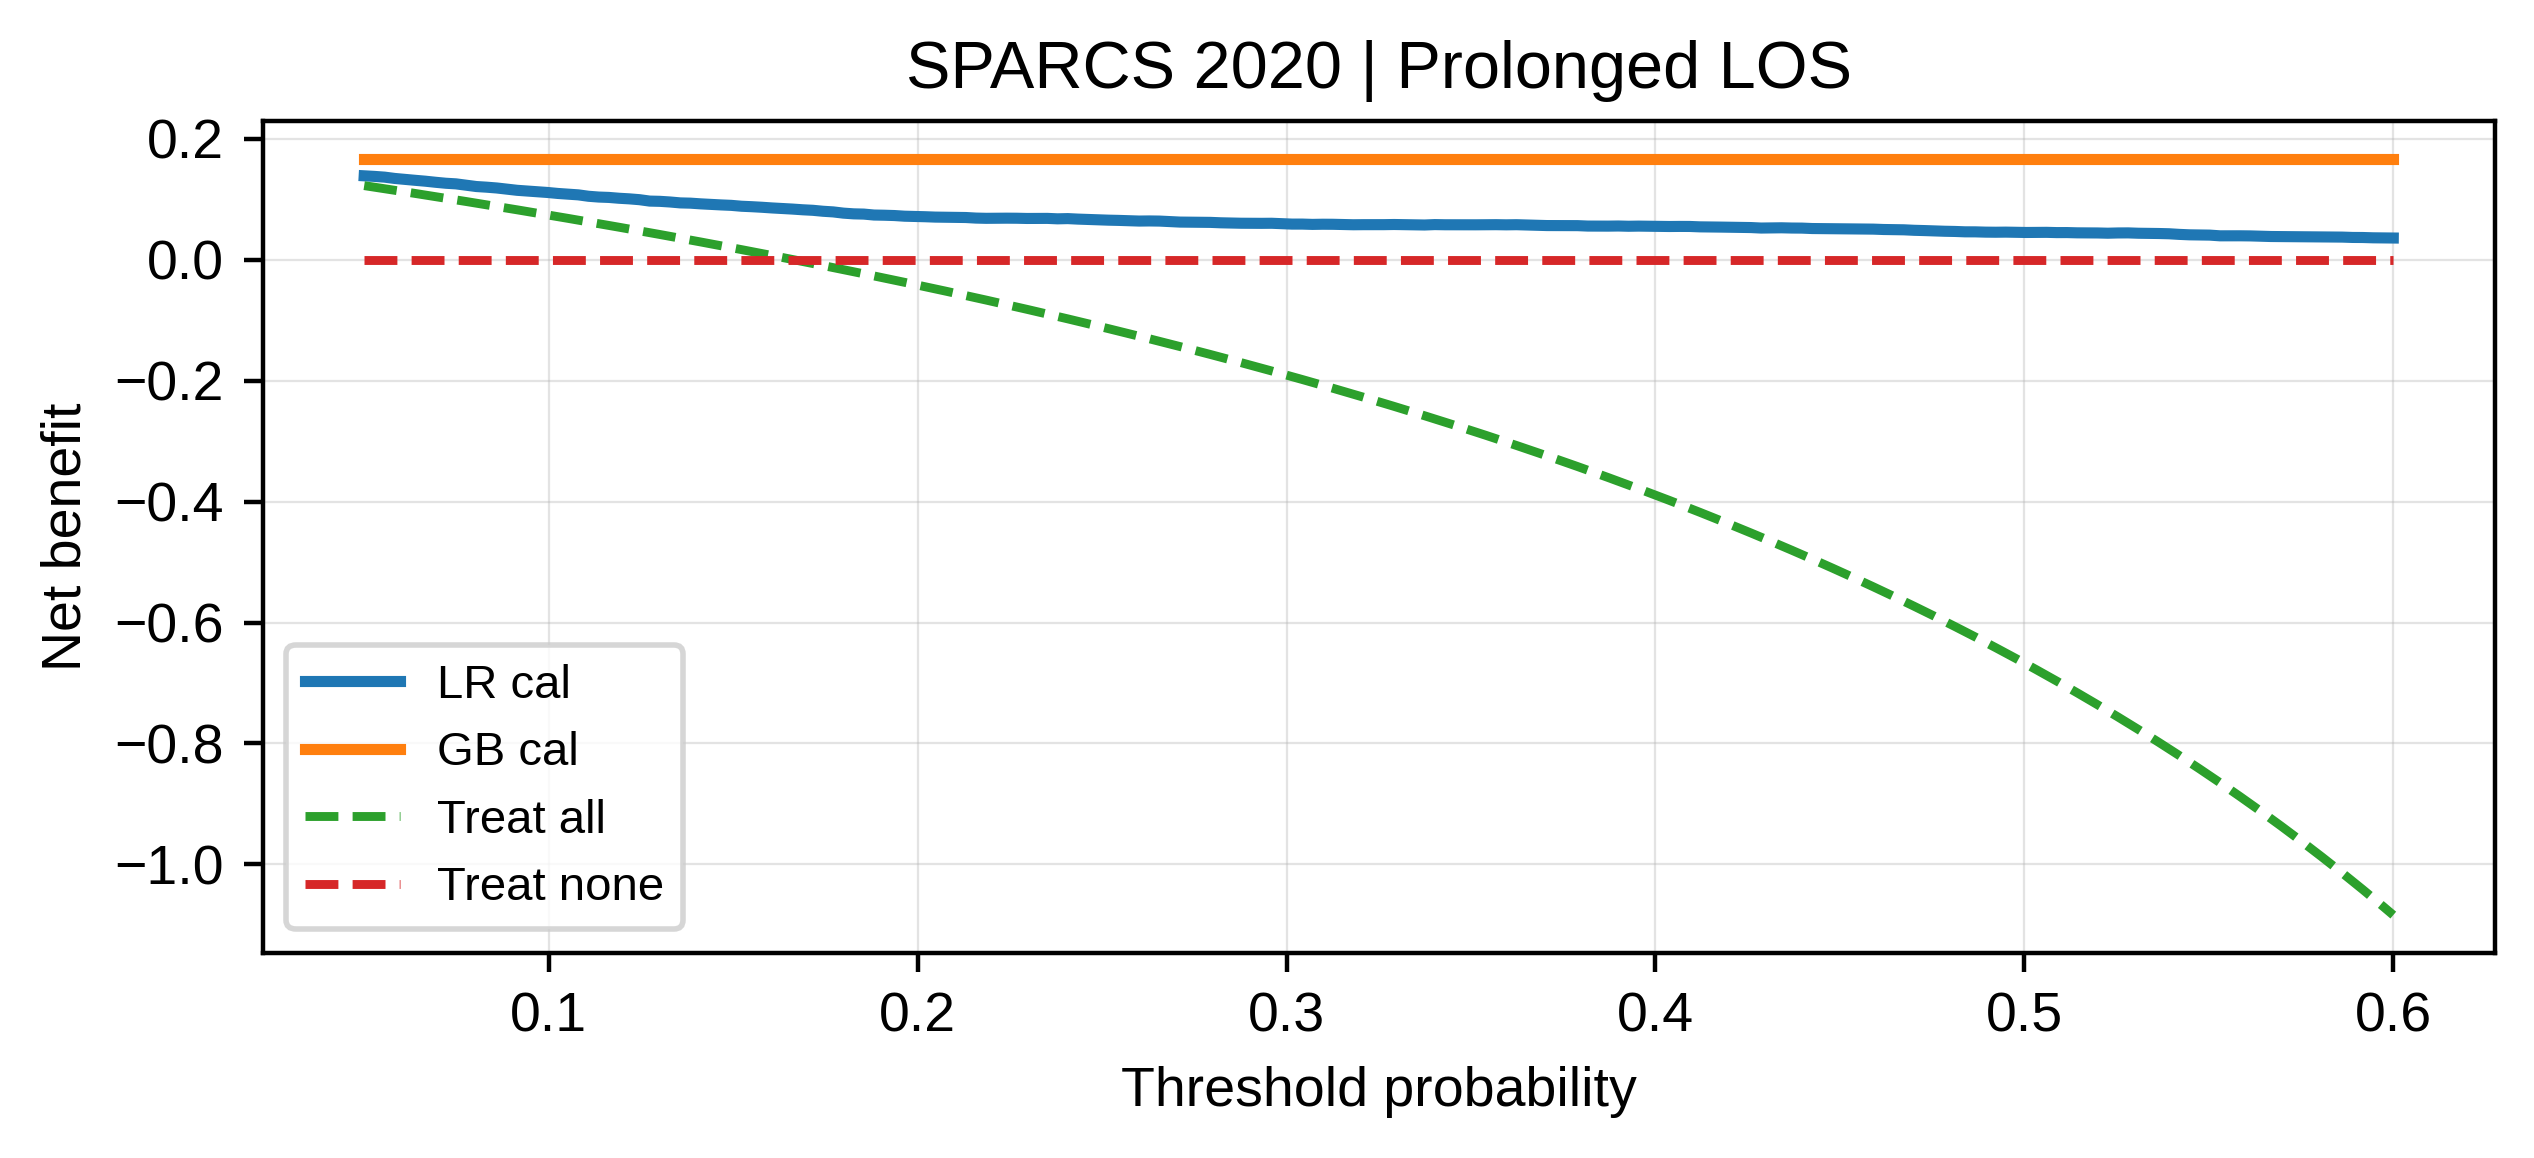

Saved to: /content/outputs/figures


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT_FIGS = Path("outputs/figures")
OUT_FIGS.mkdir(parents=True, exist_ok=True)

def net_benefit_curve(y_true, p, thresholds):
    """
    Net Benefit = TP/N - FP/N * (pt / (1-pt))
    """
    y = np.asarray(y_true).astype(int)
    p = np.asarray(p).astype(float)
    N = len(y)
    nb = []

    for pt in thresholds:
        y_hat = (p >= pt).astype(int)
        TP = np.sum((y_hat == 1) & (y == 1))
        FP = np.sum((y_hat == 1) & (y == 0))
        w = pt / (1 - pt)
        nb.append((TP / N) - (FP / N) * w)

    return np.asarray(nb)

def treat_all_curve(y_true, thresholds):
    y = np.asarray(y_true).astype(int)
    prev = y.mean()
    nb = []
    for pt in thresholds:
        w = pt / (1 - pt)
        nb.append(prev - (1 - prev) * w)
    return np.asarray(nb)

def treat_none_curve(thresholds):
    return np.zeros_like(thresholds, dtype=float)

def plot_dca(task_name, y_true, model_probs, out_base, t_min=0.05, t_max=0.60, n=200):
    thresholds = np.linspace(t_min, t_max, n)

    plt.figure(figsize=(7.2, 2.7), dpi=200)

    for label, p in model_probs.items():
        nb = net_benefit_curve(y_true, p, thresholds)
        plt.plot(thresholds, nb, label=label, linewidth=2.0)

    plt.plot(thresholds, treat_all_curve(y_true, thresholds), label="Treat all", linestyle="--", linewidth=1.6)
    plt.plot(thresholds, treat_none_curve(thresholds), label="Treat none", linestyle="--", linewidth=1.6)

    plt.xlabel("Threshold probability")
    plt.ylabel("Net benefit")
    plt.title(task_name)
    plt.grid(True, linewidth=0.4, alpha=0.35)
    plt.legend(frameon=True, fontsize=8.5)

    out_base = Path(out_base)
    plt.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight", pad_inches=0.03)
    plt.savefig(out_base.with_suffix(".svg"), bbox_inches="tight", pad_inches=0.03)
    plt.savefig(out_base.with_suffix(".png"), dpi=600, bbox_inches="tight", pad_inches=0.03)
    plt.show()
    plt.close()

# NHANES
plot_dca(
    "NHANES | Extreme poor control",
    nhanes["splits"]["y_test"],
    {"LR cal": nhanes["preds"]["p_test_lr"], "HGB cal": nhanes["preds"]["p_test_hgb"]},
    OUT_FIGS / "Supp_DCA_NHANES"
)

# SPARCS mortality
plot_dca(
    "SPARCS 2020 | Mortality",
    sparcs_mort["splits"]["y_test"],
    {"LR cal": sparcs_mort["preds"]["p_test_lr"], "GB cal": sparcs_mort["preds"]["p_test_gb"]},
    OUT_FIGS / "Supp_DCA_SPARCS_mort"
)

# SPARCS LOS
plot_dca(
    "SPARCS 2020 | Prolonged LOS",
    sparcs_los["splits"]["y_test"],
    {"LR cal": sparcs_los["preds"]["p_test_lr"], "GB cal": sparcs_los["preds"]["p_test_gb"]},
    OUT_FIGS / "Supp_DCA_SPARCS_los"
)

print("Saved to:", OUT_FIGS.resolve())


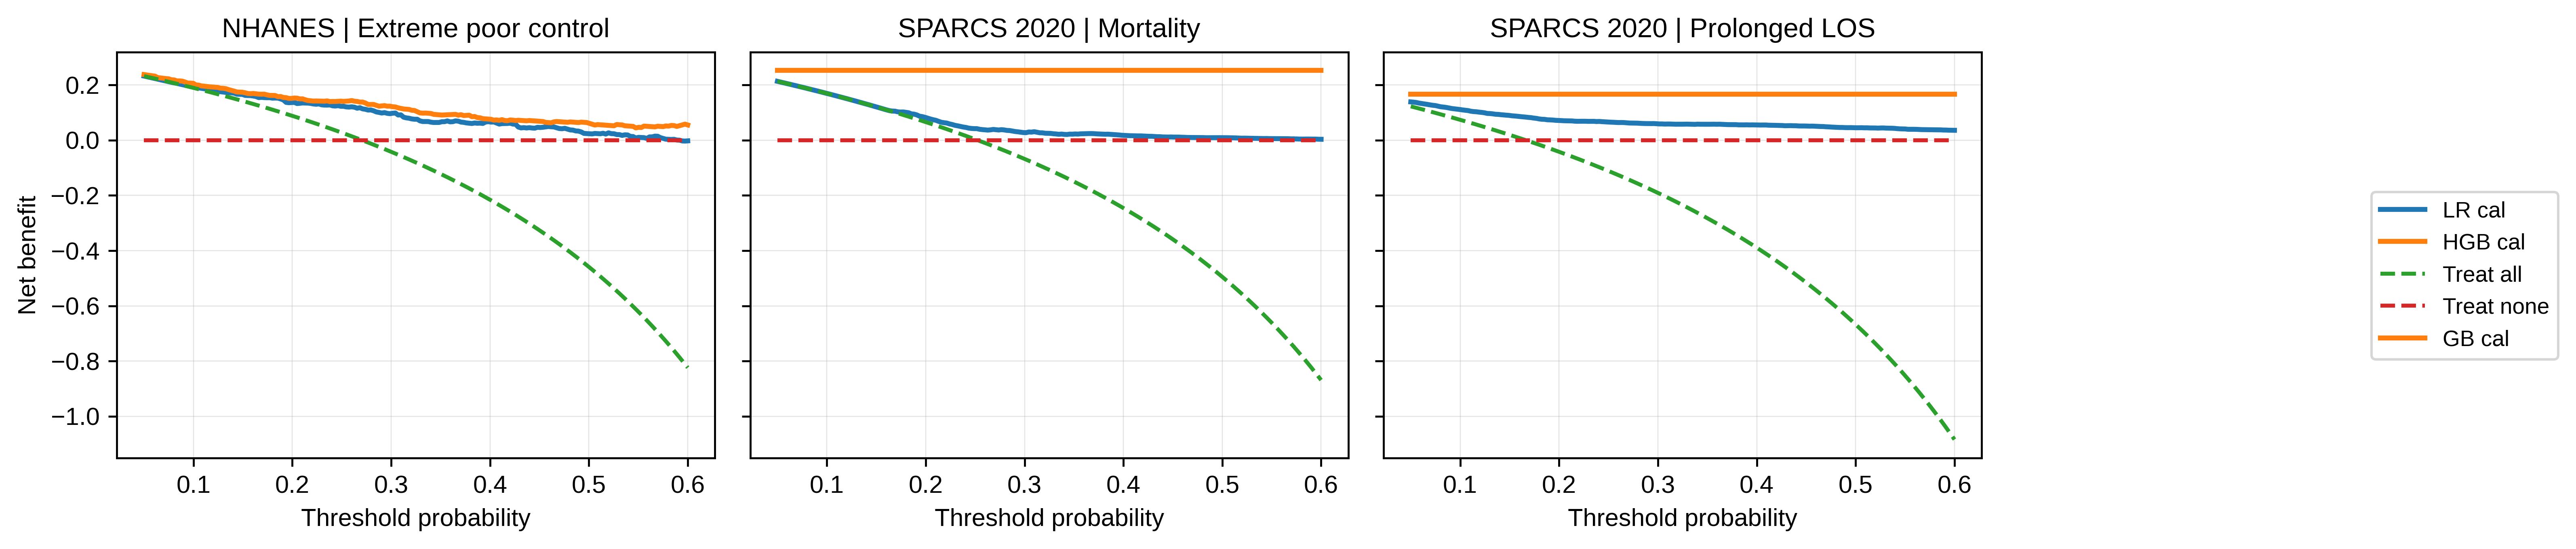

Saved to: /content/outputs/figures


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT_FIGS = Path("outputs/figures")
OUT_FIGS.mkdir(parents=True, exist_ok=True)

def net_benefit_curve(y_true, p, thresholds):
    """
    Net Benefit = TP/N - FP/N * (pt / (1-pt))
    """
    y = np.asarray(y_true).astype(int)
    p = np.asarray(p).astype(float)
    N = len(y)
    nb = []

    for pt in thresholds:
        y_hat = (p >= pt).astype(int)
        TP = np.sum((y_hat == 1) & (y == 1))
        FP = np.sum((y_hat == 1) & (y == 0))
        w = pt / (1 - pt)
        nb.append((TP / N) - (FP / N) * w)

    return np.asarray(nb)

def treat_all_curve(y_true, thresholds):
    y = np.asarray(y_true).astype(int)
    prev = y.mean()
    nb = []
    for pt in thresholds:
        w = pt / (1 - pt)
        nb.append(prev - (1 - prev) * w)
    return np.asarray(nb)

def treat_none_curve(thresholds):
    return np.zeros_like(thresholds, dtype=float)

def plot_dca_horizontal(panels, out_base, t_min=0.05, t_max=0.60, n=200):
    thresholds = np.linspace(t_min, t_max, n)

    # Two-column friendly width
    fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.2), dpi=220, sharey=True)

    # Collect handles once for a single legend
    handles, labels = [], []

    for ax, (task_name, y_true, model_probs) in zip(axes, panels):
        # model curves
        for label, p in model_probs.items():
            nb = net_benefit_curve(y_true, p, thresholds)
            h = ax.plot(thresholds, nb, linewidth=2.0, label=label)[0]
            if label not in labels:
                handles.append(h)
                labels.append(label)

        # baselines
        h_all = ax.plot(thresholds, treat_all_curve(y_true, thresholds),
                        linestyle="--", linewidth=1.6, label="Treat all")[0]
        h_none = ax.plot(thresholds, treat_none_curve(thresholds),
                         linestyle="--", linewidth=1.6, label="Treat none")[0]

        if "Treat all" not in labels:
            handles.append(h_all); labels.append("Treat all")
        if "Treat none" not in labels:
            handles.append(h_none); labels.append("Treat none")

        ax.set_title(task_name, fontsize=11)
        ax.set_xlabel("Threshold probability")
        ax.grid(True, linewidth=0.4, alpha=0.35)

    axes[0].set_ylabel("Net benefit")

    # one legend outside, clean for print
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.01, 0.5),
               frameon=True, fontsize=9)

    fig.tight_layout(rect=[0, 0, 0.86, 1])

    out_base = Path(out_base)
    fig.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight", pad_inches=0.02)
    fig.savefig(out_base.with_suffix(".svg"), bbox_inches="tight", pad_inches=0.02)
    fig.savefig(out_base.with_suffix(".png"), dpi=600, bbox_inches="tight", pad_inches=0.02)

    plt.show()
    plt.close(fig)

# --- Panels ---
panels = [
    ("NHANES | Extreme poor control",
     nhanes["splits"]["y_test"],
     {"LR cal": nhanes["preds"]["p_test_lr"],
      "HGB cal": nhanes["preds"]["p_test_hgb"]}),

    ("SPARCS 2020 | Mortality",
     sparcs_mort["splits"]["y_test"],
     {"LR cal": sparcs_mort["preds"]["p_test_lr"],
      "GB cal": sparcs_mort["preds"]["p_test_gb"]}),

    ("SPARCS 2020 | Prolonged LOS",
     sparcs_los["splits"]["y_test"],
     {"LR cal": sparcs_los["preds"]["p_test_lr"],
      "GB cal": sparcs_los["preds"]["p_test_gb"]}),
]

plot_dca_horizontal(panels, OUT_FIGS / "Supp_DCA_horizontal")
print("Saved to:", OUT_FIGS.resolve())


In [90]:
# =============================================================
# Recovery cell: rebuild task dictionaries from globals/artifacts
# (No full pipeline re-run required)
# =============================================================
import os
import glob
import pickle
import numpy as np

def _g(name, default=None):
    """Safe access to globals()."""
    return globals().get(name, default)

def _have(*names):
    """Check that all globals exist."""
    return all(n in globals() and _g(n) is not None for n in names)

def _as_np(y):
    y = _g(y) if isinstance(y, str) else y
    return np.asarray(y).astype(int)

def _predict_if_missing(art, model_key, prob_key):
    """
    If prob_key missing but a calibrated model exists, compute probabilities.
    Expects: art["cal"][model_key] with predict_proba, and art["splits"]["X_test"].
    """
    art.setdefault("preds", {})
    art.setdefault("cal", {})
    art.setdefault("splits", {})
    if prob_key in art["preds"]:
        return
    cal = art["cal"].get(model_key, None)
    Xte = art["splits"].get("X_test", None)
    if cal is not None and Xte is not None:
        try:
            art["preds"][prob_key] = cal.predict_proba(Xte)[:, 1]
        except Exception:
            pass

def _try_load_pickle_artifacts(search_dirs=("outputs", "output", "."), patterns=("*.pkl", "*.pickle")):
    """Search and load pickle artifacts from common folders."""
    hits = []
    for d in search_dirs:
        if not os.path.isdir(d):
            continue
        for pat in patterns:
            for fp in glob.glob(os.path.join(d, "**", pat), recursive=True):
                try:
                    with open(fp, "rb") as f:
                        obj = pickle.load(f)
                    hits.append((fp, obj))
                except Exception:
                    continue
    return hits

# -----------------------------
# 1) NHANES: rebuild from globals (as your notebook exports them)
# -----------------------------
nhanes = None
if _have("X_train_nh","y_train_nh","X_val_nh","y_val_nh","X_test_nh","y_test_nh"):
    nhanes = {
        "splits": {
            "X_train": _g("X_train_nh"),
            "y_train": _g("y_train_nh"),
            "X_val":   _g("X_val_nh"),
            "y_val":   _g("y_val_nh"),
            "X_test":  _g("X_test_nh"),
            "y_test":  _g("y_test_nh"),
        },
        "preds": {},
        "cal": {},
        "thr": {}
    }

    # Attach probabilities if already computed earlier in the notebook
    for k in ["p_test_lr","p_test_gb","p_test_hgb"]:
        if k in globals():
            nhanes["preds"][k] = _g(k)

    # Attach calibrated models if present
    # (your notebook naming often looks like cal_lr_nh, cal_gb_nh, cal_hgb_nh)
    if "cal_lr_nh" in globals():  nhanes["cal"]["lr"]  = _g("cal_lr_nh")
    if "cal_gb_nh" in globals():  nhanes["cal"]["gb"]  = _g("cal_gb_nh")
    if "cal_hgb_nh" in globals(): nhanes["cal"]["hgb"] = _g("cal_hgb_nh")

    # Attach thresholds if present
    if "thr_lr_nh" in globals():  nhanes["thr"]["lr"]  = float(_g("thr_lr_nh"))
    if "thr_gb_nh" in globals():  nhanes["thr"]["gb"]  = float(_g("thr_gb_nh"))
    if "thr_hgb_nh" in globals(): nhanes["thr"]["hgb"] = float(_g("thr_hgb_nh"))

    # If probabilities are missing but calibrators exist, compute them
    _predict_if_missing(nhanes, "lr",  "p_test_lr")
    _predict_if_missing(nhanes, "gb",  "p_test_gb")
    _predict_if_missing(nhanes, "hgb", "p_test_hgb")

    print("[OK] Rebuilt 'nhanes' from globals.")
else:
    print("[WARN] NHANES split globals not found (X_train_nh, ...).")

# -----------------------------
# 2) SPARCS: try existing variables first (as in your notebook)
# -----------------------------
sparcs_mort = _g("sparcs_mort", _g("sparcs_paper_mort", None))
sparcs_los  = _g("sparcs_los",  _g("sparcs_paper_los",  None))

# If missing, try loading from pickled artifacts in outputs
if sparcs_mort is None or sparcs_los is None:
    arts = _try_load_pickle_artifacts(search_dirs=("outputs","."))

    def _is_dict_like(x):
        return isinstance(x, dict)

    # Heuristic: pick artifacts by filename
    for fp, obj in arts:
        low = fp.lower()
        if not _is_dict_like(obj):
            continue
        if sparcs_mort is None and ("sparcs" in low) and ("mort" in low or "mortality" in low):
            sparcs_mort = obj
            print(f"[OK] Loaded SPARCS mortality artifact from: {fp}")
        if sparcs_los is None and ("sparcs" in low) and ("los" in low or "length" in low):
            sparcs_los = obj
            print(f"[OK] Loaded SPARCS LOS artifact from: {fp}")

# Normalise SPARCS artifact structure if found
def _normalise_sp_art(art):
    if art is None:
        return None
    art.setdefault("preds", {})
    art.setdefault("thr", {})
    art.setdefault("cal", {})
    art.setdefault("splits", {})
    # Sometimes X_test/y_test are stored at top-level
    if "X_test" in art and "X_test" not in art["splits"]:
        art["splits"]["X_test"] = art["X_test"]
    if "y_test" in art and "y_test" not in art["splits"]:
        art["splits"]["y_test"] = art["y_test"]
    # Ensure probabilities exist if calibrators exist
    _predict_if_missing(art, "lr", "p_test_lr")
    _predict_if_missing(art, "gb", "p_test_gb")
    _predict_if_missing(art, "hgb","p_test_hgb")
    return art

sparcs_mort = _normalise_sp_art(sparcs_mort)
sparcs_los  = _normalise_sp_art(sparcs_los)

if sparcs_mort is None:
    print("[WARN] SPARCS mortality artifact not found in memory or outputs.")
else:
    print("[OK] SPARCS mortality artifact ready.")

if sparcs_los is None:
    print("[WARN] SPARCS LOS artifact not found in memory or outputs.")
else:
    print("[OK] SPARCS LOS artifact ready.")


[OK] Rebuilt 'nhanes' from globals.
[OK] SPARCS mortality artifact ready.
[OK] SPARCS LOS artifact ready.


In [91]:
# =============================================================
# One-cell robust EBM for NHANES (fixed: safe globals iteration)
# =============================================================

!pip -q install interpret

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from interpret.glassbox import ExplainableBoostingClassifier

# --- 0) Check required NHANES splits exist ---
required = ["X_train_nh","y_train_nh","X_val_nh","y_val_nh","X_test_nh","y_test_nh"]
missing = [r for r in required if r not in globals()]
if missing:
    raise KeyError(f"Missing NHANES split variables: {missing}. Run the NHANES split cell first.")

Xtr_df = X_train_nh
Xva_df = X_val_nh
Xte_df = X_test_nh

if not hasattr(Xtr_df, "columns"):
    raise TypeError("X_train_nh must be a pandas DataFrame with column names.")

cols_nh = list(Xtr_df.columns)

# --- 1) Try to find a fitted preprocessor that matches NHANES columns ---
def _extract_preprocess_from_pipe(pipe: Pipeline):
    for k in ["preprocess", "preprocessor", "prep", "ct"]:
        if k in pipe.named_steps:
            return pipe.named_steps[k]
    for _, step in pipe.named_steps.items():
        if isinstance(step, ColumnTransformer):
            return step
    return list(pipe.named_steps.values())[0]

best = None
best_score = -1
best_name = None

# IMPORTANT: iterate over a static snapshot of globals
for name, obj in list(globals().items()):
    if isinstance(obj, Pipeline):
        try:
            prep = _extract_preprocess_from_pipe(obj)
            if hasattr(prep, "feature_names_in_"):
                fitted_cols = list(prep.feature_names_in_)
                inter = len(set(fitted_cols).intersection(cols_nh))
                union = len(set(fitted_cols).union(cols_nh))
                score = inter / max(union, 1)
                if score > best_score:
                    best_score = score
                    best = prep
                    best_name = name
        except Exception:
            continue

preprocess = None
if best is not None and best_score > 0.90:
    preprocess = best
    print(f"[OK] Found NHANES-matching preprocessor from pipeline '{best_name}' (overlap score={best_score:.3f})")
else:
    print("[WARN] No fitted NHANES preprocessor found in memory. Fitting a new one on X_train_nh (lightweight).")

    # --- 2) Fit a fresh preprocessor on NHANES train only ---
    candidate_num = ["num_cols_nh", "NHANES_NUM_COLS", "num_cols"]
    candidate_cat = ["cat_cols_nh", "NHANES_CAT_COLS", "cat_cols"]

    num_cols = None
    cat_cols = None

    for k in candidate_num:
        if k in globals():
            num_cols = list(globals()[k])
            break
    for k in candidate_cat:
        if k in globals():
            cat_cols = list(globals()[k])
            break

    if num_cols is None or cat_cols is None:
        num_cols = Xtr_df.select_dtypes(include=["number", "bool"]).columns.tolist()
        cat_cols = [c for c in Xtr_df.columns if c not in num_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]), num_cols),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
            ]), cat_cols)
        ],
        remainder="drop"
    )
    preprocess.fit(Xtr_df)

# --- 3) Transform and train EBM + calibration ---
Xtr = preprocess.transform(Xtr_df)
Xva = preprocess.transform(Xva_df)
Xte = preprocess.transform(Xte_df)

if hasattr(Xtr, "toarray"):
    Xtr = Xtr.toarray()
    Xva = Xva.toarray()
    Xte = Xte.toarray()

ebm = ExplainableBoostingClassifier(random_state=42, interactions=0)
ebm.fit(Xtr, y_train_nh)

cal_ebm = CalibratedClassifierCV(ebm, method="sigmoid", cv="prefit")
cal_ebm.fit(Xva, y_val_nh)

p_test_ebm = cal_ebm.predict_proba(Xte)[:, 1]

# --- 4) Store for downstream figures/tables ---
if "nhanes" not in globals() or nhanes is None:
    nhanes = {"splits": {}, "preds": {}}
nhanes.setdefault("splits", {})
nhanes.setdefault("preds", {})

nhanes["splits"]["y_test"] = y_test_nh
nhanes["preds"]["p_test_ebm"] = p_test_ebm

print(f"[OK] NHANES: saved nhanes['preds']['p_test_ebm'] (n={len(p_test_ebm)})")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 88.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 136.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 33.3 MB/s eta 0:00:00
[OK] Found NHANES-matching preprocessor from pipeline 'pre' (overlap score=1.000)
[OK] N

In [92]:
print("len p_test_ebm:", len(nhanes["preds"]["p_test_ebm"]))
print("len y_test:", len(nhanes["splits"]["y_test"]))


len p_test_ebm: 425
len y_test: 425


In [93]:
# =============================================================
# SPARCS: EBM (cal) for mortality_high_risk + prolonged LOS (together)
# Anti-leakage keyword drops + optional leakage-guard scan
# =============================================================

import re
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from interpret.glassbox import ExplainableBoostingClassifier

# --- prerequisites ---
if "df_sp" not in globals():
    raise NameError("df_sp not found in memory.")
if "split_xy" not in globals():
    raise NameError("split_xy not found. Run the cell that defines split_xy first.")
if "build_preprocessor" not in globals():
    raise NameError("build_preprocessor not found. Run the cell that defines build_preprocessor first.")

def keyword_drop_cols(df, patterns):
    cols = []
    for c in df.columns:
        c_low = c.lower()
        if any(re.search(p, c_low) for p in patterns):
            cols.append(c)
    return cols

def leakage_guard_auc_scan(X_tr, y_tr, auc_hi=0.995, auc_lo=0.005, max_cols=4000):
    y_tr = np.asarray(y_tr).astype(int)
    drop = []
    cols = list(X_tr.columns)[:max_cols]
    for c in cols:
        s = X_tr[c]
        try:
            if pd.api.types.is_numeric_dtype(s):
                x = pd.to_numeric(s, errors="coerce")
                if x.isna().any():
                    x = x.fillna(x.median())
                x = x.values.astype(float)
            else:
                codes, _ = pd.factorize(s.astype(str), sort=False)
                x = codes.astype(float)

            if len(np.unique(x)) < 3:
                continue

            auc = roc_auc_score(y_tr, x)
            if (auc >= auc_hi) or (auc <= auc_lo):
                drop.append(c)
        except Exception:
            continue
    return sorted(set(drop))

def strat_boot_ci(y, p, metric_fn, n_boot=600, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    vals = []

    for _ in range(n_boot):
        samp_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True) if len(idx_pos) else np.array([], dtype=int)
        samp_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True) if len(idx_neg) else np.array([], dtype=int)
        idx = np.concatenate([samp_pos, samp_neg])
        if len(idx) == 0:
            continue
        yy = y[idx]
        if len(np.unique(yy)) < 2:
            continue
        vals.append(metric_fn(yy, p[idx]))

    vals = np.asarray(vals)
    point = float(metric_fn(y, p))
    lo = float(np.quantile(vals, alpha/2))
    hi = float(np.quantile(vals, 1 - alpha/2))
    return point, lo, hi

def run_ebm_task(df, target, other_target, patterns, label, seed=42, do_guard=True):
    # 1) Keyword-based anti-leakage drops
    drop_cols = keyword_drop_cols(df, patterns)
    # also drop the other target if present
    if other_target in df.columns:
        drop_cols.append(other_target)
    # never drop the target itself
    drop_cols = [c for c in set(drop_cols) if c in df.columns and c != target]

    # 2) Split
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_xy(df, target, drop_cols)

    # 3) Optional leakage guard on TRAIN only
    leak_drop = []
    if do_guard:
        leak_drop = leakage_guard_auc_scan(X_tr, y_tr, auc_hi=0.995, auc_lo=0.005)
        if leak_drop:
            X_tr = X_tr.drop(columns=leak_drop, errors="ignore")
            X_va = X_va.drop(columns=leak_drop, errors="ignore")
            X_te = X_te.drop(columns=leak_drop, errors="ignore")

    print(f"[{label}] keyword_drops={len(drop_cols)} | leak_guard_drops={len(leak_drop)} | example_guard={leak_drop[:10]}")

    # 4) Preprocess + EBM + calibration
    pre, _, _ = build_preprocessor(X_tr)
    pre.fit(X_tr)

    Xtr = pre.transform(X_tr)
    Xva = pre.transform(X_va)
    Xte = pre.transform(X_te)

    if hasattr(Xtr, "toarray"):
        Xtr, Xva, Xte = Xtr.toarray(), Xva.toarray(), Xte.toarray()

    ebm = ExplainableBoostingClassifier(random_state=seed, interactions=0)
    ebm.fit(Xtr, np.asarray(y_tr).astype(int))

    cal = CalibratedClassifierCV(ebm, method="sigmoid", cv="prefit")
    cal.fit(Xva, np.asarray(y_va).astype(int))

    p_te = cal.predict_proba(Xte)[:, 1]
    y_te = np.asarray(y_te).astype(int)

    # 5) Metrics + CI
    auroc = strat_boot_ci(y_te, p_te, roc_auc_score, seed=seed, n_boot=600)
    auprc = strat_boot_ci(y_te, p_te, average_precision_score, seed=seed+1, n_boot=600)
    brier = strat_boot_ci(y_te, p_te, brier_score_loss, seed=seed+2, n_boot=600)

    print(f"EBM (cal) | {label}")
    print(f"  AUROC: {auroc[0]:.3f}  [95% CI {auroc[1]:.3f}, {auroc[2]:.3f}]")
    print(f"  AUPRC: {auprc[0]:.3f}  [95% CI {auprc[1]:.3f}, {auprc[2]:.3f}]")
    print(f"  Brier: {brier[0]:.3f}  [95% CI {brier[1]:.3f}, {brier[2]:.3f}]")

    return p_te, y_te

# --- Patterns ---
# Mortality: drop APR risk-of-mortality descriptors and discharge-related proxies
mort_patterns = [
    r"apr.*risk.*mort", r"risk.*mort", r"mortality", r"expired", r"death",
    r"discharg", r"dispos", r"transfer",
    r"total\s*charge", r"total\s*cost", r"charge", r"cost"
]

# LOS: drop LOS and discharge/cost proxies
los_patterns = [
    r"length", r"\blos\b", r"stay",
    r"discharg", r"dispos", r"transfer",
    r"total\s*charge", r"total\s*cost", r"charge", r"cost"
]

# --- Run both tasks ---
p_mort, y_mort = run_ebm_task(
    df_sp, target="mortality_high_risk", other_target="prolonged_los",
    patterns=mort_patterns, label="SPARCS 2020 mortality_high_risk", seed=42, do_guard=True
)

p_los, y_los = run_ebm_task(
    df_sp, target="prolonged_los", other_target="mortality_high_risk",
    patterns=los_patterns, label="SPARCS 2020 prolonged LOS", seed=42, do_guard=True
)

print("[DONE] SPARCS EBM metrics computed for both outcomes.")


[SPARCS 2020 mortality_high_risk] keyword_drops=6 | leak_guard_drops=0 | example_guard=[]
EBM (cal) | SPARCS 2020 mortality_high_risk
  AUROC: 0.894  [95% CI 0.886, 0.903]
  AUPRC: 0.758  [95% CI 0.742, 0.777]
  Brier: 0.109  [95% CI 0.105, 0.113]
[SPARCS 2020 prolonged LOS] keyword_drops=7 | leak_guard_drops=0 | example_guard=[]
EBM (cal) | SPARCS 2020 prolonged LOS
  AUROC: 0.884  [95% CI 0.873, 0.893]
  AUPRC: 0.641  [95% CI 0.613, 0.668]
  Brier: 0.090  [95% CI 0.086, 0.093]
[DONE] SPARCS EBM metrics computed for both outcomes.


In [96]:
# --- Quick calibration comparison on the validation set (no retraining of the base model) ---
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score

def compare_calibration_methods(prefit_model, X_val, y_val, label="model"):
    out = {}
    for method in ["sigmoid", "isotonic"]:
        cal = CalibratedClassifierCV(prefit_model, method=method, cv="prefit")
        cal.fit(X_val, y_val)
        p = cal.predict_proba(X_val)[:, 1]
        out[method] = {
            "brier": brier_score_loss(y_val, p),
            "auroc": roc_auc_score(y_val, p) if len(np.unique(y_val)) > 1 else np.nan
        }
    print(f"[{label}] validation comparison")
    for m in out:
        print(f"  {m:8s} | Brier={out[m]['brier']:.4f} | AUROC={out[m]['auroc']:.4f}")
    return out

# Example: run for LR and GB/HGB using your existing fitted pipelines
# NHANES example names often used in your notebook: pipe_lr, pipe_hgb, X_va, y_va
# SPARCS example names: best_lr, best_gb, or lr_pipe/gb_pipe plus X_va/y_va

_ = compare_calibration_methods(pipe_lr,  X_va, y_va, label="LR")
_ = compare_calibration_methods(pipe_hgb, X_va, y_va, label="HGB")


[LR] validation comparison
  sigmoid  | Brier=0.1774 | AUROC=0.7613
  isotonic | Brier=0.1648 | AUROC=0.7799
[HGB] validation comparison
  sigmoid  | Brier=0.1391 | AUROC=0.8447
  isotonic | Brier=0.1289 | AUROC=0.8582
